

# Demographics4Climate : Development v2.0

**Part 1. preprocess country-level info**

1. open country info from ISIMIP (countryData.json) + match it with worldbank income groups / regions (CLASS.xls) = load_country_metadata() - DONE
    - 1.1. add extra country info from countryprofiledata.json = load_country_stats() - DONE
    - note, added also non-countries from mask in later fxns

\

2. open cohort sizes from WCDE and interpolate with mean-preserving correction
    - done, note now available all scenarios ssp1-3
    - to do: add by male / female 

\


4. open country masks + gridded pop and attach to dictionary
    - note gridded pop ISIMIP3b available ssp1,3,5
    - ISIMIP2b available ssp2

\

**Part 2. Aggregate to gridscale, either one year all countries or one country all years, or both**
- done works well even multiple years all countries

\

**Part 3. [LATER] Lifetime accumulation**

1. open life expectancy from UN WPP 2022
2. make lifetime accumulation function

\

**To do/extensions:**
- add different scenarios! Of gridded pop and matching cohort sizes (ssp1: ISIMIP3b+wcde, ssp2: ISIMIP2b+wcde, ssp3: ISIMIP3b+wcde)
- find stray singapore-ish pixel
- add option to get male/female as well in da_demographics from WCDE
- countrymask has more admin units than geojson, check if any are useful

In [2]:
#netcdf4-python, regionmask (automatically imports xarray+gpd)

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import pickle as pk
from scipy import interpolate
import regionmask
import glob, os, re
import openpyxl
import matplotlib.pyplot as plt
import warnings


pd.set_option('display.max_rows', 80)
%matplotlib inline 

# 1. Country-level

## 1. load country_metadata(): isimip & world_bank

In [2]:
def load_country_metadata(
    filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json',
    filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx',
    keep_names='isimip',
    keep_stats=False,
    how='inner',

):
    """
    load country list from isipedia-coutries (country masks files) and metadata from worldbank

    Inputs
    keep_names : 'isimip', 'world_bank', 'both'

    Returns:
    
    """

    # open isimip metadata  
    df_isimip_metadata = pd.read_json(filepath_isimip_countries).replace(-9999, np.nan)
    # open world bank metadata
    df_wb_countries = pd.read_excel(filepath_world_bank, sheet_name=0)[0:218]
    # merge keep list of countries from isimip and info from world bank
    df_merge = df_isimip_metadata.merge(df_wb_countries, how=how,left_on='country_iso3', right_on='Code')

    # keep only some of the info and clean up column names 
    if keep_names =='isimip':
        keep_cols = ['country', 'Code', 'country_code','Region', 'Income group']
        d_rename = {'Code':'country_iso3', 'Region':'region', 'Income group': 'income_group'}
        
    elif keep_names == 'world_bank':
        keep_cols =['Economy', 'Code', 'country_code','Region', 'Income group']
        d_rename={'Economy':'country','Code':'country_iso3', 'Region':'region', 'Income group': 'income_group'}
        
    elif keep_names == 'both':
        keep_cols=['country','Economy', 'Code', 'country_code','Region', 'Income group']
        d_rename={'Economy':'country_wb','Code':'country_iso3', 'Region':'region', 'Income group': 'income_group'}     

    if keep_stats == True:
        keep_cols=keep_cols+list(df_isimip_metadata.columns[3:])

    df_metadata = df_merge[keep_cols].rename(columns=d_rename) #.head(196) # 'Economy', 
        
    return df_metadata

In [3]:
df_metadata = load_country_metadata(keep_stats = False)
df_metadata

# 195 countries 

country country_iso3  country_code  \
0                           Afghanistan          AFG             3   
1                               Albania          ALB           103   
2                               Algeria          DZA           203   
3                               Andorra          AND           403   
4                                Angola          AGO           503   
..                                  ...          ...           ...   
190  Venezuela (Bolivarian Republic of)          VEN         22503   
191                            Viet Nam          VNM         22603   
192                               Yemen          YEM         23003   
193                              Zambia          ZMB         23103   
194                            Zimbabwe          ZWE         23203   

                         region         income_group  
0                    South Asia           Low income  
1         Europe & Central Asia  Upper middle income  
2    Middle East & North Africa  Upper middle income  
3         Europe & Central Asia          High income  
4            Sub-Saharan Africa  Lower middle income  
..                          ...                  ...  
190   Latin America & Caribbean                  NaN  
191         East Asia & Pacific  Lower middle income  
192  Middle East & North Africa           Low income  
193          Sub-Saharan Africa  Lower middle income  
194          Sub-Saharan Africa  Lower middle income  

[195 rows x 5 columns]

In [4]:
df_metadata_s = load_country_metadata(keep_stats = True)
df_metadata_s


country country_iso3  country_code  \
0                           Afghanistan          AFG             3   
1                               Albania          ALB           103   
2                               Algeria          DZA           203   
3                               Andorra          AND           403   
4                                Angola          AGO           503   
..                                  ...          ...           ...   
190  Venezuela (Bolivarian Republic of)          VEN         22503   
191                            Viet Nam          VNM         22603   
192                               Yemen          YEM         23003   
193                              Zambia          ZMB         23103   
194                            Zimbabwe          ZWE         23203   

                         region         income_group   rank  \
0                    South Asia           Low income  170.0   
1         Europe & Central Asia  Upper middle income   69.0   
2    Middle East & North Africa  Upper middle income   82.0   
3         Europe & Central Asia          High income   36.0   
4            Sub-Saharan Africa  Lower middle income  149.0   
..                          ...                  ...    ...   
190   Latin America & Caribbean                  NaN   96.0   
191         East Asia & Pacific  Lower middle income  118.0   
192  Middle East & North Africa           Low income  177.0   
193          Sub-Saharan Africa  Lower middle income  143.0   
194          Sub-Saharan Africa  Lower middle income  150.0   

     HDI_Human_development_index_HDIg_value  \
0                                     0.496   
1                                     0.791   
2                                     0.759   
3                                     0.857   
4                                     0.574   
..                                      ...   
190                                   0.726   
191                                   0.693   
192                                   0.463   
193                                   0.591   
194                                   0.563   

     IHDI_Inequality_adjusted_HDI_geom_value  \
0                                        NaN   
1                                      0.705   
2                                      0.604   
3                                        NaN   
4                                      0.392   
..                                       ...   
190                                    0.600   
191                                    0.580   
192                                    0.316   
193                                    0.394   
194                                    0.435   

     MPI_2019_Multidimensional_poverty_index_revised  \
0                                              0.272   
1                                              0.003   
2                                              0.008   
3                                                NaN   
4                                              0.282   
..                                               ...   
190                                              NaN   
191                                            0.019   
192                                            0.241   
193                                            0.261   
194                                            0.137   

     GII_Gender_Inequality_Index_value  GDI_Gender_Development_Index  
0                                0.575                         0.723  
1                                0.234                         0.971  
2                                0.443                         0.865  
3                                  NaN                           NaN  
4                                0.578                         0.902  
..                                 ...                           ...  
190                              0.458                         1.013  
191                              0.314             

In [6]:
# df_metadata_o = load_country_metadata(keep_stats = False,how='outer',keep_names='both')
# df_metadata_o.tail(50)

### development

In [59]:
# Open ISIMIP metadata (Do I want to keep this or drop everything and keep it only in another element of dataset called 'country_stats_isimip'?)

filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json'

isimip_metadata = pd.read_json(filepath_isimip_countries)

In [4]:
isimip_metadata

country  country_code country_iso3  rank  \
0                           Afghanistan             3          AFG   170   
1                               Albania           103          ALB    69   
2                               Algeria           203          DZA    82   
3                               Andorra           403          AND    36   
4                                Angola           503          AGO   149   
..                                  ...           ...          ...   ...   
190  Venezuela (Bolivarian Republic of)         22503          VEN    96   
191                            Viet Nam         22603          VNM   118   
192                               Yemen         23003          YEM   177   
193                              Zambia         23103          ZMB   143   
194                            Zimbabwe         23203          ZWE   150   

     HDI_Human_development_index_HDIg_value  \
0                                     0.496   
1                                     0.791   
2                                     0.759   
3                                     0.857   
4                                     0.574   
..                                      ...   
190                                   0.726   
191                                   0.693   
192                                   0.463   
193                                   0.591   
194                                   0.563   

     IHDI_Inequality_adjusted_HDI_geom_value  \
0                                  -9999.000   
1                                      0.705   
2                                      0.604   
3                                  -9999.000   
4                                      0.392   
..                                       ...   
190                                    0.600   
191                                    0.580   
192                                    0.316   
193                                    0.394   
194                                    0.435   

     MPI_2019_Multidimensional_poverty_index_revised  \
0                                              0.272   
1                                              0.003   
2                                              0.008   
3                                          -9999.000   
4                                              0.282   
..                                               ...   
190                                        -9999.000   
191                                            0.019   
192                                            0.241   
193                                            0.261   
194                                            0.137   

     GII_Gender_Inequality_Index_value  GDI_Gender_Development_Index  
0                                0.575                         0.723  
1                                0.234                         0.971  
2                                0.443                         0.865  
3                            -9999.000                     -9999.000  
4                                0.578                         0.902  
..                                 ...                           ...  
190                              0.458                         1.013  
191                              0.314                         1.003  
192                              0.834                         0.458  
193                              0.540                         0.948  
194                              0.525                         0.925  

[195 rows x 9 columns]

In [22]:
isimip_metadata.sort_values('rank')

country  country_code country_iso3  rank  \
90   Korea (Democratic People's Rep. of)         10603          PRK -9999   
115                               Monaco         13503          MCO -9999   
122                                Nauru         14303          NRU -9999   
161                              Somalia         19203          SOM -9999   
181                               Tuvalu         21603          TUV -9999   
..                                   ...           ...          ...   ...   
27                               Burundi          3203          BDI   185   
163                          South Sudan         23303          SSD   186   
33                                  Chad          3903          TCD   187   
32              Central African Republic          3803          CAF   188   
127                                Niger         15003          NER   189   

     HDI_Human_development_index_HDIg_value  \
90                                -9999.000   
115                               -9999.000   
122                               -9999.000   
161                               -9999.000   
181                               -9999.000   
..                                      ...   
27                                    0.423   
163                                   0.413   
33                                    0.401   
32                                    0.381   
127                                   0.377   

     IHDI_Inequality_adjusted_HDI_geom_value  \
90                                 -9999.000   
115                                -9999.000   
122                                -9999.000   
161                                -9999.000   
181                                -9999.000   
..                                       ...   
27                                     0.296   
163                                    0.264   
33                                     0.250   
32                                     0.222   
127                                    0.272   

     MPI_2019_Multidimensional_poverty_index_revised  \
90                                         -9999.000   
115                                        -9999.000   
122                                        -9999.000   
161                                        -9999.000   
181                                        -9999.000   
..                                               ...   
27                                             0.403   
163                                            0.580   
33                                             0.533   
32                                             0.465   
127                                            0.590   

     GII_Gender_Inequality_Index_value  GDI_Gender_Development_Index  
90                           -9999.000                     -9999.000  
115                          -9999.000                     -9999.000  
122                          -9999.000                     -9999.000  
161                          -9999.000                     -9999.000  
181                          -9999.000                     -9999.000  
..                                 ...                           ...  
27                               0.520                         1.003  
163                          -9999.000                         0.839  
33                               0.701                         0.774  
32                               0.682                         0.795  
127                              0.647                         0.298  

[195 rows x 9 columns]

In [25]:
df_isimip_metadata = isimip_metadata.replace(-9999, np.nan)
df_isimip_metadata.sort_values('rank').tail(10)

country  country_code country_iso3   rank  \
163                          South Sudan         23303          SSD  186.0   
33                                  Chad          3903          TCD  187.0   
32              Central African Republic          3803          CAF  188.0   
127                                Niger         15003          NER  189.0   
90   Korea (Democratic People's Rep. of)         10603          PRK    NaN   
115                               Monaco         13503          MCO    NaN   
122                                Nauru         14303          NRU    NaN   
150                           San Marino         18003          SMR    NaN   
161                              Somalia         19203          SOM    NaN   
181                               Tuvalu         21603          TUV    NaN   

     HDI_Human_development_index_HDIg_value  \
163                                   0.413   
33                                    0.401   
32                                    0.381   
127                                   0.377   
90                                      NaN   
115                                     NaN   
122                                     NaN   
150                                     NaN   
161                                     NaN   
181                                     NaN   

     IHDI_Inequality_adjusted_HDI_geom_value  \
163                                    0.264   
33                                     0.250   
32                                     0.222   
127                                    0.272   
90                                       NaN   
115                                      NaN   
122                                      NaN   
150                                      NaN   
161                                      NaN   
181                                      NaN   

     MPI_2019_Multidimensional_poverty_index_revised  \
163                                            0.580   
33                                             0.533   
32                                             0.465   
127                                            0.590   
90                                               NaN   
115                                              NaN   
122                                              NaN   
150                                              NaN   
161                                              NaN   
181                                              NaN   

     GII_Gender_Inequality_Index_value  GDI_Gender_Development_Index  
163                                NaN                         0.839  
33                               0.701                         0.774  
32                               0.682                         0.795  
127                              0.647                         0.298  
90                                 NaN                           NaN  
115                                NaN                           NaN  
122                                NaN                           NaN  
150                                NaN                           NaN  
161                                NaN                           NaN  
181                                NaN                           NaN

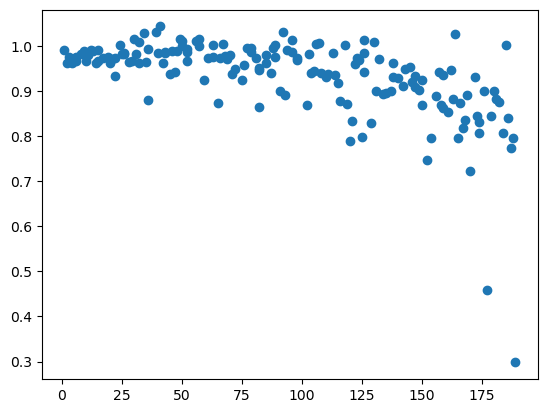

In [26]:
plt.scatter(df_isimip_metadata['rank'], df_isimip_metadata['GDI_Gender_Development_Index'])

In [28]:
# open world bank data 

filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx'

df_wb_countries = pd.read_excel(filepath_world_bank, sheet_name=0)
df_wb_countries

# todo: put sheet 2 info on what countries are in what regions in some d_regions ! 

Economy Code  \
0                                   Afghanistan  AFG   
1                                       Albania  ALB   
2                                       Algeria  DZA   
3                                American Samoa  ASM   
4                                       Andorra  AND   
..                                          ...  ...   
262                          Sub-Saharan Africa  SSF   
263  Sub-Saharan Africa (excluding high income)  SSA   
264             Sub-Saharan Africa (IDA & IBRD)  TSS   
265                         Upper middle income  UMC   
266                                       World  WLD   

                         Region         Income group Lending category  
0                    South Asia           Low income              IDA  
1         Europe & Central Asia  Upper middle income             IBRD  
2    Middle East & North Africa  Upper middle income             IBRD  
3           East Asia & Pacific          High income              NaN  
4         Europe & Central Asia          High income              NaN  
..                          ...                  ...              ...  
262                         NaN                  NaN              NaN  
263                         NaN                  NaN              NaN  
264                         NaN                  NaN              NaN  
265                         NaN                  NaN              NaN  
266                         NaN                  NaN              NaN  

[267 rows x 5 columns]

In [41]:
df_merge = df_isimip_metadata.merge(df_wb_countries, how='inner',left_on='country_iso3', right_on='Code')
df_merge

country  country_code country_iso3   rank  \
0                           Afghanistan             3          AFG  170.0   
1                               Albania           103          ALB   69.0   
2                               Algeria           203          DZA   82.0   
3                               Andorra           403          AND   36.0   
4                                Angola           503          AGO  149.0   
..                                  ...           ...          ...    ...   
190  Venezuela (Bolivarian Republic of)         22503          VEN   96.0   
191                            Viet Nam         22603          VNM  118.0   
192                               Yemen         23003          YEM  177.0   
193                              Zambia         23103          ZMB  143.0   
194                            Zimbabwe         23203          ZWE  150.0   

     HDI_Human_development_index_HDIg_value  \
0                                     0.496   
1                                     0.791   
2                                     0.759   
3                                     0.857   
4                                     0.574   
..                                      ...   
190                                   0.726   
191                                   0.693   
192                                   0.463   
193                                   0.591   
194                                   0.563   

     IHDI_Inequality_adjusted_HDI_geom_value  \
0                                        NaN   
1                                      0.705   
2                                      0.604   
3                                        NaN   
4                                      0.392   
..                                       ...   
190                                    0.600   
191                                    0.580   
192                                    0.316   
193                                    0.394   
194                                    0.435   

     MPI_2019_Multidimensional_poverty_index_revised  \
0                                              0.272   
1                                              0.003   
2                                              0.008   
3                                                NaN   
4                                              0.282   
..                                               ...   
190                                              NaN   
191                                            0.019   
192                                            0.241   
193                                            0.261   
194                                            0.137   

     GII_Gender_Inequality_Index_value  GDI_Gender_Development_Index  \
0                                0.575                         0.723   
1                                0.234                         0.971   
2                                0.443                         0.865   
3                                  NaN                           NaN   
4                                0.578                         0.902   
..                                 ...                           ...   
190                              0.458                         1.013   
191                              0.314                         1.003   
192                              0.834                         0.458   
193                              0.540                         0.948   
194                              0.525                         0.925   

           Economy Code                      Region         Income group  \
0      Afghanistan  AFG                  South Asia           Low income   
1          Albania  ALB       Europe & Central Asia  Upper middle income   
2          Algeria  DZA  Middle East & North Africa  Upper middle income   
3          Andorra  AND       Europe & Central Asia          High income   
4           Angola  AGO          Sub-Saharan Af

In [53]:
df_merge[['country', 'Code', 'country_code','Region', 'Income group']].rename(columns={'Code':'country_iso3', 'Region':'region', 'Income group': 'income_group'}) #.head(196) # 'Economy', 

country country_iso3  country_code  \
0                           Afghanistan          AFG             3   
1                               Albania          ALB           103   
2                               Algeria          DZA           203   
3                               Andorra          AND           403   
4                                Angola          AGO           503   
..                                  ...          ...           ...   
190  Venezuela (Bolivarian Republic of)          VEN         22503   
191                            Viet Nam          VNM         22603   
192                               Yemen          YEM         23003   
193                              Zambia          ZMB         23103   
194                            Zimbabwe          ZWE         23203   

                         region         income_group  
0                    South Asia           Low income  
1         Europe & Central Asia  Upper middle income  
2    Middle East & North Africa  Upper middle income  
3         Europe & Central Asia          High income  
4            Sub-Saharan Africa  Lower middle income  
..                          ...                  ...  
190   Latin America & Caribbean                  NaN  
191         East Asia & Pacific  Lower middle income  
192  Middle East & North Africa           Low income  
193          Sub-Saharan Africa  Lower middle income  
194          Sub-Saharan Africa  Lower middle income  

[195 rows x 5 columns]

## 2. load_country_stats(): isimip


In [7]:
def load_country_stats(filepath_isimip_stats = './data-new/country-masks/isipedia-countries/countryprofiledata.json'
                      ):

    df_isimip_stats = pd.read_json(filepath_isimip_stats).T.reset_index(drop=True).replace(-9999, np.nan).rename(columns={'iso3':'country_iso3'})

    return df_isimip_stats

In [8]:
df_isimip_stats = load_country_stats()
df_isimip_stats

country country_iso3  \
0             Afghanistan          AFG   
1                  Angola          AGO   
2                 Albania          ALB   
3                 Andorra          AND   
4    United Arab Emirates          ARE   
..                    ...          ...   
190                 Samoa          WSM   
191                 Yemen          YEM   
192          South Africa          ZAF   
193                Zambia          ZMB   
194              Zimbabwe          ZWE   

     Account_ownership_at_a_financial_institution_or_with_a_mobile_money_service_provider_female_  \
0                                             7.160685                                              
1                                            22.331646                                              
2                                            38.102959                                              
3                                                  NaN                                              
4                                            76.416718                                              
..                                                 ...                                              
190                                                NaN                                              
191                                           1.671490                                              
192                                          69.989815                                              
193                                          40.278877                                              
194                                          51.664925                                              

     Adjusted_net_savings__of_GNI  \
0                         2.72840   
1                       -16.33161   
2                         8.20754   
3                             NaN   
4                             NaN   
..                            ...   
190                           NaN   
191                           NaN   
192                       0.63234   
193                       9.24266   
194                     -22.18013   

     Adolescent_birth_rate_births_per_1000_women_ages_15_19  \
0                                               68.957        
1                                              150.526        
2                                               19.642        
3                                                  NaN        
4                                                6.546        
..                                                 ...        
190                                             23.886        
191                                             60.352        
192                                             67.908        
193                                            120.112        
194                                             86.135        

     Adult_literacy_rate__ages_15_and_older  \
0                                  31.74112   
1                                  66.03011   
2                                  97.24697   
3                                       NaN   
4                                       NaN   
..                                      ...   
190                                98.97326   
191                                     NaN   
192                                94.36792   
193                                83.00767   
194                                88.69342   

     Adult_mortality_rate_female_per_1000_people  \
0                                        198.184   
1                                        199.981   
2                                         49.715   
3                                            NaN   
4                                         54.933   
..                                           ...   
190                                       79.195   
191                                      192.885   
192                                      258.471   
193          

### develop

In [7]:
filepath_isimip_stats = './data-new/country-masks/isipedia-countries/countryprofiledata.json'

df_isimip_stats = pd.read_json(filepath_isimip_stats).T.reset_index(drop=True).replace(-9999, np.nan)
[print(i) for i in df_isimip_stats.columns];

country
iso3
Account_ownership_at_a_financial_institution_or_with_a_mobile_money_service_provider_female_
Adjusted_net_savings__of_GNI
Adolescent_birth_rate_births_per_1000_women_ages_15_19
Adult_literacy_rate__ages_15_and_older
Adult_mortality_rate_female_per_1000_people
Adult_mortality_rate_male_per_1000_people
Antenatal_care_coverage_at_least_one_visit_
Birth_registration__under_age_5_SDG
Change_in_forest_area_1990_2016
Child_labour__ages_5_17_SDG
Child_marriage_married_by_age_18__SDG
Children_under_five_who_are_stunted_moderate_and_severe
Concentration_index___exports
Contraceptive_prevalence_any_method_
Current_health_expenditure__of_GDP
Dependency_ratio_old_age_65_and_older_per_100_people_ages_15_64
Dependency_ratio_young_age_0_14_per_100_people_ages_15_64
Domestic_credit_provided_by_financial_sector__of_GDP
Education_and_health_expenditure_to_military_expenditure_ratio
Employment_in_agriculture__of_total_employment
Employment_in_services__of_total_employment
Employment_to_popula

Text(0, 0.5, 'PISA maths')

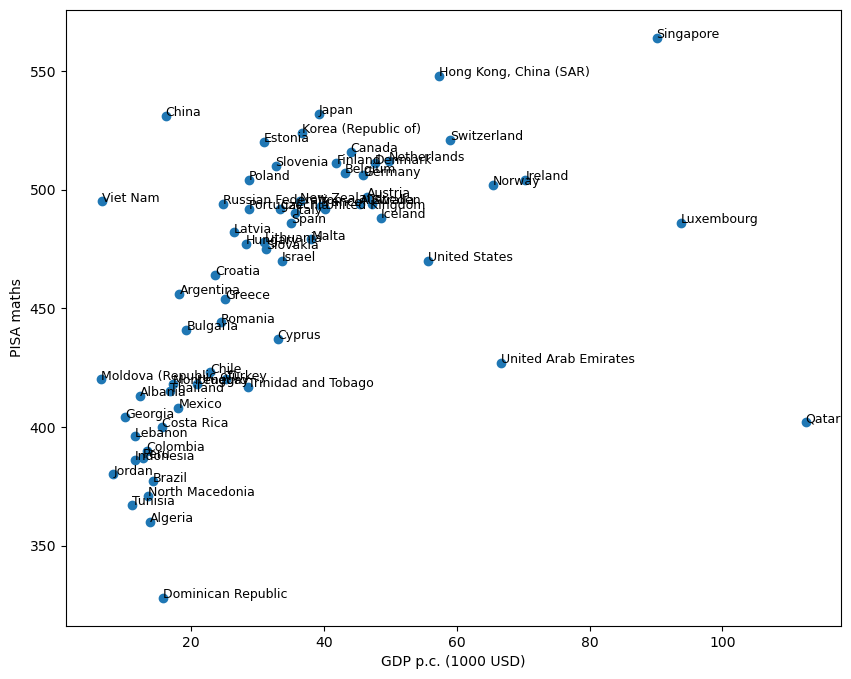

In [19]:
x = df_isimip_stats['Gross_domestic_product_GDP_per_capita_2011_PPP'] / 1000
y = df_isimip_stats['Programme_for_International_Student_Assessment_PISA_score_in_mathematics']
labels=df_isimip_stats['country']

plt.figure(figsize=(10, 8))   
plt.scatter(x,y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), size=9)

plt.xlabel('GDP p.c. (1000 USD)')
plt.ylabel('PISA maths')

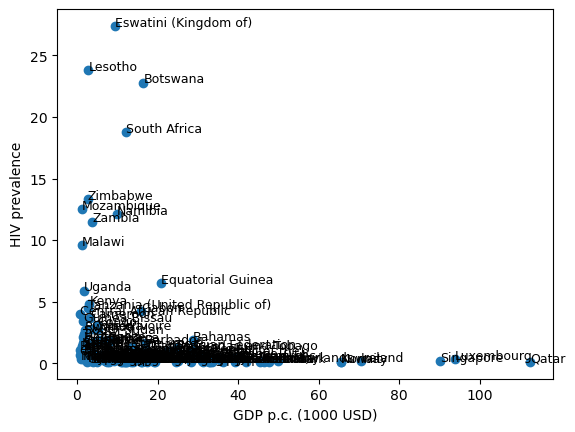

In [23]:
x = df_isimip_stats['Gross_domestic_product_GDP_per_capita_2011_PPP'] / 1000
y = df_isimip_stats['HIV_prevalence_adult__ages_15_49']
labels=df_isimip_stats['country']

#plt.figure(figsize=(10, 8))   
plt.scatter(x,y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), size=9)

plt.xlabel('GDP p.c. (1000 USD)')
plt.ylabel('HIV prevalence');

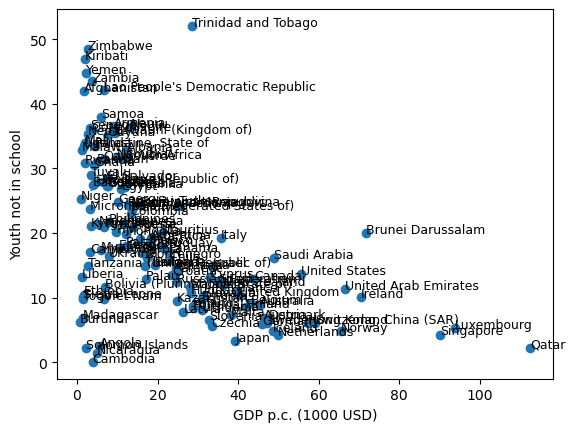

In [25]:
x = df_isimip_stats['Gross_domestic_product_GDP_per_capita_2011_PPP'] / 1000
y = df_isimip_stats['Youth_not_in_school_or_employment__ages_15_24']
labels=df_isimip_stats['country']

#plt.figure(figsize=(10, 8))   
plt.scatter(x,y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), size=9)

plt.xlabel('GDP p.c. (1000 USD)')
plt.ylabel('Youth not in school');

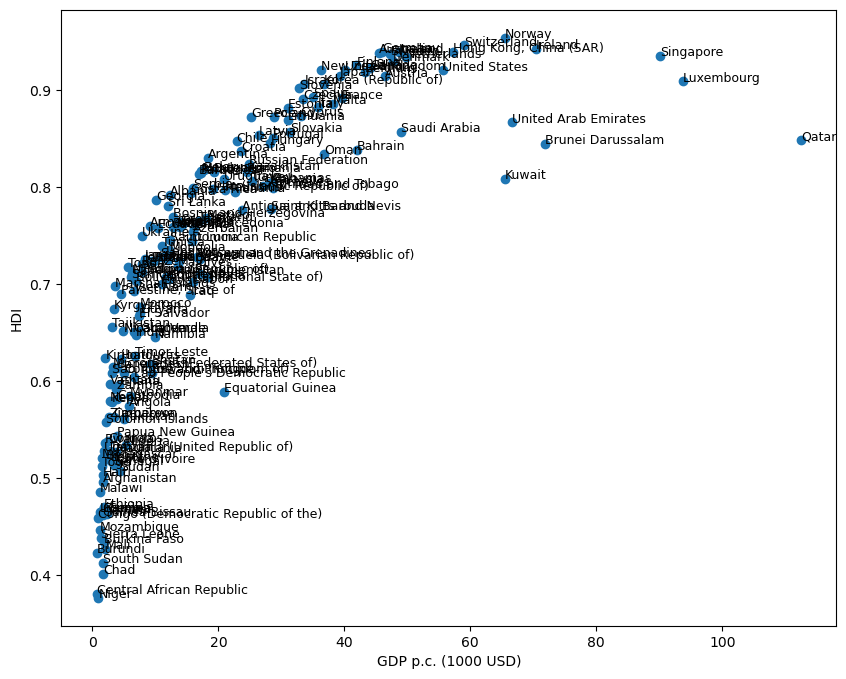

In [28]:
x = df_isimip_stats['Gross_domestic_product_GDP_per_capita_2011_PPP'] / 1000
y = df_isimip_stats['HDI_Human_development_index_HDIg_value']
labels=df_isimip_stats['country']

plt.figure(figsize=(10, 8))   
plt.scatter(x,y)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), size=9)

plt.xlabel('GDP p.c. (1000 USD)')
plt.ylabel('HDI');

## 3. load_cohort_sizes(): wcde

In [9]:
def load_cohort_sizes( filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv', 
                                         './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                                         './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv'],
                      ssp = 2,
                      by_sex = False
):
    """
    load population size per age cohort from Wittgenstein Center Data Explorer (source: http://dataexplorer.wittgensteincentre.org/wcde-v2/)

    data description: Population Size (000's)
    De facto population in a country or region, classified by sex and by five-year age groups. Available in all scenarios and at all geographical scales. 
    Figures are presented in thousands.
    Note on input data. For each country data is sorted first by age cohort (0-4, 4-9...). So all the first data refers to the 0-4 age cohort. 
    Then they give the population size of that cohort at a snapshot every 5 years (1950, 1955, 1960...).
    Here we assign the data to the central age cohort (i.e. 0-4 assigned to 2).
    
    Input:
        csv files for different ssps
        sel_ssp : 1,2,3 for ssp1, ssp2, ssp3
        by_sex: TODO (data is available male/female)

    Returns
        df_cohort_sizes (df): rows are countries, columns are a cohort's (e.g. age=2) 
                                size each year, then the next cohort (columns labelled e.g. 2_1950 age=2, year=1950)
        ages (arr) : central year of interval (2,7...102)
        years (arr) : years we have data for (1950, 1955...2100)
    """

    def convert_age_range(age):
        if age == '100+':
            return 100
        else:
            match = re.match(r'(\d+)--\d+', age)
            if match:
                return int(match.group(1))
            else:
                return int(age)
            

    # open wcde cohort size file 
    filepath = filepaths_wcde[ssp-1]
    df_raw = pd.read_csv(filepath, header=7) # population is in 000's

    # total national population through time (rows = countries with names from WCDE, check they match, columns = years)
    df_pop_national = df_raw[(df_raw['Sex'] == 'Both') & (df_raw['Age'] == 'All')][['Area', 'Year', 'Population']].pivot(index="Area", columns="Year", values="Population")

    # cohort size specific
    if by_sex == False:

        # select only relevant rows and cols
        df = df_raw[(df_raw['Sex'] == 'Both') & (df_raw['Age'] != 'All')][['Area', 'Year', 'Age', 'Population']]
        
        # central year in age bracket e.g. 0-4 becomes 2, 5-9 becomes 7 
        df['Age'] = df['Age'].apply(convert_age_range) + 2 
              
        # Initialize an empty DataFrame for the final result
        df_cohort_sizes = pd.DataFrame()
        # Get unique ages
        ages = df['Age'].unique()
        years = df['Year'].unique()
        
        # Loop through each age and pivot the data
        for age in ages:
            subset = df[df['Age'] == age].pivot(index='Area', columns='Year', values='Population')
            subset.columns = [f'{age}_{year}' for year in subset.columns] # name the columns e.g. 2_1950
            if df_cohort_sizes.empty:
                df_cohort_sizes = subset
            else:
                df_cohort_sizes = df_cohort_sizes.join(subset, how='outer')
    
    # Reset index to turn the 'Area' index back into a column
    #result_df.reset_index(inplace=True)

    else:
        pass
        # TO DEVELOP ! BY SEX ! 
    
    return df_cohort_sizes, ages, years

In [10]:
df_cohort_sizes, ages, years = load_cohort_sizes(ssp=2)
df_cohort_sizes

# 202 countries, not sure what extras are (there is world etc. you will need to get rid of these! )

2_1950    2_1955    2_1960    2_1965    2_1970  \
Area                                                                    
Afghanistan            1291.6    1355.1    1539.5    1762.1    2025.6   
Albania                 180.8     222.5     272.9     309.7     312.3   
Algeria                1403.1    1830.6    2081.8    2398.0    2692.6   
Angola                  739.2    1023.5    1095.3    1196.5    1298.7   
Antigua and Barbuda       6.6       8.4       8.9       9.2       9.9   
...                       ...       ...       ...       ...       ...   
Western Sahara            2.4       3.3       5.4       8.7      13.2   
World                338387.2  405612.1  432642.8  480601.0  523700.8   
Yemen                   770.2     777.9     860.3     978.0    1173.4   
Zambia                  423.0     483.3     578.8     698.3     814.8   
Zimbabwe                441.6     614.9     725.0     864.3    1009.7   

                       2_1975    2_1980    2_1985    2_1990    2_1995  ...  \
Area                                                                   ...   
Afghanistan            2326.7    2484.4    2276.9    2377.9    3325.5  ...   
Albania                 324.8     335.2     355.5     388.5     334.4  ...   
Algeria                3086.2    3528.0    3893.8    3994.2    3734.3  ...   
Angola                 1515.1    1810.3    2122.6    2438.5    2799.6  ...   
Antigua and Barbuda       9.3       7.3       7.2       7.4       6.8  ...   
...                       ...       ...       ...       ...       ...  ...   
Western Sahara           13.3      23.0      29.2      31.8      34.6  ...   
World                543302.0  548178.6  592792.3  644867.3  623061.1  ...   
Yemen                  1348.4    1709.7    2115.3    2603.1    3082.0  ...   
Zambia                  979.1    1148.2    1309.8    1480.3    1670.7  ...   
Zimbabwe               1204.2    1430.4    1641.3    1736.2    1780.9  ...   

                     102_2055  102_2060  102_2065  102_2070  102_2075  \
Area                                                                    
Afghanistan               0.2       0.2       0.3       0.4       0.5   
Albania                   3.2       5.5       8.0       9.7      11.8   
Algeria                  15.7      23.0      35.4      52.8      78.8   
Angola                    0.4       0.5       0.6       0.8       1.1   
Antigua and Barbuda       0.0       0.1       0.1       0.1       0.1   
...                       ...       ...       ...       ...       ...   
Western Sahara            0.0       0.0       0.1       0.1       0.2   
World                  5799.9    7789.0   10822.7   14499.7   18443.9   
Yemen                     0.3       0.4       0.5       0.7       1.1   
Zambia                    0.2       0.3       0.4       0.5       0.8   
Zimbabwe                  0.3       0.4       0.5       0.6       0.9   

                     102_2080  102_2085  102_2090  102_2095  102_2100  
Area                                                                   
Afghanistan               0.7       0.9       1.1       1.6       2.4  
Albania                  14.7      19.1      20.3      24.7      35.4  
Algeria                 123.7     179.8     235.8     281.4     297.1  
Angola                    1.5       2.1       3.0       4.2       6.1  
Antigua and Barbuda       0.1       0.2       0.2       0.3       0.3  
...                       ...       ...       ...       ...       ...  
Western Sahara            0.3       0.4       0.5       0.7       0.9  
World                 22134.8   28115.2   36321.0   42244.2   48218.6  
Yemen                     2.1       3.4       5.2       7.8      10.2  
Zambia                    1.0       1.4       1.8       2.4       3.4  
Zimbabwe                  1.4       2.3       3.1       4.2       5.7  

[202 rows x 651 columns]

In [11]:
ages

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102])

In [12]:
years

array([1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000,
       2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
       2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100])

In [13]:
df_cohort_sizes_ssp1, none, none = load_cohort_sizes(ssp=1)
df_cohort_sizes_ssp1

2_1950    2_1955    2_1960    2_1965    2_1970  \
Area                                                                    
Afghanistan            1291.6    1355.1    1539.5    1762.1    2025.6   
Albania                 180.8     222.5     272.9     309.7     312.3   
Algeria                1403.1    1830.6    2081.8    2398.0    2692.6   
Angola                  739.2    1023.5    1095.3    1196.5    1298.7   
Antigua and Barbuda       6.6       8.4       8.9       9.2       9.9   
...                       ...       ...       ...       ...       ...   
Western Sahara            2.4       3.3       5.4       8.7      13.2   
World                338387.2  405612.1  432642.8  480601.0  523700.8   
Yemen                   770.2     777.9     860.3     978.0    1173.4   
Zambia                  423.0     483.3     578.8     698.3     814.8   
Zimbabwe                441.6     614.9     725.0     864.3    1009.7   

                       2_1975    2_1980    2_1985    2_1990    2_1995  ...  \
Area                                                                   ...   
Afghanistan            2326.7    2484.4    2276.9    2377.9    3325.5  ...   
Albania                 324.8     335.2     355.5     388.5     334.4  ...   
Algeria                3086.2    3528.0    3893.8    3994.2    3734.3  ...   
Angola                 1515.1    1810.3    2122.6    2438.5    2799.6  ...   
Antigua and Barbuda       9.3       7.3       7.2       7.4       6.8  ...   
...                       ...       ...       ...       ...       ...  ...   
Western Sahara           13.3      23.0      29.2      31.8      34.6  ...   
World                543302.0  548178.6  592792.3  644867.3  623061.1  ...   
Yemen                  1348.4    1709.7    2115.3    2603.1    3082.0  ...   
Zambia                  979.1    1148.2    1309.8    1480.3    1670.7  ...   
Zimbabwe               1204.2    1430.4    1641.3    1736.2    1780.9  ...   

                     102_2055  102_2060  102_2065  102_2070  102_2075  \
Area                                                                    
Afghanistan               0.2       0.4       0.5       0.9       1.5   
Albania                   7.7      14.4      22.5      29.5      38.5   
Algeria                  35.5      59.5     102.6     169.3     274.7   
Angola                    0.5       0.8       1.2       2.0       3.2   
Antigua and Barbuda       0.1       0.1       0.3       0.5       0.5   
...                       ...       ...       ...       ...       ...   
Western Sahara            0.1       0.1       0.2       0.4       0.8   
World                 10935.8   16169.6   24738.2   36753.0   51624.6   
Yemen                     0.5       0.8       1.3       2.0       3.4   
Zambia                    0.3       0.5       0.7       1.2       2.1   
Zimbabwe                  0.4       0.6       0.9       1.4       2.7   

                     102_2080  102_2085  102_2090  102_2095  102_2100  
Area                                                                   
Afghanistan               2.6       4.2       7.0      12.6      24.7  
Albania                  50.5      67.8      78.4      96.5     134.1  
Algeria                 456.6     720.0    1011.7    1267.8    1406.3  
Angola                    5.1       7.9      13.0      21.4      38.3  
Antigua and Barbuda       0.5       0.8       1.0       1.3       1.7  
...                       ...       ...       ...       ...       ...  
Western Sahara            1.4       2.2       3.9       6.0       8.4  
World                 68445.8   95149.6  135116.3  171695.9  209281.3  
Yemen                     7.0      13.6      26.9      51.2      84.8  
Zambia                    3.6       5.7       9.5      15.2      24.8  
Zimbabwe                  5.5      10.0      15.7      23.5      35.2  

[202 rows x 651 columns]

In [14]:
df_cohort_sizes_ssp3, none, none = load_cohort_sizes(ssp=3)
df_cohort_sizes_ssp3

2_1950    2_1955    2_1960    2_1965    2_1970  \
Area                                                                    
Afghanistan            1291.6    1355.1    1539.5    1762.1    2025.6   
Albania                 180.8     222.5     272.9     309.7     312.3   
Algeria                1403.1    1830.6    2081.8    2398.0    2692.6   
Angola                  739.2    1023.5    1095.3    1196.5    1298.7   
Antigua and Barbuda       6.6       8.4       8.9       9.2       9.9   
...                       ...       ...       ...       ...       ...   
Western Sahara            2.4       3.3       5.4       8.7      13.2   
World                338387.2  405612.1  432642.8  480601.0  523700.8   
Yemen                   770.2     777.9     860.3     978.0    1173.4   
Zambia                  423.0     483.3     578.8     698.3     814.8   
Zimbabwe                441.6     614.9     725.0     864.3    1009.7   

                       2_1975    2_1980    2_1985    2_1990    2_1995  ...  \
Area                                                                   ...   
Afghanistan            2326.7    2484.4    2276.9    2377.9    3325.5  ...   
Albania                 324.8     335.2     355.5     388.5     334.4  ...   
Algeria                3086.2    3528.0    3893.8    3994.2    3734.3  ...   
Angola                 1515.1    1810.3    2122.6    2438.5    2799.6  ...   
Antigua and Barbuda       9.3       7.3       7.2       7.4       6.8  ...   
...                       ...       ...       ...       ...       ...  ...   
Western Sahara           13.3      23.0      29.2      31.8      34.6  ...   
World                543302.0  548178.6  592792.3  644867.3  623061.1  ...   
Yemen                  1348.4    1709.7    2115.3    2603.1    3082.0  ...   
Zambia                  979.1    1148.2    1309.8    1480.3    1670.7  ...   
Zimbabwe               1204.2    1430.4    1641.3    1736.2    1780.9  ...   

                     102_2055  102_2060  102_2065  102_2070  102_2075  \
Area                                                                    
Afghanistan               0.2       0.2       0.3       0.3       0.4   
Albania                   1.2       1.8       2.3       2.5       2.9   
Algeria                   8.3      10.3      13.5      17.1      21.9   
Angola                    0.3       0.4       0.5       0.6       0.7   
Antigua and Barbuda       0.0       0.0       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
Western Sahara            0.0       0.0       0.0       0.0       0.0   
World                  3224.4    3894.7    4825.4    5771.0    6638.6   
Yemen                     0.2       0.3       0.3       0.4       0.5   
Zambia                    0.2       0.2       0.3       0.4       0.5   
Zimbabwe                  0.3       0.3       0.3       0.4       0.6   

                     102_2080  102_2085  102_2090  102_2095  102_2100  
Area                                                                   
Afghanistan               0.5       0.6       0.7       0.8       1.1  
Albania                   3.4       4.2       4.4       5.5       7.8  
Algeria                  29.4      38.0      44.0      45.8      42.9  
Angola                    0.9       1.1       1.4       1.7       2.0  
Antigua and Barbuda       0.0       0.0       0.0       0.0       0.0  
...                       ...       ...       ...       ...       ...  
Western Sahara            0.0       0.0       0.0       0.0       0.0  
World                  7288.6    8404.5    9745.9   10313.1   10664.5  
Yemen                     0.7       1.0       1.3       1.7       2.0  
Zambia                    0.6       0.8       0.9       1.0       1.2  
Zimbabwe                  0.8       1.1       1.2       1.3       1.5  

[202 rows x 651 columns]

### develop

In [39]:
filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv', 
                                         './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                                         './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv']

df_raw = pd.read_csv(filepaths_wcde[2], header=7) # ssp3

In [57]:
# df national population 
df_pop_national = df_raw[(df_raw['Sex'] == 'Both') & (df_raw['Age'] == 'All')][['Area', 'Year', 'Population']].pivot(index="Area", columns="Year", values="Population").rename(index={'Area':'country'})
df_pop_national

Year                      1950       1955       1960       1965       1970  \
Area                                                                         
Afghanistan             7752.1     8270.5     8992.4     9935.0    11122.4   
Albania                 1263.2     1420.0     1636.1     1896.1     2150.6   
Algeria                 8872.2     9829.7    11124.9    12627.0    14550.0   
Angola                  4386.0     4932.3     5459.8     6023.2     6539.4   
Antigua and Barbuda       46.3       52.9       55.3       60.8       67.1   
...                        ...        ...        ...        ...        ...   
Western Sahara            13.8       21.1       32.8       51.0       76.9   
World                2541292.5  2777546.2  3040022.5  3347595.4  3710412.1   
Yemen                   4402.3     4767.6     5172.1     5643.6     6193.8   
Zambia                  2310.4     2634.5     3044.8     3568.9     4182.4   
Zimbabwe                2746.9     3203.4     3750.9     4418.2     5196.2   

Year                      1975       1980       1985       1990       1995  \
Area                                                                         
Afghanistan            12585.9    13227.7    11698.2    12151.9    16928.9   
Albania                 2411.2     2681.2     2966.8     3281.5     3106.7   
Algeria                16709.1    19337.7    22565.9    25912.4    28904.3   
Angola                  7397.5     8592.6    10214.9    11685.6    13646.5   
Antigua and Barbuda       71.6       73.4       69.8       66.7       73.6   
...                        ...        ...        ...        ...        ...   
Western Sahara            75.0      150.9      182.4      217.3      255.6   
World                4091086.9  4473136.1  4891516.4  5334971.5  5756824.2   
Yemen                   6825.8     8098.9     9813.2    12022.2    15300.0   
Zambia                  4969.4     5887.0     6970.0     8046.9     9161.7   
Zimbabwe                6150.0     7245.9     8785.0    10369.7    11543.4   

Year                 ...        2055        2060        2065        2070  \
Area                 ...                                                   
Afghanistan          ...    108852.4    121304.3    133721.6    146007.2   
Albania              ...      2924.2      2903.7      2882.1      2859.8   
Algeria              ...     63532.6     65696.7     67574.5     69316.4   
Angola               ...     74253.7     80303.2     86170.8     91782.8   
Antigua and Barbuda  ...       134.5       137.8       141.2       144.8   
...                  ...         ...         ...         ...         ...   
Western Sahara       ...       839.4       858.7       874.7       888.9   
World                ...  10677597.0  11035916.6  11378215.9  11709308.7   
Yemen                ...     64043.1     69001.0     73774.7     78344.3   
Zambia               ...     51972.1     57584.1     63147.8     68644.7   
Zimbabwe             ...     32183.4     33869.4     35414.7     36815.8   

Year                       2075        2080        2085        2090  \
Area                                                                  
Afghanistan            158175.5    170193.9    181886.3    193034.8   
Albania                  2838.0      2818.3      2801.7      2789.8   
Algeria                 71049.0     72816.9     74584.2     76271.3   
Angola                  97069.7    101966.1    106413.1    110371.8   
Antigua and Barbuda       148.4       152.0       155.7       159.4   
...                         ...         ...         ...         ...   
Western Sahara            903.0       917.9       933.3       948.5   
World                12034788.7  12357780.6  12678383.5  12994391.0   
Yemen                   82715.7     86898.5     90874.2     94618.6   
Zambia                  74050.7     79276.5     84281.3     88982.3   
Zimbabwe                38078.4     39206.2     40195.9     41040.4   

Year                       2095        2100  
Area       

In [62]:
# get cohort sizes

df_ages = df_raw[(df_raw['Sex'] == 'Both') & (df_raw['Age'] != 'All')][['Area', 'Year', 'Age', 'Population']]
df_ages

Area  Year   Age  Population
6262    Afghanistan  1950  0--4      1291.6
6263    Afghanistan  1955  0--4      1355.1
6264    Afghanistan  1960  0--4      1539.5
6265    Afghanistan  1965  0--4      1762.1
6266    Afghanistan  1970  0--4      2025.6
...             ...   ...   ...         ...
137759     Zimbabwe  2080  100+         0.8
137760     Zimbabwe  2085  100+         1.1
137761     Zimbabwe  2090  100+         1.2
137762     Zimbabwe  2095  100+         1.3
137763     Zimbabwe  2100  100+         1.5

[131502 rows x 4 columns]

In [72]:
# Function to convert age range to a single value

import re

def convert_age_range(age):
    if age == '100+':
        return 100
    else:
        match = re.match(r'(\d+)--\d+', age)
        if match:
            return match.group(1)
        else:
            return int(age)

In [73]:
df_ages['Age'] = df_ages['Age'].apply(convert_age_range) + 2 # central year in age bracket e.g. 0-4 becomes 2, 5-9 becomes 7 
df_ages

Area  Year  Age  Population
6262    Afghanistan  1950    2      1291.6
6263    Afghanistan  1955    2      1355.1
6264    Afghanistan  1960    2      1539.5
6265    Afghanistan  1965    2      1762.1
6266    Afghanistan  1970    2      2025.6
...             ...   ...  ...         ...
137759     Zimbabwe  2080  102         0.8
137760     Zimbabwe  2085  102         1.1
137761     Zimbabwe  2090  102         1.2
137762     Zimbabwe  2095  102         1.3
137763     Zimbabwe  2100  102         1.5

[131502 rows x 4 columns]

In [80]:
# Initialize an empty DataFrame for the final result
result_df = pd.DataFrame()

df = df_ages.copy()

# Get unique ages
unique_ages = df['Age'].unique()

# Loop through each age and pivot the data
for age in unique_ages:
    subset = df[df['Age'] == age].pivot(index='Area', columns='Year', values='Population')
    subset.columns = [f'{age}_{year}' for year in subset.columns]
    
    if result_df.empty:
        result_df = subset
    else:
        result_df = result_df.join(subset, how='outer')

# Reset index to turn the 'Area' index back into a column
#result_df.reset_index(inplace=True)

result_df

2_1950    2_1955    2_1960    2_1965    2_1970  \
Area                                                                    
Afghanistan            1291.6    1355.1    1539.5    1762.1    2025.6   
Albania                 180.8     222.5     272.9     309.7     312.3   
Algeria                1403.1    1830.6    2081.8    2398.0    2692.6   
Angola                  739.2    1023.5    1095.3    1196.5    1298.7   
Antigua and Barbuda       6.6       8.4       8.9       9.2       9.9   
...                       ...       ...       ...       ...       ...   
Western Sahara            2.4       3.3       5.4       8.7      13.2   
World                338387.2  405612.1  432642.8  480601.0  523700.8   
Yemen                   770.2     777.9     860.3     978.0    1173.4   
Zambia                  423.0     483.3     578.8     698.3     814.8   
Zimbabwe                441.6     614.9     725.0     864.3    1009.7   

                       2_1975    2_1980    2_1985    2_1990    2_1995  ...  \
Area                                                                   ...   
Afghanistan            2326.7    2484.4    2276.9    2377.9    3325.5  ...   
Albania                 324.8     335.2     355.5     388.5     334.4  ...   
Algeria                3086.2    3528.0    3893.8    3994.2    3734.3  ...   
Angola                 1515.1    1810.3    2122.6    2438.5    2799.6  ...   
Antigua and Barbuda       9.3       7.3       7.2       7.4       6.8  ...   
...                       ...       ...       ...       ...       ...  ...   
Western Sahara           13.3      23.0      29.2      31.8      34.6  ...   
World                543302.0  548178.6  592792.3  644867.3  623061.1  ...   
Yemen                  1348.4    1709.7    2115.3    2603.1    3082.0  ...   
Zambia                  979.1    1148.2    1309.8    1480.3    1670.7  ...   
Zimbabwe               1204.2    1430.4    1641.3    1736.2    1780.9  ...   

                     102_2055  102_2060  102_2065  102_2070  102_2075  \
Area                                                                    
Afghanistan               0.2       0.2       0.3       0.3       0.4   
Albania                   1.2       1.8       2.3       2.5       2.9   
Algeria                   8.3      10.3      13.5      17.1      21.9   
Angola                    0.3       0.4       0.5       0.6       0.7   
Antigua and Barbuda       0.0       0.0       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
Western Sahara            0.0       0.0       0.0       0.0       0.0   
World                  3224.4    3894.7    4825.4    5771.0    6638.6   
Yemen                     0.2       0.3       0.3       0.4       0.5   
Zambia                    0.2       0.2       0.3       0.4       0.5   
Zimbabwe                  0.3       0.3       0.3       0.4       0.6   

                     102_2080  102_2085  102_2090  102_2095  102_2100  
Area                                                                   
Afghanistan               0.5       0.6       0.7       0.8       1.1  
Albania                   3.4       4.2       4.4       5.5       7.8  
Algeria                  29.4      38.0      44.0      45.8      42.9  
Angola                    0.9       1.1       1.4       1.7       2.0  
Antigua and Barbuda       0.0       0.0       0.0       0.0       0.0  
...                       ...       ...       ...       ...       ...  
Western Sahara            0.0       0.0       0.0       0.0       0.0  
World                  7288.6    8404.5    9745.9   10313.1   10664.5  
Yemen                     0.7       1.0       1.3       1.7       2.0  
Zambia                    0.6       0.8       0.9       1.0       1.2  
Zimbabwe                  0.8       1.1       1.2       1.3       1.5  

[202 rows x 651 columns]

## 4. match_country_names(): isimip, wb, wcde

Match country names in isimip, world bank and wcde

### v1

In [15]:
def match_country_names(
    filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json',
    filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx',
    filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv',
                      './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                      './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv'],
):

    # load metadata from isimip and world bank
    df_metadata = load_country_metadata(filepath_isimip_countries = filepath_isimip_countries, filepath_world_bank=filepath_world_bank, keep_names='both')
    # load cohortsize metadata and rename column for consistency
    df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
    df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})

    # Step 1: Merge wcde on 'country' (isimip)
    merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')

    # Step 2: Merge wcde on 'country_wb' 
    unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
    second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')

    # Combine matched results
    final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
    final_merged_df

    # Step 3: Check for common words for remaining unmatched rows
    remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()
    df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

    def find_common_word_match(row, choices, column):
        row_value = row[column]

        # Define stopwords to ignore and minimum word length
        stopwords = {'State','of','of)','Korea','and', 'States', 'United'}
        min_length = 3
        # Define specific mappings for manual matches
        specific_matches = {
            'United States': 'United States of America',
        }
        # Handle specific matches first
        if row_value in specific_matches:
            return specific_matches[row_value], None
        # Clean the row value by removing stopwords and words shorter than min_length
        row_words = set(word for word in row_value.split() if len(word) >= min_length and word not in stopwords)
        for choice in choices:
            choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
            common_words = row_words & choice_words
            if len(common_words) >= 2:  # Check for at least two common words
                return choice, None
        for choice in choices:
            choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
            common_words = row_words & choice_words
            if len(common_words) == 1:  # Check for exactly one common word
                return choice, common_words
        return None, None
    
    # Apply the function and capture matches with one common word
    remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
        lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)
    
    # Filter rows where only one common word was found - can delete this was for checking
    matches_with_one_word = remaining_unmatched[remaining_unmatched['common_words'].apply(lambda x: x is not None and len(x) == 1)]

    # Remove the common_words column
    remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])

    # Step 4: Final merge using common word matches
    common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')

    # Combine all matched results
    final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

    # drop duplicate rows of country_wcde that have already been assigned 
    def drop_duplicate_assigned_rows(final_combined_df):
        # Step 1: Identify and filter non-unique 'country_wcde' values
        non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
        non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
        # Step 2: Remove rows with NaN in 'country' from the non-unique rows
        final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows['country'].isna()].index)
        return final_combined_df

    final_combined_df = drop_duplicate_assigned_rows(final_combined_df)

    # Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
    df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
    remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()
    
    def find_common_substring_match(row, choices, column, min_length=4):
        # Define stopwords to ignore in matching 
        stopwords_substring = ['States','United','Republic','mini','tini']
        cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
        for choice in choices:
            cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
            for i in range(len(cleaned_row_value) - min_length + 1):
                substr = cleaned_row_value[i:i+min_length]
                if substr in cleaned_choice and substr not in stopwords_substring:
                    return choice
        return None
    
    remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
        lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)

    # Step 6: Final merge using common substring matches
    substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')
    
    # Combine all matched results
    final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
    final_combined_df = drop_duplicate_assigned_rows(final_combined_df)
    
    # Identify and print unmatched countries
    unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
    print("Unmatched ISIMIP countries after all merges:")
    print(unmatched_countries[['country', 'country_wb']])

    # WCDE countries unmatched
    df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']
    print("Unmatched WCDE countries after all merges:")
    print(df_wcde_unmatched[['country', 'country_wcde']])  
    
    # Drop merge indicator columns
    df_countries_matched = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring'])[['country', 'country_wb', 'country_wcde', 'country_iso3', 'country_code', 'region','income_group']]


    return df_countries_matched.sort_values('country')


# for missing countries I could take the world average? or the average of their region?

In [16]:
df_countries_matched = match_country_names()

Unmatched ISIMIP countries after all merges:
                  country           country_wb
0                 Andorra              Andorra
2                Dominica             Dominica
3   Eswatini (Kingdom of)             Eswatini
6           Liechtenstein        Liechtenstein
7                  Monaco               Monaco
8                   Nauru                Nauru
9                   Palau                Palau
11  Saint Kitts and Nevis  St. Kitts and Nevis
12             San Marino           San Marino
13                 Tuvalu               Tuvalu
Unmatched WCDE countries after all merges:
    country                                  country_wcde
195     NaN                                         Aruba
199     NaN                                       Curaçao
203     NaN                                 French Guiana
204     NaN                              French Polynesia
205     NaN                                    Guadeloupe
206     NaN                                    

In [15]:
#df_countries_matched.to_csv('output/df_countries_matched_v3.csv')


### v2 (incl mask codes)

In [17]:
def match_country_names_all_mask(
    filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json',
    filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx',
    filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv',
                      './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                      './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv'],
    filepath_mask='./data-new/country-masks/isipedia-countries/countrymasks.geojson',
):
    """
    Todo: check ssp availability
    """

    # load metadata from isimip and world bank
    df_metadata = load_country_metadata(filepath_isimip_countries = filepath_isimip_countries, filepath_world_bank=filepath_world_bank, keep_names='both')
    # load cohortsize metadata and rename column for consistency
    df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
    df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})
    # open geojson mask 
    df_mask =gpd.read_file(filepath_mask).iloc[:,[12,14]].rename(columns={'ISIPEDIA':'iso3_mask', 'NAME':'country_mask'})

    # Step 1: Merge wcde on 'country' (isimip)
    merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')

    # Step 2: Merge wcde on 'country_wb' 
    unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
    second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')

    # Combine matched results
    final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
    final_merged_df

    # Step 3: Check for common words for remaining unmatched rows
    remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()
    df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

    def find_common_word_match(row, choices, column):
        row_value = row[column]

        # Define stopwords to ignore and minimum word length
        stopwords = {'State','of','of)','Korea','and', 'States', 'United', 'Islands'}
        min_length = 3
        # Define specific mappings for manual matches
        specific_matches = {
            'United States': 'United States of America',
            'Eswatini (Kingdom of)': 'Swaziland',
        }
        # Handle specific matches first
        if row_value in specific_matches:
            return specific_matches[row_value], None
        # Clean the row value by removing stopwords and words shorter than min_length
        row_words = set(word for word in row_value.split() if len(word) >= min_length and word not in stopwords)
        for choice in choices:
            choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
            common_words = row_words & choice_words
            if len(common_words) >= 2:  # Check for at least two common words
                return choice, None
        for choice in choices:
            choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
            common_words = row_words & choice_words
            if len(common_words) == 1:  # Check for exactly one common word
                print(choice, common_words)
                return choice, common_words
        return None, None
    
    # Apply the function and capture matches with one common word
    remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
        lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)
    
    # Filter rows where only one common word was found - can delete this was for checking
    matches_with_one_word = remaining_unmatched[remaining_unmatched['common_words'].apply(lambda x: x is not None and len(x) == 1)]

    # Remove the common_words column
    remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])

    # Step 4: Final merge using common word matches
    common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')

    # Combine all matched results
    final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

    # drop duplicate rows of country_wcde that have already been assigned 
    def drop_duplicate_assigned_rows(final_combined_df,column):
        # Step 1: Identify and filter non-unique 'country_wcde' values
        non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
        non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
        # Step 2: Remove rows with NaN in 'country' from the non-unique rows
        final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows[column].isna()].index)
        return final_combined_df

    final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country')

    # Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
    df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
    remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()
    
    def find_common_substring_match(row, choices, column, min_length=4):
        # Define stopwords to ignore in matching 
        stopwords_substring = ['States','United','Republic','mini','tini','land','e of', ' of', ' of ','l Is','Islands']
        cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
        for choice in choices:
            cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
            for i in range(len(cleaned_row_value) - min_length + 1):
                substr = cleaned_row_value[i:i+min_length]
                if substr in cleaned_choice and substr not in stopwords_substring:
                    print(substr, choice) #TODEL when check
                    return choice
        return None
    
    remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
        lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)

    # Step 6: Final merge using common substring matches
    substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')
    
    # Combine all matched results
    final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
    final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country')

    # Part 2. Include mask countries that are not in 195 country list

    # Step 1: do a first outer merge of the combined df and the countries in the mask
    # do a first outer merge with mask coutnries based on isocode
    df_merge = final_combined_df.merge(df_mask, how='outer', left_on='country_iso3', right_on='iso3_mask',indicator='merge_country_mask')

    # get unmatched countries in mask
    unmatched_mask = df_merge[df_merge['merge_country_mask']=='right_only']
    # get unmatched countries in wcde
    df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']

    # Step 2: match mask with wcde based on common name of country 
    df_unmatched_mask = unmatched_mask.drop(columns=['country_wcde','merge_country_mask'])
    second_merge = df_unmatched_mask.merge(df_wcde_unmatched[['country_wcde']], how='left', left_on='country_mask', right_on='country_wcde', indicator='merge_country_msk_n')
    combined_df = pd.concat([df_merge[df_merge['merge_country_mask'] !='right_only'],second_merge])

    # Step 3: find unmatched countries and match based on common substring
    remaining_unmatched = combined_df[combined_df['merge_country_msk_n'] =='left_only'].copy()
    final_combined_df = drop_duplicate_assigned_rows(combined_df,'country_mask')
    df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']

    remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country_mask'), axis=1)

    substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring_msk')

    # combine
    final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_country_msk_n'] !='left_only'], substring_matched_df])
    final_combined_df = drop_duplicate_assigned_rows(final_combined_df, 'country_mask')

    # Identify and print unmatched countries
    unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
    print("Unmatched ISIMIP countries after all merges:")
    print(unmatched_countries[['country', 'country_wb']])

    # WCDE countries unmatched
    df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']
    print("Unmatched WCDE countries after all merges:")
    print(df_wcde_unmatched[['country_wcde']])  
    
    # Identify and print unmatched countries
    unmatched_countries = final_combined_df[final_combined_df['merge_substring_msk'] == 'left_only']
    print("Unmatched ISIMIP mask countries after all merges (there might be more not in geojson?):")
    print(unmatched_countries[['country_mask']])
       
    # Drop merge indicator columns
    df_countries_matched = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring', 'merge_country_msk_n', 'merge_substring_msk'])[['country', 'country_wb', 'country_wcde', 'country_mask','country_iso3', 'iso3_mask','country_code', 'region','income_group']]

    return df_countries_matched.reset_index(drop=True).sort_values('country')

In [18]:
df_countries_matched_v2 = match_country_names_all_mask()

Cape Verde {'Verde'}
Cote d'Ivoire {"d'Ivoire"}
Democratic People's Republic of Korea {"People's"}
Republic of Moldova {'Moldova'}
The former Yugoslav Republic of Macedonia {'Macedonia'}
United Kingdom of Great Britain and Northern Ireland {'Kingdom'}
Czec Czech Republic
Kore Republic of Korea
Liby Libyan Arab Jamahiriya
Pale Occupied Palestinian Territory
unio Reunion
Taiw Taiwan Province of China
Unmatched ISIMIP countries after all merges:
                   country           country_wb
198                Andorra              Andorra
200               Dominica             Dominica
203          Liechtenstein        Liechtenstein
204       Marshall Islands     Marshall Islands
205                 Monaco               Monaco
206                  Nauru                Nauru
207                  Palau                Palau
209  Saint Kitts and Nevis  St. Kitts and Nevis
210             San Marino           San Marino
211                 Tuvalu               Tuvalu
Unmatched WCDE countries 

In [83]:
df_countries_matched_v2.tail(80)

country                      country_wb  \
124                             Romania                         Romania   
125                  Russian Federation              Russian Federation   
126                              Rwanda                          Rwanda   
197               Saint Kitts and Nevis             St. Kitts and Nevis   
127                         Saint Lucia                       St. Lucia   
128    Saint Vincent and the Grenadines  St. Vincent and the Grenadines   
129                               Samoa                           Samoa   
198                          San Marino                      San Marino   
130               Sao Tome and Principe           São Tomé and Príncipe   
131                        Saudi Arabia                    Saudi Arabia   
132                             Senegal                         Senegal   
133                              Serbia                          Serbia   
134                          Seychelles                      Seychelles   
135                        Sierra Leone                    Sierra Leone   
136                           Singapore                       Singapore   
137                            Slovakia                 Slovak Republic   
138                            Slovenia                        Slovenia   
139                     Solomon Islands                 Solomon Islands   
140                             Somalia                         Somalia   
141                        South Africa                    South Africa   
142                         South Sudan                     South Sudan   
143                               Spain                           Spain   
144                           Sri Lanka                       Sri Lanka   
145                               Sudan                           Sudan   
146                            Suriname                        Suriname   
147                              Sweden                          Sweden   
148                         Switzerland                     Switzerland   
149                Syrian Arab Republic            Syrian Arab Republic   
150                          Tajikistan                      Tajikistan   
183       Tanzania (United Republic of)                        Tanzania   
151                            Thailand                        Thailand   
152                         Timor-Leste                     Timor-Leste   
153                                Togo                            Togo   
154                               Tonga                           Tonga   
155                 Trinidad and Tobago             Trinidad and Tobago   
156                             Tunisia                         Tunisia   
157                              Turkey                         Türkiye   
158                        Turkmenistan                    Turkmenistan   
199                              Tuvalu                          Tuvalu   
159                              Uganda                          Uganda   
160                             Ukraine                         Ukraine   
161                United Arab Emirates            United Arab Emirates   
184                      United Kingdom                  United Kingdom   
185                       United States                   United States   
162                             Uruguay                         Uruguay   
163                          Uzbekistan                      Uzbekistan   
164                             Vanuatu                         Vanuatu   
165  Venezuela (Bolivarian Republic of)                   Venezuela, RB   
166                            Viet Nam                         Vietnam   
167                               Yemen                     Yemen, Rep.   
168                              Zambia                          Zambia   
169                            Zimbabwe                        Zimbabwe   
170                                 NaN                  

In [19]:
#df_countries_matched_v2.to_csv('output/df_countries_matched_v2.csv')

In [84]:
df_countries_matched_v2['country_mask'].nunique()

208

In [85]:
df_countries_matched_v2['country_mask'].notna().sum()

# fml there are more in mask than in geojson

208

### v3 include codes actually from countrymask (not geojson)

In [26]:
def match_country_names_all_mask_frac(
    filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json',
    filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx',
    filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv',
                      './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                      './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv'],
    filepath_mask='./data-new/country-masks/isipedia-countries/countrymasks.geojson',
    filepath_mask_frac='./data-new/country-masks/isipedia-countries/countrymasks_fractional.nc',
):
    """
    Todo: check ssp availability
    """

    # load metadata from isimip and world bank
    df_metadata = load_country_metadata(filepath_isimip_countries = filepath_isimip_countries, 
                                        filepath_world_bank=filepath_world_bank, 
                                        keep_names='both',
                                       how='left')
    
    # load cohortsize metadata and rename column for consistency
    df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
    df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})
    # open geojson mask 
    df_mask =gpd.read_file(filepath_mask).iloc[:,[12,14]].rename(columns={'ISIPEDIA':'iso3_mask', 'NAME':'country_mask'})
    # open da countrymask
    df_frac=load_countrymasks_fillcoasts(filepath=filepath_mask_frac,fillcoast=False)['variable'].to_pandas().rename('iso3_frac') # don't actually need it here

    # Step 1: Merge wcde on 'country' (isimip)
    merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')

    # Step 2: Merge wcde on 'country_wb' 
    unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
    second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')

    # Combine matched results
    final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
    

    # Step 3: Check for common words for remaining unmatched rows
    remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()
    df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

    def find_common_word_match(row, choices, column):
        row_value = row[column]
        if row_value is not np.nan:
            # Define stopwords to ignore and minimum word length
            stopwords = {'State','of','of)','Korea','and', 'States', 'United', 'Islands'}
            min_length = 3
            # Define specific mappings for manual matches
            specific_matches = {
                'United States': 'United States of America',
                'Eswatini (Kingdom of)': 'Swaziland',
            }
            # Handle specific matches first
            if row_value in specific_matches:
                return specific_matches[row_value], None
            # Clean the row value by removing stopwords and words shorter than min_length
            row_words = set(word for word in row_value.split() if len(word) >= min_length and word not in stopwords)
            for choice in choices:
                choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
                common_words = row_words & choice_words
                if len(common_words) >= 2:  # Check for at least two common words
                    return choice, None
            for choice in choices:
                choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
                common_words = row_words & choice_words
                if len(common_words) == 1:  # Check for exactly one common word
                    #print(choice, common_words)
                    return choice, common_words
            return None, None
    
    # Apply the function and capture matches with one common word
    remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
        lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)
    
    # # Filter rows where only one common word was found - can delete this was for checking
    # matches_with_one_word = remaining_unmatched[remaining_unmatched['common_words'].apply(lambda x: x is not None and len(x) == 1)]

    # Remove the common_words column
    remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])

    # Step 4: Final merge using common word matches
    common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')

    # Combine all matched results
    final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

    # drop duplicate rows of country_wcde that have already been assigned 
    def drop_duplicate_assigned_rows(final_combined_df,column):
        # Step 1: Identify and filter non-unique 'country_wcde' values
        non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
        non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
        # Step 2: Remove rows with NaN in 'country' from the non-unique rows
        final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows[column].isna()].index)
        return final_combined_df

    final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country_iso3')

    # Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
    df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
    remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()
    
    def find_common_substring_match(row, choices, column, min_length=4):
        # Define stopwords to ignore in matching 
        if row[column] is not np.nan:
            stopwords_substring = ['States','United','Republic','mini','tini','land','e of', ' of', ' of ','l Is','Islands']
            cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
            for choice in choices:
                cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
                for i in range(len(cleaned_row_value) - min_length + 1):
                    substr = cleaned_row_value[i:i+min_length]
                    if substr in cleaned_choice and substr not in stopwords_substring:
                        #print(substr, choice) 
                        return choice
            return None
    
    remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
        lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)

    # Step 6: Final merge using common substring matches
    substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')
    
    # Combine all matched results
    final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
    final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country_iso3')

    # Part 2. Include mask countries that are not in 195 country list

    # Step 1: do a first outer merge of the combined df and the countries in the mask
    # do a first outer merge with mask coutnries based on isocode
    df_merge = final_combined_df.merge(df_mask, how='outer', left_on='country_iso3', right_on='iso3_mask',indicator='merge_country_mask')

    # get unmatched countries in mask
    unmatched_mask = df_merge[df_merge['merge_country_mask']=='right_only']
    # get unmatched countries in wcde
    df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']

    # Step 2: match mask with wcde based on common name of country 
    df_unmatched_mask = unmatched_mask.drop(columns=['country_wcde','merge_country_mask'])
    second_merge = df_unmatched_mask.merge(df_wcde_unmatched[['country_wcde']], how='left', left_on='country_mask', right_on='country_wcde', indicator='merge_country_msk_n')
    combined_df = pd.concat([df_merge[df_merge['merge_country_mask'] !='right_only'],second_merge])

    # Step 3: find unmatched countries and match based on common substring
    remaining_unmatched = combined_df[combined_df['merge_country_msk_n'] =='left_only'].copy()
    final_combined_df = drop_duplicate_assigned_rows(combined_df,'country_mask')
    df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']

    remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country_mask'), axis=1)

    substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring_msk')

    # combine
    final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_country_msk_n'] !='left_only'], substring_matched_df])
    final_combined_df = drop_duplicate_assigned_rows(final_combined_df, 'country_mask')

    # merge also from fractional countrymask codes
    df_merge = final_combined_df.merge(df_frac, how='outer',left_on='iso3_mask',right_on='variable',indicator='merge_frac')
    df_both = df_merge[df_merge['merge_frac']=='both']
    df_unmatched = df_merge[df_merge['merge_frac']=='left_only']
    df_tomatch = df_merge[df_merge['merge_frac']=='right_only']
    second_merge = df_unmatched.drop(columns='iso3_frac').merge(df_tomatch['iso3_frac'], how='outer',left_on='country_iso3',right_on='iso3_frac',indicator='merge_frac2')

    final_combined_df=pd.concat([df_both,second_merge])

    # Check these !!! 
    
    # Identify and print unmatched countries
    unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
    print("Unmatched ISIMIP countries (without WCDE data) after all merges:")
    print(unmatched_countries[['country', 'country_wb']])

    # WCDE countries unmatched
    df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']
    print("Unmatched WCDE countries after all merges:")
    print(df_wcde_unmatched[['country_wcde']])  
    
    # Identify and print unmatched mask countries
    unmatched_countries = final_combined_df[(final_combined_df['merge_substring_msk'] == 'left_only') | (final_combined_df['merge_frac2'] == 'right_only') ]
    print("Unmatched ISIMIP mask countries (geojson + frac mask) after all merges:")
    print(unmatched_countries[['country_mask', 'iso3_frac']])

    
    # Drop merge indicator columns
    df_countries_matched = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring', 'merge_country_msk_n', 'merge_substring_msk','merge_frac','merge_frac2',
                                                          ])[['country', 'country_wb', 'country_wcde', 'country_mask','country_iso3', 'iso3_mask','iso3_frac', 'country_code', 'region','income_group']]

    
    return df_countries_matched.sort_values(['country','country_wcde','country_mask']).reset_index(drop=True)

In [27]:
df_countries_matched = match_country_names_all_mask_frac()

Unmatched ISIMIP countries (without WCDE data) after all merges:
                   country           country_wb
194                Andorra              Andorra
196               Dominica             Dominica
199                  Palau                Palau
7            Liechtenstein        Liechtenstein
8         Marshall Islands     Marshall Islands
9                   Monaco               Monaco
10                   Nauru                Nauru
12   Saint Kitts and Nevis  St. Kitts and Nevis
13              San Marino           San Marino
14                  Tuvalu               Tuvalu
Unmatched WCDE countries after all merges:
                                   country_wcde
2                                         Aruba
3                               Channel Islands
4                                       Curaçao
5  Macao Special Administrative Region of China
6                                         World
Unmatched ISIMIP mask countries (geojson + frac mask) after all merges:
    

In [28]:
df_countries_matched

country   country_wb country_wcde country_mask country_iso3  \
0    Afghanistan  Afghanistan  Afghanistan  Afghanistan          AFG   
1        Albania      Albania      Albania      Albania          ALB   
2        Algeria      Algeria      Algeria      Algeria          DZA   
3        Andorra      Andorra         None      Andorra          AND   
4         Angola       Angola       Angola       Angola          AGO   
..           ...          ...          ...          ...          ...   
228          NaN          NaN          NaN          NaN          NaN   
229          NaN          NaN          NaN          NaN          NaN   
230          NaN          NaN          NaN          NaN          NaN   
231          NaN          NaN          NaN          NaN          NaN   
232          NaN          NaN          NaN          NaN          NaN   

    iso3_mask iso3_frac  country_code                      region  \
0         AFG       AFG           3.0                  South Asia   
1         ALB       ALB         103.0       Europe & Central Asia   
2         DZA       DZA         203.0  Middle East & North Africa   
3         AND       AND         403.0       Europe & Central Asia   
4         AGO       AGO         503.0          Sub-Saharan Africa   
..        ...       ...           ...                         ...   
228       NaN       MNP           NaN                         NaN   
229       NaN      PSID           NaN                         NaN   
230       NaN       SXM           NaN                         NaN   
231       NaN       TCA           NaN                         NaN   
232       NaN       VGB           NaN                         NaN   

            income_group  
0             Low income  
1    Upper middle income  
2    Upper middle income  
3            High income  
4    Lower middle income  
..                   ...  
228                  NaN  
229                  NaN  
230                  NaN  
231                  NaN  
232                  NaN  

[233 rows x 10 columns]

In [269]:
#final_combined_df.to_csv('output/df_codes_v4.csv')

In [270]:
[print(col, df_countries_matched[col].nunique()) for col in df_countries_matched.columns]

country 195
country_wb 195
country_wcde 202
country_mask 208
country_iso3 195
iso3_mask 208
iso3_frac 225
country_code 195
region 7
income_group 4


[None, None, None, None, None, None, None, None, None, None]

In [39]:
df_countries_matched[~pd.isna(df_countries_matched['country_wcde']) & ~pd.isna(df_countries_matched['iso3_frac'])]

country           country_wb                  country_wcde  \
0            Afghanistan          Afghanistan                   Afghanistan   
1                Albania              Albania                       Albania   
2                Algeria              Algeria                       Algeria   
4                 Angola               Angola                        Angola   
5    Antigua and Barbuda  Antigua and Barbuda           Antigua and Barbuda   
..                   ...                  ...                           ...   
206                  NaN                  NaN                   Puerto Rico   
207                  NaN                  NaN                       Reunion   
208                  NaN                  NaN      Taiwan Province of China   
209                  NaN                  NaN  United States Virgin Islands   
210                  NaN                  NaN                Western Sahara   

                     country_mask country_iso3 iso3_mask iso3_frac  \
0                     Afghanistan          AFG       AFG       AFG   
1                         Albania          ALB       ALB       ALB   
2                         Algeria          DZA       DZA       DZA   
4                          Angola          AGO       AGO       AGO   
5             Antigua and Barbuda          ATG       ATG       ATG   
..                            ...          ...       ...       ...   
206                   Puerto Rico          NaN       PRI       PRI   
207                       Réunion          NaN       REU       REU   
208                        Taiwan          NaN       TWN       TWN   
209  United States Virgin Islands          NaN       VIR       VIR   
210                Western Sahara          NaN       ESH       ESH   

     country_code                      region         income_group  
0             3.0                  South Asia           Low income  
1           103.0       Europe & Central Asia  Upper middle income  
2           203.0  Middle East & North Africa  Upper middle income  
4           503.0          Sub-Saharan Africa  Lower middle income  
5           703.0   Latin America & Caribbean          High income  
..            ...                         ...                  ...  
206           NaN                         NaN                  NaN  
207           NaN                         NaN                  NaN  
208           NaN                         NaN                  NaN  
209           NaN                         NaN                  NaN  
210           NaN                         NaN                  NaN  

[197 rows x 10 columns]

In [43]:
len(df_countries_matched[~pd.isna(df_countries_matched['country_wcde']) & ~pd.isna(df_countries_matched['iso3_frac'])])

197

### dev v4: get all possible info from world bank

not really working, could clean it or do a merge after... 

In [337]:
# load metadata from isimip and world bank
filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json'
filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx'
filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv',
                  './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv',
                  './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv']
filepath_mask='./data-new/country-masks/isipedia-countries/countrymasks.geojson'
filepath_mask_frac='./data-new/country-masks/isipedia-countries/countrymasks_fractional.nc'

df_metadata = load_country_metadata(filepath_isimip_countries = filepath_isimip_countries, 
                                    filepath_world_bank=filepath_world_bank, 
                                    keep_names='both',
                                   how='outer')

In [338]:
df_metadata

country                 country_wb country_iso3  country_code  \
0    Afghanistan                Afghanistan          AFG           3.0   
1        Albania                    Albania          ALB         103.0   
2        Algeria                    Algeria          DZA         203.0   
3        Andorra                    Andorra          AND         403.0   
4         Angola                     Angola          AGO         503.0   
..           ...                        ...          ...           ...   
213          NaN  Sint Maarten (Dutch part)          SXM           NaN   
214          NaN   St. Martin (French part)          MAF           NaN   
215          NaN              Taiwan, China          TWN           NaN   
216          NaN   Turks and Caicos Islands          TCA           NaN   
217          NaN      Virgin Islands (U.S.)          VIR           NaN   

                         region         income_group  
0                    South Asia           Low income  
1         Europe & Central Asia  Upper middle income  
2    Middle East & North Africa  Upper middle income  
3         Europe & Central Asia          High income  
4            Sub-Saharan Africa  Lower middle income  
..                          ...                  ...  
213   Latin America & Caribbean          High income  
214   Latin America & Caribbean          High income  
215         East Asia & Pacific          High income  
216   Latin America & Caribbean          High income  
217   Latin America & Caribbean          High income  

[218 rows x 6 columns]

In [339]:
# load cohortsize metadata and rename column for consistency
df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})
# open geojson mask 
df_mask =gpd.read_file(filepath_mask).iloc[:,[12,14]].rename(columns={'ISIPEDIA':'iso3_mask', 'NAME':'country_mask'})
# open da countrymask
da=load_countrymasks_fillcoasts(filepath=filepath_mask_frac,fillcoast=False)
df_frac=da['variable'].to_pandas().rename('iso3_frac')


In [340]:
merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')
merged_df

country   country_wb country_iso3  country_code  \
0    Afghanistan  Afghanistan          AFG           3.0   
1        Albania      Albania          ALB         103.0   
2        Algeria      Algeria          DZA         203.0   
3        Andorra      Andorra          AND         403.0   
4         Angola       Angola          AGO         503.0   
..           ...          ...          ...           ...   
245          NaN          NaN          NaN           NaN   
246          NaN          NaN          NaN           NaN   
247          NaN          NaN          NaN           NaN   
248          NaN          NaN          NaN           NaN   
249          NaN          NaN          NaN           NaN   

                         region         income_group  \
0                    South Asia           Low income   
1         Europe & Central Asia  Upper middle income   
2    Middle East & North Africa  Upper middle income   
3         Europe & Central Asia          High income   
4            Sub-Saharan Africa  Lower middle income   
..                          ...                  ...   
245                         NaN                  NaN   
246                         NaN                  NaN   
247                         NaN                  NaN   
248                         NaN                  NaN   
249                         NaN                  NaN   

                     country_wcde merge_country  
0                     Afghanistan          both  
1                         Albania          both  
2                         Algeria          both  
3                             NaN     left_only  
4                          Angola          both  
..                            ...           ...  
245   United Republic of Tanzania    right_only  
246  United States Virgin Islands    right_only  
247      United States of America    right_only  
248                Western Sahara    right_only  
249                         World    right_only  

[250 rows x 8 columns]

In [341]:
df=merged_df
[print(col, df[col].nunique()) for col in df.columns]

country 195
country_wb 218
country_iso3 218
country_code 195
region 7
income_group 4
country_wcde 202
merge_country 3


[None, None, None, None, None, None, None, None]

In [342]:
unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')
final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])


In [343]:
final_merged_df #.sort_values('merge_country_wb').head(80)

country                 country_wb country_iso3  country_code  \
0           Afghanistan                Afghanistan          AFG           3.0   
1               Albania                    Albania          ALB         103.0   
2               Algeria                    Algeria          DZA         203.0   
4                Angola                     Angola          AGO         503.0   
5   Antigua and Barbuda        Antigua and Barbuda          ATG         703.0   
..                  ...                        ...          ...           ...   
43                  NaN  Sint Maarten (Dutch part)          SXM           NaN   
44                  NaN   St. Martin (French part)          MAF           NaN   
45                  NaN              Taiwan, China          TWN           NaN   
46                  NaN   Turks and Caicos Islands          TCA           NaN   
47                  NaN      Virgin Islands (U.S.)          VIR           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
4           Sub-Saharan Africa  Lower middle income               Angola   
5    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
43   Latin America & Caribbean          High income                  NaN   
44   Latin America & Caribbean          High income                  NaN   
45         East Asia & Pacific          High income                  NaN   
46   Latin America & Caribbean          High income                  NaN   
47   Latin America & Caribbean          High income                  NaN   

   merge_country merge_country_wb  
0           both              NaN  
1           both              NaN  
2           both              NaN  
4           both              NaN  
5           both              NaN  
..           ...              ...  
43           NaN        left_only  
44           NaN        left_only  
45           NaN        left_only  
46           NaN        left_only  
47           NaN        left_only  

[250 rows x 9 columns]

In [344]:
df=final_merged_df
[print(col, df[col].nunique()) for col in df.columns]

country 195
country_wb 218
country_iso3 218
country_code 195
region 7
income_group 4
country_wcde 202
merge_country 2
merge_country_wb 2


[None, None, None, None, None, None, None, None, None]

In [345]:
remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()
df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

def find_common_word_match(row, choices, column):
    row_value = row[column]
    if row_value is not np.nan:
        # Define stopwords to ignore and minimum word length
        stopwords = {'State','of','of)','Korea','and', 'States', 'United', 'Islands'}
        min_length = 3
        # Define specific mappings for manual matches
        specific_matches = {
            'United States': 'United States of America',
            'Eswatini (Kingdom of)': 'Swaziland',
        }
        # Handle specific matches first
        if row_value in specific_matches:
            return specific_matches[row_value], None
        # Clean the row value by removing stopwords and words shorter than min_length
        row_words = set(word for word in row_value.split() if len(word) >= min_length and word not in stopwords)
        for choice in choices:
            choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
            common_words = row_words & choice_words
            if len(common_words) >= 2:  # Check for at least two common words
                return choice, None
        for choice in choices:
            choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
            common_words = row_words & choice_words
            if len(common_words) == 1:  # Check for exactly one common word
                #print(choice, common_words)
                return choice, common_words
        return None, None

# Apply the function and capture matches with one common word
remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
    lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)


In [346]:
remaining_unmatched

country                 country_wb  \
0                               Andorra                    Andorra   
1                            Cabo Verde                 Cabo Verde   
2    Congo (Democratic Republic of the)           Congo, Dem. Rep.   
3                         Côte d'Ivoire              Côte d’Ivoire   
4                               Czechia                    Czechia   
5                              Dominica                   Dominica   
6                 Eswatini (Kingdom of)                   Eswatini   
7                Hong Kong, China (SAR)       Hong Kong SAR, China   
8   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
9                   Korea (Republic of)                Korea, Rep.   
10                                Libya                      Libya   
11                        Liechtenstein              Liechtenstein   
12                     Marshall Islands           Marshall Islands   
13                Moldova (Republic of)                    Moldova   
14                               Monaco                     Monaco   
15                                Nauru                      Nauru   
16                      North Macedonia            North Macedonia   
17                                Palau                      Palau   
18                  Palestine, State of         West Bank and Gaza   
19                Saint Kitts and Nevis        St. Kitts and Nevis   
20                           San Marino                 San Marino   
21        Tanzania (United Republic of)                   Tanzania   
22                               Tuvalu                     Tuvalu   
23                       United Kingdom             United Kingdom   
24                        United States              United States   
25                                  NaN             American Samoa   
27                                  NaN                    Bermuda   
28                                  NaN     British Virgin Islands   
29                                  NaN             Cayman Islands   
32                                  NaN              Faroe Islands   
34                                  NaN                  Gibraltar   
35                                  NaN                  Greenland   
37                                  NaN                Isle of Man   
38                                  NaN                     Kosovo   
39                                  NaN           Macao SAR, China   
41                                  NaN   Northern Mariana Islands   
43                                  NaN  Sint Maarten (Dutch part)   
44                                  NaN   St. Martin (French part)   
45                                  NaN              Taiwan, China   
46                                  NaN   Turks and Caicos Islands   
47                                  NaN      Virgin Islands (U.S.)   

   country_iso3  country_code                      region  \
0           AND         403.0       Europe & Central Asia   
1           CPV        3603.0          Sub-Saharan Africa   
2           COD        4503.0          Sub-Saharan Africa   
3           CIV        4803.0          Sub-Saharan Africa   
4           CZE        5203.0       Europe & Central Asia   
5           DMA        5503.0   Latin America & Caribbean   
6           SWZ       19903.0          Sub-Saharan Africa   
7           HKG        8903.0         East Asia & Pacific   
8           PRK       10603.0         East Asia & Pacific   
9           KOR       10703.0         East Asia & Pacific   
10          LBY       11503.0  Middle East & North Africa   
11          LIE       11603.0       Europe & Central Asia   
12          MHL       12703.0         East Asia & Pacific   
13          MDA       13403.0       Europe & Central Asia   
14          MCO       13503.0       Europe & Central Asia   
15          NRU       14303.0         East Asia & Pacific   
16          MKD       12003.0       Europe & Central A

In [353]:
# Remove the common_words column
remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])

# Step 4: Final merge using common word matches
common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')
final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])


In [354]:
final_combined_df

country                 country_wb country_iso3  country_code  \
0           Afghanistan                Afghanistan          AFG           3.0   
1               Albania                    Albania          ALB         103.0   
2               Algeria                    Algeria          DZA         203.0   
4                Angola                     Angola          AGO         503.0   
5   Antigua and Barbuda        Antigua and Barbuda          ATG         703.0   
..                  ...                        ...          ...           ...   
36                  NaN  Sint Maarten (Dutch part)          SXM           NaN   
37                  NaN   St. Martin (French part)          MAF           NaN   
38                  NaN              Taiwan, China          TWN           NaN   
39                  NaN   Turks and Caicos Islands          TCA           NaN   
40                  NaN      Virgin Islands (U.S.)          VIR           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
4           Sub-Saharan Africa  Lower middle income               Angola   
5    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
36   Latin America & Caribbean          High income                  NaN   
37   Latin America & Caribbean          High income                  NaN   
38         East Asia & Pacific          High income                  NaN   
39   Latin America & Caribbean          High income                  NaN   
40   Latin America & Caribbean          High income                  NaN   

   merge_country merge_country_wb merge_common_word  
0           both              NaN               NaN  
1           both              NaN               NaN  
2           both              NaN               NaN  
4           both              NaN               NaN  
5           both              NaN               NaN  
..           ...              ...               ...  
36           NaN        left_only         left_only  
37           NaN        left_only         left_only  
38           NaN        left_only         left_only  
39           NaN        left_only         left_only  
40           NaN        left_only         left_only  

[250 rows x 10 columns]

In [355]:
df=final_combined_df
[print(col, df[col].nunique()) for col in df.columns]

country 195
country_wb 218
country_iso3 218
country_code 195
region 7
income_group 4
country_wcde 202
merge_country 2
merge_country_wb 2
merge_common_word 2


[None, None, None, None, None, None, None, None, None, None]

In [306]:
#final_combined_df.to_csv('output/df_codes_v5.csv')

In [356]:
final_combined_df['country_wcde'].value_counts()

country_wcde
Guam                                     2
French Polynesia                         2
Democratic Republic of the Congo         2
Democratic People's Republic of Korea    2
Curaçao                                  2
                                        ..
Israel                                   1
Italy                                    1
Jamaica                                  1
Japan                                    1
Haiti                                    1
Name: count, Length: 202, dtype: int64

In [357]:
# drop duplicate rows of country_wcde that have already been assigned 
def drop_duplicate_assigned_rows(final_combined_df,column):
    # Step 1: Identify and filter non-unique 'country_wcde' values
    non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
    non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
    # Step 2: Remove rows with NaN in 'country' from the non-unique rows
    final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows[column].isna()].index)
    return final_combined_df

final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country_iso3')

In [358]:
final_combined_df

country                 country_wb country_iso3  country_code  \
0           Afghanistan                Afghanistan          AFG           3.0   
1               Albania                    Albania          ALB         103.0   
2               Algeria                    Algeria          DZA         203.0   
4                Angola                     Angola          AGO         503.0   
5   Antigua and Barbuda        Antigua and Barbuda          ATG         703.0   
..                  ...                        ...          ...           ...   
36                  NaN  Sint Maarten (Dutch part)          SXM           NaN   
37                  NaN   St. Martin (French part)          MAF           NaN   
38                  NaN              Taiwan, China          TWN           NaN   
39                  NaN   Turks and Caicos Islands          TCA           NaN   
40                  NaN      Virgin Islands (U.S.)          VIR           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
4           Sub-Saharan Africa  Lower middle income               Angola   
5    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
36   Latin America & Caribbean          High income                  NaN   
37   Latin America & Caribbean          High income                  NaN   
38         East Asia & Pacific          High income                  NaN   
39   Latin America & Caribbean          High income                  NaN   
40   Latin America & Caribbean          High income                  NaN   

   merge_country merge_country_wb merge_common_word  
0           both              NaN               NaN  
1           both              NaN               NaN  
2           both              NaN               NaN  
4           both              NaN               NaN  
5           both              NaN               NaN  
..           ...              ...               ...  
36           NaN        left_only         left_only  
37           NaN        left_only         left_only  
38           NaN        left_only         left_only  
39           NaN        left_only         left_only  
40           NaN        left_only         left_only  

[232 rows x 10 columns]

In [359]:
df=final_combined_df
[print(col, df[col].nunique()) for col in df.columns]

country 195
country_wb 218
country_iso3 218
country_code 195
region 7
income_group 4
country_wcde 202
merge_country 2
merge_country_wb 2
merge_common_word 2


[None, None, None, None, None, None, None, None, None, None]

In [360]:
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()

def find_common_substring_match(row, choices, column, min_length=4):
    # Define stopwords to ignore in matching 
    if row[column] is not np.nan:
        stopwords_substring = ['States','United','Republic','mini','tini','land','e of', ' of', ' of ','l Is','Islands']
        cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
        for choice in choices:
            cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
            for i in range(len(cleaned_row_value) - min_length + 1):
                substr = cleaned_row_value[i:i+min_length]
                if substr in cleaned_choice and substr not in stopwords_substring:
                    #print(substr, choice) 
                    return choice
        return None

remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)


In [361]:
# Step 6: Final merge using common substring matches
substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')


In [362]:
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
final_combined_df

country                 country_wb country_iso3  country_code  \
0           Afghanistan                Afghanistan          AFG           3.0   
1               Albania                    Albania          ALB         103.0   
2               Algeria                    Algeria          DZA         203.0   
4                Angola                     Angola          AGO         503.0   
5   Antigua and Barbuda        Antigua and Barbuda          ATG         703.0   
..                  ...                        ...          ...           ...   
25                  NaN  Sint Maarten (Dutch part)          SXM           NaN   
26                  NaN   St. Martin (French part)          MAF           NaN   
27                  NaN              Taiwan, China          TWN           NaN   
28                  NaN   Turks and Caicos Islands          TCA           NaN   
29                  NaN      Virgin Islands (U.S.)          VIR           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
4           Sub-Saharan Africa  Lower middle income               Angola   
5    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
25   Latin America & Caribbean          High income                 None   
26   Latin America & Caribbean          High income                 None   
27         East Asia & Pacific          High income                 None   
28   Latin America & Caribbean          High income                 None   
29   Latin America & Caribbean          High income                 None   

   merge_country merge_country_wb merge_common_word merge_substring  
0           both              NaN               NaN             NaN  
1           both              NaN               NaN             NaN  
2           both              NaN               NaN             NaN  
4           both              NaN               NaN             NaN  
5           both              NaN               NaN             NaN  
..           ...              ...               ...             ...  
25           NaN        left_only         left_only       left_only  
26           NaN        left_only         left_only       left_only  
27           NaN        left_only         left_only       left_only  
28           NaN        left_only         left_only       left_only  
29           NaN        left_only         left_only       left_only  

[232 rows x 11 columns]

In [363]:
final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country_iso3')
final_combined_df

country                 country_wb country_iso3  country_code  \
0           Afghanistan                Afghanistan          AFG           3.0   
1               Albania                    Albania          ALB         103.0   
2               Algeria                    Algeria          DZA         203.0   
4                Angola                     Angola          AGO         503.0   
5   Antigua and Barbuda        Antigua and Barbuda          ATG         703.0   
..                  ...                        ...          ...           ...   
25                  NaN  Sint Maarten (Dutch part)          SXM           NaN   
26                  NaN   St. Martin (French part)          MAF           NaN   
27                  NaN              Taiwan, China          TWN           NaN   
28                  NaN   Turks and Caicos Islands          TCA           NaN   
29                  NaN      Virgin Islands (U.S.)          VIR           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
4           Sub-Saharan Africa  Lower middle income               Angola   
5    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
25   Latin America & Caribbean          High income                 None   
26   Latin America & Caribbean          High income                 None   
27         East Asia & Pacific          High income                 None   
28   Latin America & Caribbean          High income                 None   
29   Latin America & Caribbean          High income                 None   

   merge_country merge_country_wb merge_common_word merge_substring  
0           both              NaN               NaN             NaN  
1           both              NaN               NaN             NaN  
2           both              NaN               NaN             NaN  
4           both              NaN               NaN             NaN  
5           both              NaN               NaN             NaN  
..           ...              ...               ...             ...  
25           NaN        left_only         left_only       left_only  
26           NaN        left_only         left_only       left_only  
27           NaN        left_only         left_only       left_only  
28           NaN        left_only         left_only       left_only  
29           NaN        left_only         left_only       left_only  

[228 rows x 11 columns]

In [364]:
df=final_combined_df
[print(col, df[col].nunique()) for col in df.columns]

country 195
country_wb 218
country_iso3 218
country_code 195
region 7
income_group 4
country_wcde 202
merge_country 2
merge_country_wb 2
merge_common_word 2
merge_substring 2


[None, None, None, None, None, None, None, None, None, None, None]

In [365]:
df_merge = final_combined_df.merge(df_mask, how='outer', left_on='country_iso3', right_on='iso3_mask',indicator='merge_country_mask')

# get unmatched countries in mask
unmatched_mask = df_merge[df_merge['merge_country_mask']=='right_only']
# get unmatched countries in wcde
df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']

# Step 2: match mask with wcde based on common name of country 
df_unmatched_mask = unmatched_mask.drop(columns=['country_wcde','merge_country_mask'])
second_merge = df_unmatched_mask.merge(df_wcde_unmatched[['country_wcde']], how='left', left_on='country_mask', right_on='country_wcde', indicator='merge_country_msk_n')
combined_df = pd.concat([df_merge[df_merge['merge_country_mask'] !='right_only'],second_merge])

# Step 3: find unmatched countries and match based on common substring
remaining_unmatched = combined_df[combined_df['merge_country_msk_n'] =='left_only'].copy()
final_combined_df = drop_duplicate_assigned_rows(combined_df,'country_mask')
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']

remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country_mask'), axis=1)

substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring_msk')

# combine
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_country_msk_n'] !='left_only'], substring_matched_df])
final_combined_df = drop_duplicate_assigned_rows(final_combined_df, 'country_mask')

# merge also from fractional countrymask codes
df_merge = final_combined_df.merge(codes, how='outer',left_on='iso3_mask',right_on='variable',indicator='merge_frac')
df_both = df_merge[df_merge['merge_frac']=='both']
df_unmatched = df_merge[df_merge['merge_frac']=='left_only']
df_tomatch = df_merge[df_merge['merge_frac']=='right_only']
second_merge = df_unmatched.drop(columns='iso3_frac').merge(df_tomatch['iso3_frac'], how='outer',left_on='country_iso3',right_on='iso3_frac',indicator='merge_frac2')

final_combined_df=pd.concat([df_both,second_merge])

In [366]:
final_combined_df

country                country_wb country_iso3  country_code  \
0           Afghanistan               Afghanistan          AFG           3.0   
1               Albania                   Albania          ALB         103.0   
2               Algeria                   Algeria          DZA         203.0   
3                Angola                    Angola          AGO         503.0   
4   Antigua and Barbuda       Antigua and Barbuda          ATG         703.0   
..                  ...                       ...          ...           ...   
25                  NaN  St. Martin (French part)          MAF           NaN   
26                  NaN  Turks and Caicos Islands          TCA           NaN   
27                  NaN                       NaN          NaN           NaN   
28                  NaN                       NaN          NaN           NaN   
29                  NaN                       NaN          NaN           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
3           Sub-Saharan Africa  Lower middle income               Angola   
4    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
25   Latin America & Caribbean          High income                 None   
26   Latin America & Caribbean          High income                 None   
27                         NaN                  NaN                  NaN   
28                         NaN                  NaN                  NaN   
29                         NaN                  NaN                  NaN   

   merge_country merge_country_wb merge_common_word merge_substring iso3_mask  \
0           both              NaN               NaN             NaN       AFG   
1           both              NaN               NaN             NaN       ALB   
2           both              NaN               NaN             NaN       DZA   
3           both              NaN               NaN             NaN       AGO   
4           both              NaN               NaN             NaN       ATG   
..           ...              ...               ...             ...       ...   
25           NaN        left_only         left_only       left_only       NaN   
26           NaN        left_only         left_only       left_only       NaN   
27           NaN              NaN               NaN             NaN       NaN   
28           NaN              NaN               NaN             NaN       NaN   
29           NaN              NaN               NaN             NaN       NaN   

           country_mask merge_country_mask merge_country_msk_n  \
0           Afghanistan               both                 NaN   
1               Albania               both                 NaN   
2               Algeria               both                 NaN   
3                Angola               both                 NaN   
4   Antigua and Barbuda               both                 NaN   
..                  ...                ...                 ...   
25                  NaN          left_only                 NaN   
26                  NaN          left_only                 NaN   
27                  NaN                NaN                 NaN   
28                  NaN                NaN                 NaN   
29                  NaN                NaN                 NaN   

   merge_substring_msk iso3_frac merge_frac merge_frac2  
0                  NaN       AFG       both         NaN  
1                  NaN       ALB       both         NaN  
2                  NaN       DZA       both         NaN  
3                  NaN       AGO       both         NaN  
4                  NaN       ATG       both         NaN  
..                 ...      

In [367]:
df=final_combined_df
[print(col, df[col].nunique()) for col in df.columns];

country 195
country_wb 218
country_iso3 218
country_code 195
region 7
income_group 4
country_wcde 202
merge_country 2
merge_country_wb 2
merge_common_word 2
merge_substring 2
iso3_mask 208
country_mask 208
merge_country_mask 2
merge_country_msk_n 2
merge_substring_msk 2
iso3_frac 225
merge_frac 2
merge_frac2 3


In [368]:
#final_combined_df.to_csv('output/df_codes_v6.csv')

### develop

In [86]:
da_countrymasks = load_countrymasks_fillcoasts()

In [87]:
codes = da_countrymasks['variable'].to_pandas().rename('iso3_frac')
codes

variable
AFG    AFG
AGO    AGO
ALB    ALB
AND    AND
ARE    ARE
      ... 
WSM    WSM
YEM    YEM
ZAF    ZAF
ZMB    ZMB
ZWE    ZWE
Name: iso3_frac, Length: 225, dtype: object

In [88]:
df_countries_matched_v2

country   country_wb country_wcde  \
0    Afghanistan  Afghanistan  Afghanistan   
1        Albania      Albania      Albania   
2        Algeria      Algeria      Algeria   
186      Andorra      Andorra         None   
3         Angola       Angola       Angola   
..           ...          ...          ...   
218          NaN          NaN         None   
219          NaN          NaN         None   
220          NaN          NaN         None   
221          NaN          NaN         None   
222          NaN          NaN         None   

                                  country_mask country_iso3 iso3_mask  \
0                                  Afghanistan          AFG       AFG   
1                                      Albania          ALB       ALB   
2                                      Algeria          DZA       DZA   
186                                    Andorra          AND       AND   
3                                       Angola          AGO       AGO   
..                                         ...          ...       ...   
218                   Saint Pierre et Miquelon          NaN       SPM   
219                                       Niue          NaN       NIU   
220  French Southern and Antarctic Territories          NaN       ATF   
221                             Cayman Islands          NaN       CYM   
222                                Isle of Man          NaN       IMN   

     country_code                      region         income_group  
0             3.0                  South Asia           Low income  
1           103.0       Europe & Central Asia  Upper middle income  
2           203.0  Middle East & North Africa  Upper middle income  
186         403.0       Europe & Central Asia          High income  
3           503.0          Sub-Saharan Africa  Lower middle income  
..            ...                         ...                  ...  
218           NaN                         NaN                  NaN  
219           NaN                         NaN                  NaN  
220           NaN                         NaN                  NaN  
221           NaN                         NaN                  NaN  
222           NaN                         NaN                  NaN  

[223 rows x 9 columns]

In [89]:
df_merge = df_countries_matched_v2.merge(codes, how='outer',left_on='iso3_mask',right_on='variable',indicator='merge_mask')
df_merge

country   country_wb country_wcde country_mask country_iso3  \
0    Afghanistan  Afghanistan  Afghanistan  Afghanistan          AFG   
1        Albania      Albania      Albania      Albania          ALB   
2        Algeria      Algeria      Algeria      Algeria          DZA   
3        Andorra      Andorra         None      Andorra          AND   
4         Angola       Angola       Angola       Angola          AGO   
..           ...          ...          ...          ...          ...   
235          NaN          NaN          NaN          NaN          NaN   
236          NaN          NaN          NaN          NaN          NaN   
237          NaN          NaN          NaN          NaN          NaN   
238          NaN          NaN          NaN          NaN          NaN   
239          NaN          NaN          NaN          NaN          NaN   

    iso3_mask  country_code                      region         income_group  \
0         AFG           3.0                  South Asia           Low income   
1         ALB         103.0       Europe & Central Asia  Upper middle income   
2         DZA         203.0  Middle East & North Africa  Upper middle income   
3         AND         403.0       Europe & Central Asia          High income   
4         AGO         503.0          Sub-Saharan Africa  Lower middle income   
..        ...           ...                         ...                  ...   
235       NaN           NaN                         NaN                  NaN   
236       NaN           NaN                         NaN                  NaN   
237       NaN           NaN                         NaN                  NaN   
238       NaN           NaN                         NaN                  NaN   
239       NaN           NaN                         NaN                  NaN   

    iso3_frac  merge_mask  
0         AFG        both  
1         ALB        both  
2         DZA        both  
3         AND        both  
4         AGO        both  
..        ...         ...  
235       SXM  right_only  
236       SYC  right_only  
237       TCA  right_only  
238       TUV  right_only  
239       VGB  right_only  

[240 rows x 11 columns]

In [90]:
df_both = df_merge[df_merge['merge_mask']=='both']

In [91]:
df_unmatched = df_merge[df_merge['merge_mask']=='left_only']
df_unmatched

country           country_wb  \
100          Liechtenstein        Liechtenstein   
101               Maldives             Maldives   
102       Marshall Islands     Marshall Islands   
103                 Monaco               Monaco   
104                  Nauru                Nauru   
105    Palestine, State of   West Bank and Gaza   
106  Saint Kitts and Nevis  St. Kitts and Nevis   
107             San Marino           San Marino   
108             Seychelles           Seychelles   
109                 Tuvalu               Tuvalu   
110                    NaN                  NaN   
111                    NaN                  NaN   
112                    NaN                  NaN   
113                    NaN                  NaN   
114                    NaN                  NaN   

                                     country_wcde country_mask country_iso3  \
100                                          None          NaN          LIE   
101                                      Maldives          NaN          MDV   
102                                          None          NaN          MHL   
103                                          None          NaN          MCO   
104                                          None          NaN          NRU   
105                Occupied Palestinian Territory          NaN          PSE   
106                                          None          NaN          KNA   
107                                          None          NaN          SMR   
108                                    Seychelles          NaN          SYC   
109                                          None          NaN          TUV   
110                                         Aruba          NaN          NaN   
111                               Channel Islands          NaN          NaN   
112                                       Curaçao          NaN          NaN   
113  Macao Special Administrative Region of China          NaN          NaN   
114                                         World          NaN          NaN   

    iso3_mask  country_code                      region         income_group  \
100       NaN       11603.0       Europe & Central Asia          High income   
101       NaN       12403.0                  South Asia  Upper middle income   
102       NaN       12703.0         East Asia & Pacific  Upper middle income   
103       NaN       13503.0       Europe & Central Asia          High income   
104       NaN       14303.0         East Asia & Pacific          High income   
105       NaN       15603.0  Middle East & North Africa  Lower middle income   
106       NaN       17503.0   Latin America & Caribbean          High income   
107       NaN       18003.0       Europe & Central Asia          High income   
108       NaN       18603.0          Sub-Saharan Africa          High income   
109       NaN       21603.0         East Asia & Pacific  Upper middle income   
110       NaN           NaN                         NaN                  NaN   
111       NaN           NaN                         NaN                  NaN   
112       NaN           NaN                         NaN                  NaN   
113       NaN           NaN                         NaN                  NaN   
114       NaN           NaN                         NaN                  NaN   

    iso3_frac merge_mask  
100       NaN  left_only  
101       NaN  left_only  
102       NaN  left_only  
103       NaN  left_only  
104       NaN  left_only  
105       NaN  left_only  
106       NaN  left_only  
107       NaN  left_only  
108       NaN  left_only  
109       NaN  left_only  
110       NaN  left_only  
111       NaN  left_only  
112       NaN  left_only  
113       NaN  left_only  
114       NaN  left_only

In [92]:
df_tomatch = df_merge[df_merge['merge_mask']=='right_only']
df_tomatch

country country_wb country_wcde country_mask country_iso3 iso3_mask  \
223     NaN        NaN          NaN          NaN          NaN       NaN   
224     NaN        NaN          NaN          NaN          NaN       NaN   
225     NaN        NaN          NaN          NaN          NaN       NaN   
226     NaN        NaN          NaN          NaN          NaN       NaN   
227     NaN        NaN          NaN          NaN          NaN       NaN   
228     NaN        NaN          NaN          NaN          NaN       NaN   
229     NaN        NaN          NaN          NaN          NaN       NaN   
230     NaN        NaN          NaN          NaN          NaN       NaN   
231     NaN        NaN          NaN          NaN          NaN       NaN   
232     NaN        NaN          NaN          NaN          NaN       NaN   
233     NaN        NaN          NaN          NaN          NaN       NaN   
234     NaN        NaN          NaN          NaN          NaN       NaN   
235     NaN        NaN          NaN          NaN          NaN       NaN   
236     NaN        NaN          NaN          NaN          NaN       NaN   
237     NaN        NaN          NaN          NaN          NaN       NaN   
238     NaN        NaN          NaN          NaN          NaN       NaN   
239     NaN        NaN          NaN          NaN          NaN       NaN   

     country_code region income_group iso3_frac  merge_mask  
223           NaN    NaN          NaN       ASM  right_only  
224           NaN    NaN          NaN       BMU  right_only  
225           NaN    NaN          NaN      CSID  right_only  
226           NaN    NaN          NaN       CUW  right_only  
227           NaN    NaN          NaN     IOSID  right_only  
228           NaN    NaN          NaN       KNA  right_only  
229           NaN    NaN          NaN       MDV  right_only  
230           NaN    NaN          NaN       MHL  right_only  
231           NaN    NaN          NaN       MNP  right_only  
232           NaN    NaN          NaN       NRU  right_only  
233           NaN    NaN          NaN       PSE  right_only  
234           NaN    NaN          NaN      PSID  right_only  
235           NaN    NaN          NaN       SXM  right_only  
236           NaN    NaN          NaN       SYC  right_only  
237           NaN    NaN          NaN       TCA  right_only  
238           NaN    NaN          NaN       TUV  right_only  
239           NaN    NaN          NaN       VGB  right_only

In [93]:
second_merge = df_unmatched.drop(columns='iso3_frac').merge(df_tomatch['iso3_frac'], how='outer',left_on='country_iso3',right_on='iso3_frac',indicator='merge_mask_2')
second_merge

country           country_wb  \
0           Liechtenstein        Liechtenstein   
1                Maldives             Maldives   
2        Marshall Islands     Marshall Islands   
3                  Monaco               Monaco   
4                   Nauru                Nauru   
5     Palestine, State of   West Bank and Gaza   
6   Saint Kitts and Nevis  St. Kitts and Nevis   
7              San Marino           San Marino   
8              Seychelles           Seychelles   
9                  Tuvalu               Tuvalu   
10                    NaN                  NaN   
11                    NaN                  NaN   
12                    NaN                  NaN   
13                    NaN                  NaN   
14                    NaN                  NaN   
15                    NaN                  NaN   
16                    NaN                  NaN   
17                    NaN                  NaN   
18                    NaN                  NaN   
19                    NaN                  NaN   
20                    NaN                  NaN   
21                    NaN                  NaN   
22                    NaN                  NaN   
23                    NaN                  NaN   
24                    NaN                  NaN   

                                    country_wcde country_mask country_iso3  \
0                                           None          NaN          LIE   
1                                       Maldives          NaN          MDV   
2                                           None          NaN          MHL   
3                                           None          NaN          MCO   
4                                           None          NaN          NRU   
5                 Occupied Palestinian Territory          NaN          PSE   
6                                           None          NaN          KNA   
7                                           None          NaN          SMR   
8                                     Seychelles          NaN          SYC   
9                                           None          NaN          TUV   
10                                         Aruba          NaN          NaN   
11                               Channel Islands          NaN          NaN   
12                                       Curaçao          NaN          NaN   
13  Macao Special Administrative Region of China          NaN          NaN   
14                                         World          NaN          NaN   
15                                           NaN          NaN          NaN   
16                                           NaN          NaN          NaN   
17                                           NaN          NaN          NaN   
18                                           NaN          NaN          NaN   
19                                           NaN          NaN          NaN   
20                                           NaN          NaN          NaN   
21                                           NaN          NaN          NaN   
22                                           NaN          NaN          NaN   
23                                           NaN          NaN          NaN   
24                                           NaN          NaN          NaN   

   iso3_mask  country_code                      region         income_group  \
0        NaN       11603.0       Europe & Central Asia          High income   
1        NaN       12403.0                  South Asia  Upper middle income   
2        NaN       12703.0         East Asia & Pacific  Upper middle income   
3        NaN       13503.0       Europe & Central Asia          High income   
4        NaN       14303.0         East Asia & Pacific          High income   
5        NaN       15603.0  Middle East & North Africa  Lower middle income   
6        NaN       17503.0   Latin America & Caribbean          High income   
7        NaN       18003.0       Europe & Central Asia  

In [94]:
second_merge.columns

Index(['country', 'country_wb', 'country_wcde', 'country_mask', 'country_iso3',
       'iso3_mask', 'country_code', 'region', 'income_group', 'merge_mask',
       'iso3_frac', 'merge_mask_2'],
      dtype='object')

In [95]:
#pd.concat([df_both,second_merge]).sort_values('country').to_csv('output/df_codes_v3.csv')

In [96]:
df_countries_matched_v3=pd.concat([df_both,second_merge]).sort_values('country')[['country', 'country_wb', 'country_wcde', 'country_mask', 'country_iso3',
       'iso3_mask', 'iso3_frac', 'country_code', 'region', 'income_group',]]

In [97]:
#df_countries_matched_v3.to_csv('output/df_codes_v3.csv')

In [99]:
df_countries_matched_v3

country   country_wb country_wcde country_mask country_iso3 iso3_mask  \
0   Afghanistan  Afghanistan  Afghanistan  Afghanistan          AFG       AFG   
1       Albania      Albania      Albania      Albania          ALB       ALB   
2       Algeria      Algeria      Algeria      Algeria          DZA       DZA   
3       Andorra      Andorra         None      Andorra          AND       AND   
4        Angola       Angola       Angola       Angola          AGO       AGO   
..          ...          ...          ...          ...          ...       ...   
20          NaN          NaN          NaN          NaN          NaN       NaN   
21          NaN          NaN          NaN          NaN          NaN       NaN   
22          NaN          NaN          NaN          NaN          NaN       NaN   
23          NaN          NaN          NaN          NaN          NaN       NaN   
24          NaN          NaN          NaN          NaN          NaN       NaN   

   iso3_frac  country_code                      region         income_group  
0        AFG           3.0                  South Asia           Low income  
1        ALB         103.0       Europe & Central Asia  Upper middle income  
2        DZA         203.0  Middle East & North Africa  Upper middle income  
3        AND         403.0       Europe & Central Asia          High income  
4        AGO         503.0          Sub-Saharan Africa  Lower middle income  
..       ...           ...                         ...                  ...  
20       MNP           NaN                         NaN                  NaN  
21      PSID           NaN                         NaN                  NaN  
22       SXM           NaN                         NaN                  NaN  
23       TCA           NaN                         NaN                  NaN  
24       VGB           NaN                         NaN                  NaN  

[233 rows x 10 columns]

### dev v2 (include mask codes)

In [201]:
filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json',
filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx',
filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv',
                  './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                  './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv']
filepath_mask='./data-new/country-masks/isipedia-countries/countrymasks.geojson'

In [242]:
# load metadata from isimip and world bank
df_metadata = load_country_metadata(keep_names='both')
# load cohortsize metadata and rename column for consistency
df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})

# Step 1: Merge wcde on 'country' (isimip)
merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')

# Step 2: Merge wcde on 'country_wb' 
unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')

# Combine matched results
final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
final_merged_df

# Step 3: Check for common words for remaining unmatched rows
remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()
df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

def find_common_word_match(row, choices, column):
    row_value = row[column]

    # Define stopwords to ignore and minimum word length
    stopwords = {'State','of','of)','Korea','and', 'States', 'United'}
    min_length = 3
    # Define specific mappings for manual matches
    specific_matches = {
        'United States': 'United States of America',
    }
    # Handle specific matches first
    if row_value in specific_matches:
        return specific_matches[row_value], None
    # Clean the row value by removing stopwords and words shorter than min_length
    row_words = set(word for word in row_value.split() if len(word) >= min_length and word not in stopwords)
    for choice in choices:
        choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
        common_words = row_words & choice_words
        if len(common_words) >= 2:  # Check for at least two common words
            return choice, None
    for choice in choices:
        choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
        common_words = row_words & choice_words
        if len(common_words) == 1:  # Check for exactly one common word
            return choice, common_words
    return None, None

# Apply the function and capture matches with one common word
remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
    lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)

# Filter rows where only one common word was found - can delete this was for checking
matches_with_one_word = remaining_unmatched[remaining_unmatched['common_words'].apply(lambda x: x is not None and len(x) == 1)]

# Remove the common_words column
remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])

# Step 4: Final merge using common word matches
common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')

# Combine all matched results
final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

# drop duplicate rows of country_wcde that have already been assigned 
def drop_duplicate_assigned_rows(final_combined_df, column):
    # Step 1: Identify and filter non-unique 'country_wcde' values
    non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
    non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
    # Step 2: Remove rows with NaN in 'country' from the non-unique rows
    final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows[column].isna()].index)
    return final_combined_df

final_combined_df = drop_duplicate_assigned_rows(final_combined_df,'country')

# Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()

def find_common_substring_match(row, choices, column, min_length=4):
    # Define stopwords to ignore in matching 
    stopwords_substring = ['States','United','Republic','mini','tini']
    cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
    for choice in choices:
        cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
        for i in range(len(cleaned_row_value) - min_length + 1):
            substr = cleaned_row_value[i:i+min_length]
            if substr in cleaned_choice and substr not in stopwords_substring:
                return choice
    return None

remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)

# Step 6: Final merge using common substring matches
substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')

# Combine all matched results
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
final_combined_df = drop_duplicate_assigned_rows(final_combined_df)

# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
print("Unmatched ISIMIP countries after all merges:")
print(unmatched_countries[['country', 'country_wb']])

# WCDE countries unmatched
df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']
print("Unmatched WCDE countries after all merges:")
print(df_wcde_unmatched[['country', 'country_wcde']])  

# Part 2 : merge additionally with countries and codes from fractional countrymask

# Drop merge indicator columns
#df_countries_matched = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring'])[['country', 'country_wb', 'country_wcde', 'country_iso3', 'country_code', 'region','income_group']]


Unmatched ISIMIP countries after all merges:
                  country           country_wb
0                 Andorra              Andorra
2                Dominica             Dominica
3   Eswatini (Kingdom of)             Eswatini
6           Liechtenstein        Liechtenstein
7                  Monaco               Monaco
8                   Nauru                Nauru
9                   Palau                Palau
11  Saint Kitts and Nevis  St. Kitts and Nevis
12             San Marino           San Marino
13                 Tuvalu               Tuvalu
Unmatched WCDE countries after all merges:
    country                                  country_wcde
195     NaN                                         Aruba
199     NaN                                       Curaçao
203     NaN                                 French Guiana
204     NaN                              French Polynesia
205     NaN                                    Guadeloupe
206     NaN                                    

In [243]:
df_wcde_unmatched

country country_wb country_iso3  country_code region income_group  \
195     NaN        NaN          NaN           NaN    NaN          NaN   
199     NaN        NaN          NaN           NaN    NaN          NaN   
203     NaN        NaN          NaN           NaN    NaN          NaN   
204     NaN        NaN          NaN           NaN    NaN          NaN   
205     NaN        NaN          NaN           NaN    NaN          NaN   
206     NaN        NaN          NaN           NaN    NaN          NaN   
209     NaN        NaN          NaN           NaN    NaN          NaN   
210     NaN        NaN          NaN           NaN    NaN          NaN   
211     NaN        NaN          NaN           NaN    NaN          NaN   
212     NaN        NaN          NaN           NaN    NaN          NaN   
214     NaN        NaN          NaN           NaN    NaN          NaN   
217     NaN        NaN          NaN           NaN    NaN          NaN   
218     NaN        NaN          NaN           NaN    NaN          NaN   
219     NaN        NaN          NaN           NaN    NaN          NaN   
223     NaN        NaN          NaN           NaN    NaN          NaN   
225     NaN        NaN          NaN           NaN    NaN          NaN   
226     NaN        NaN          NaN           NaN    NaN          NaN   

                                     country_wcde merge_country  \
195                                         Aruba    right_only   
199                                       Curaçao    right_only   
203                                 French Guiana    right_only   
204                              French Polynesia    right_only   
205                                    Guadeloupe    right_only   
206                                          Guam    right_only   
209  Macao Special Administrative Region of China    right_only   
210                                    Martinique    right_only   
211                                       Mayotte    right_only   
212                                 New Caledonia    right_only   
214                                   Puerto Rico    right_only   
217                                       Reunion    right_only   
218                                     Swaziland    right_only   
219                      Taiwan Province of China    right_only   
223                  United States Virgin Islands    right_only   
225                                Western Sahara    right_only   
226                                         World    right_only   

    merge_country_wb merge_common_word merge_substring  
195              NaN               NaN             NaN  
199              NaN               NaN             NaN  
203              NaN               NaN             NaN  
204              NaN               NaN             NaN  
205              NaN               NaN             NaN  
206              NaN               NaN             NaN  
209              NaN               NaN             NaN  
210              NaN               NaN             NaN  
211              NaN               NaN             NaN  
212              NaN               NaN             NaN  
214              NaN               NaN             NaN  
217              NaN               NaN             NaN  
218              NaN               NaN             NaN  
219              NaN               NaN             NaN  
223              NaN               NaN             NaN  
225              NaN               NaN             NaN  
226              NaN               NaN             NaN

In [246]:
final_combined_df.sort_values('merge_substring').head(50)

country                country_wb country_iso3  \
0                            Andorra                   Andorra          AND   
2                           Dominica                  Dominica          DMA   
3              Eswatini (Kingdom of)                  Eswatini          SWZ   
6                      Liechtenstein             Liechtenstein          LIE   
7                             Monaco                    Monaco          MCO   
8                              Nauru                     Nauru          NRU   
9                              Palau                     Palau          PLW   
11             Saint Kitts and Nevis       St. Kitts and Nevis          KNA   
12                        San Marino                San Marino          SMR   
13                            Tuvalu                    Tuvalu          TUV   
1                            Czechia                   Czechia          CZE   
4                Korea (Republic of)               Korea, Rep.          KOR   
5                              Libya                     Libya          LBY   
10               Palestine, State of        West Bank and Gaza          PSE   
0                        Afghanistan               Afghanistan          AFG   
1                            Albania                   Albania          ALB   
2                            Algeria                   Algeria          DZA   
4                             Angola                    Angola          AGO   
5                Antigua and Barbuda       Antigua and Barbuda          ATG   
6                          Argentina                 Argentina          ARG   
7                            Armenia                   Armenia          ARM   
8                          Australia                 Australia          AUS   
9                            Austria                   Austria          AUT   
10                        Azerbaijan                Azerbaijan          AZE   
11                           Bahamas              Bahamas, The          BHS   
12                           Bahrain                   Bahrain          BHR   
13                        Bangladesh                Bangladesh          BGD   
14                          Barbados                  Barbados          BRB   
15                           Belarus                   Belarus          BLR   
16                           Belgium                   Belgium          BEL   
17                            Belize                    Belize          BLZ   
18                             Benin                     Benin          BEN   
19                            Bhutan                    Bhutan          BTN   
20  Bolivia (Plurinational State of)                   Bolivia          BOL   
21            Bosnia and Herzegovina    Bosnia and Herzegovina          BIH   
22                          Botswana                  Botswana          BWA   
23                            Brazil                    Brazil          BRA   
24                 Brunei Darussalam         Brunei Darussalam          BRN   
25                          Bulgaria                  Bulgaria          BGR   
26                      Burkina Faso              Burkina Faso          BFA   
27                           Burundi                   Burundi          BDI   
29                          Cambodia                  Cambodia          KHM   
30                          Cameroon                  Cameroon          CMR   
31                            Canada                    Canada          CAN   
32          Central African Republic  Central African Republic          CAF   
33                              Chad                      Chad          TCD   
34                             Chile                     Chile          CHL   
35                             China                     China          CHN   
36                          Colombia                  Colombia          COL   
37                           Comoros                   Comoros          COM   


In [247]:
# 1. open mask as geodf and get relevant columns

df_mask =gpd.read_file('./data-new/country-masks/isipedia-countries/countrymasks.geojson').iloc[:,[12,14]].rename(columns={'ISIPEDIA':'iso3_mask', 'NAME':'country_mask'})
df_mask

iso3_mask                               country_mask
0         CHL                                      Chile
1         ZAF                               South Africa
2         TCD                                       Chad
3         MEX                                     Mexico
4         MKD  The former Yugoslav Republic of Macedonia
..        ...                                        ...
203       CYM                             Cayman Islands
204       IMN                                Isle of Man
205       ECU                                    Ecuador
206       PRY                                   Paraguay
207       VCT           Saint Vincent and the Grenadines

[208 rows x 2 columns]

In [248]:
# do a first outer merge with mask coutnries 
df_merge = final_combined_df.merge(df_mask, how='outer', left_on='country_iso3', right_on='iso3_mask',indicator='merge_country_mask')
df_merge


country           country_wb country_iso3  country_code  \
0            Afghanistan          Afghanistan          AFG           3.0   
1                Albania              Albania          ALB         103.0   
2                Algeria              Algeria          DZA         203.0   
3                 Angola               Angola          AGO         503.0   
4    Antigua and Barbuda  Antigua and Barbuda          ATG         703.0   
..                   ...                  ...          ...           ...   
230                  NaN                  NaN          NaN           NaN   
231                  NaN                  NaN          NaN           NaN   
232                  NaN                  NaN          NaN           NaN   
233                  NaN                  NaN          NaN           NaN   
234                  NaN                  NaN          NaN           NaN   

                         region         income_group         country_wcde  \
0                    South Asia           Low income          Afghanistan   
1         Europe & Central Asia  Upper middle income              Albania   
2    Middle East & North Africa  Upper middle income              Algeria   
3            Sub-Saharan Africa  Lower middle income               Angola   
4     Latin America & Caribbean          High income  Antigua and Barbuda   
..                          ...                  ...                  ...   
230                         NaN                  NaN                  NaN   
231                         NaN                  NaN                  NaN   
232                         NaN                  NaN                  NaN   
233                         NaN                  NaN                  NaN   
234                         NaN                  NaN                  NaN   

    merge_country merge_country_wb merge_common_word merge_substring  \
0            both              NaN               NaN             NaN   
1            both              NaN               NaN             NaN   
2            both              NaN               NaN             NaN   
3            both              NaN               NaN             NaN   
4            both              NaN               NaN             NaN   
..            ...              ...               ...             ...   
230           NaN              NaN               NaN             NaN   
231           NaN              NaN               NaN             NaN   
232           NaN              NaN               NaN             NaN   
233           NaN              NaN               NaN             NaN   
234           NaN              NaN               NaN             NaN   

    iso3_mask                               country_mask merge_country_mask  
0         AFG                                Afghanistan               both  
1         ALB                                    Albania               both  
2         DZA                                    Algeria               both  
3         AGO                                     Angola               both  
4         ATG                        Antigua and Barbuda               both  
..        ...                                        ...                ...  
230       SPM                   Saint Pierre et Miquelon         right_only  
231       NIU                                       Niue         right_only  
232       ATF  French Southern and Antarctic Territories         right_only  
233       CYM                             Cayman Islands         right_only  
234       IMN                                Isle of Man         right_only  

[235 rows x 14 columns]

In [249]:
# get unmatched countries 
unmatched_mask = df_merge[df_merge['merge_country_mask']=='right_only']
unmatched_mask

country country_wb country_iso3  country_code region income_group  \
212     NaN        NaN          NaN           NaN    NaN          NaN   
213     NaN        NaN          NaN           NaN    NaN          NaN   
214     NaN        NaN          NaN           NaN    NaN          NaN   
215     NaN        NaN          NaN           NaN    NaN          NaN   
216     NaN        NaN          NaN           NaN    NaN          NaN   
217     NaN        NaN          NaN           NaN    NaN          NaN   
218     NaN        NaN          NaN           NaN    NaN          NaN   
219     NaN        NaN          NaN           NaN    NaN          NaN   
220     NaN        NaN          NaN           NaN    NaN          NaN   
221     NaN        NaN          NaN           NaN    NaN          NaN   
222     NaN        NaN          NaN           NaN    NaN          NaN   
223     NaN        NaN          NaN           NaN    NaN          NaN   
224     NaN        NaN          NaN           NaN    NaN          NaN   
225     NaN        NaN          NaN           NaN    NaN          NaN   
226     NaN        NaN          NaN           NaN    NaN          NaN   
227     NaN        NaN          NaN           NaN    NaN          NaN   
228     NaN        NaN          NaN           NaN    NaN          NaN   
229     NaN        NaN          NaN           NaN    NaN          NaN   
230     NaN        NaN          NaN           NaN    NaN          NaN   
231     NaN        NaN          NaN           NaN    NaN          NaN   
232     NaN        NaN          NaN           NaN    NaN          NaN   
233     NaN        NaN          NaN           NaN    NaN          NaN   
234     NaN        NaN          NaN           NaN    NaN          NaN   

    country_wcde merge_country merge_country_wb merge_common_word  \
212          NaN           NaN              NaN               NaN   
213          NaN           NaN              NaN               NaN   
214          NaN           NaN              NaN               NaN   
215          NaN           NaN              NaN               NaN   
216          NaN           NaN              NaN               NaN   
217          NaN           NaN              NaN               NaN   
218          NaN           NaN              NaN               NaN   
219          NaN           NaN              NaN               NaN   
220          NaN           NaN              NaN               NaN   
221          NaN           NaN              NaN               NaN   
222          NaN           NaN              NaN               NaN   
223          NaN           NaN              NaN               NaN   
224          NaN           NaN              NaN               NaN   
225          NaN           NaN              NaN               NaN   
226          NaN           NaN              NaN               NaN   
227          NaN           NaN              NaN               NaN   
228          NaN           NaN              NaN               NaN   
229          NaN           NaN              NaN               NaN   
230          NaN           NaN              NaN               NaN   
231          NaN           NaN              NaN               NaN   
232          NaN           NaN              NaN               NaN   
233          NaN           NaN              NaN               NaN   
234          NaN           NaN              NaN               NaN   

    merge_substring iso3_mask                                  country_mask  \
212             NaN       FLK                   Falkland Islands (Malvinas)   
213             NaN       GRL                                     Greenland   
214             NaN       PYF                              French Polynesia   
215             NaN       REU                                       Réunion   
216             NaN       MYT                                       Mayotte   
217             NaN       GUM                                          Guam   
218             NaN       PRI            

In [251]:
# 3. match with wcde based on common string 
df_unmatched_mask = unmatched_mask.drop(columns=['country_wcde','merge_country_mask'])
df_unmatched_mask

country country_wb country_iso3  country_code region income_group  \
212     NaN        NaN          NaN           NaN    NaN          NaN   
213     NaN        NaN          NaN           NaN    NaN          NaN   
214     NaN        NaN          NaN           NaN    NaN          NaN   
215     NaN        NaN          NaN           NaN    NaN          NaN   
216     NaN        NaN          NaN           NaN    NaN          NaN   
217     NaN        NaN          NaN           NaN    NaN          NaN   
218     NaN        NaN          NaN           NaN    NaN          NaN   
219     NaN        NaN          NaN           NaN    NaN          NaN   
220     NaN        NaN          NaN           NaN    NaN          NaN   
221     NaN        NaN          NaN           NaN    NaN          NaN   
222     NaN        NaN          NaN           NaN    NaN          NaN   
223     NaN        NaN          NaN           NaN    NaN          NaN   
224     NaN        NaN          NaN           NaN    NaN          NaN   
225     NaN        NaN          NaN           NaN    NaN          NaN   
226     NaN        NaN          NaN           NaN    NaN          NaN   
227     NaN        NaN          NaN           NaN    NaN          NaN   
228     NaN        NaN          NaN           NaN    NaN          NaN   
229     NaN        NaN          NaN           NaN    NaN          NaN   
230     NaN        NaN          NaN           NaN    NaN          NaN   
231     NaN        NaN          NaN           NaN    NaN          NaN   
232     NaN        NaN          NaN           NaN    NaN          NaN   
233     NaN        NaN          NaN           NaN    NaN          NaN   
234     NaN        NaN          NaN           NaN    NaN          NaN   

    merge_country merge_country_wb merge_common_word merge_substring  \
212           NaN              NaN               NaN             NaN   
213           NaN              NaN               NaN             NaN   
214           NaN              NaN               NaN             NaN   
215           NaN              NaN               NaN             NaN   
216           NaN              NaN               NaN             NaN   
217           NaN              NaN               NaN             NaN   
218           NaN              NaN               NaN             NaN   
219           NaN              NaN               NaN             NaN   
220           NaN              NaN               NaN             NaN   
221           NaN              NaN               NaN             NaN   
222           NaN              NaN               NaN             NaN   
223           NaN              NaN               NaN             NaN   
224           NaN              NaN               NaN             NaN   
225           NaN              NaN               NaN             NaN   
226           NaN              NaN               NaN             NaN   
227           NaN              NaN               NaN             NaN   
228           NaN              NaN               NaN             NaN   
229           NaN              NaN               NaN             NaN   
230           NaN              NaN               NaN             NaN   
231           NaN              NaN               NaN             NaN   
232           NaN              NaN               NaN             NaN   
233           NaN              NaN               NaN             NaN   
234           NaN              NaN               NaN             NaN   

    iso3_mask                                  country_mask  
212       FLK                   Falkland Islands (Malvinas)  
213       GRL                                     Greenland  
214       PYF                              French Polynesia  
215       REU                                       Réunion  
216       MYT                                       Mayotte  
217       GUM                                          Guam  
218       PRI                                   Puerto Rico  
219       VIR             

In [257]:
# combine based on match of columns

second_merge = df_unmatched_mask.merge(df_wcde_unmatched[['country_wcde']], how='left', left_on='country_mask', right_on='country_wcde', indicator='merge_country_msk_n')
second_merge

country country_wb country_iso3  country_code region income_group  \
0      NaN        NaN          NaN           NaN    NaN          NaN   
1      NaN        NaN          NaN           NaN    NaN          NaN   
2      NaN        NaN          NaN           NaN    NaN          NaN   
3      NaN        NaN          NaN           NaN    NaN          NaN   
4      NaN        NaN          NaN           NaN    NaN          NaN   
5      NaN        NaN          NaN           NaN    NaN          NaN   
6      NaN        NaN          NaN           NaN    NaN          NaN   
7      NaN        NaN          NaN           NaN    NaN          NaN   
8      NaN        NaN          NaN           NaN    NaN          NaN   
9      NaN        NaN          NaN           NaN    NaN          NaN   
10     NaN        NaN          NaN           NaN    NaN          NaN   
11     NaN        NaN          NaN           NaN    NaN          NaN   
12     NaN        NaN          NaN           NaN    NaN          NaN   
13     NaN        NaN          NaN           NaN    NaN          NaN   
14     NaN        NaN          NaN           NaN    NaN          NaN   
15     NaN        NaN          NaN           NaN    NaN          NaN   
16     NaN        NaN          NaN           NaN    NaN          NaN   
17     NaN        NaN          NaN           NaN    NaN          NaN   
18     NaN        NaN          NaN           NaN    NaN          NaN   
19     NaN        NaN          NaN           NaN    NaN          NaN   
20     NaN        NaN          NaN           NaN    NaN          NaN   
21     NaN        NaN          NaN           NaN    NaN          NaN   
22     NaN        NaN          NaN           NaN    NaN          NaN   

   merge_country merge_country_wb merge_common_word merge_substring iso3_mask  \
0            NaN              NaN               NaN             NaN       FLK   
1            NaN              NaN               NaN             NaN       GRL   
2            NaN              NaN               NaN             NaN       PYF   
3            NaN              NaN               NaN             NaN       REU   
4            NaN              NaN               NaN             NaN       MYT   
5            NaN              NaN               NaN             NaN       GUM   
6            NaN              NaN               NaN             NaN       PRI   
7            NaN              NaN               NaN             NaN       VIR   
8            NaN              NaN               NaN             NaN       HMD   
9            NaN              NaN               NaN             NaN       NCL   
10           NaN              NaN               NaN             NaN       GLP   
11           NaN              NaN               NaN             NaN       SJM   
12           NaN              NaN               NaN             NaN       GUF   
13           NaN              NaN               NaN             NaN       ESH   
14           NaN              NaN               NaN             NaN       SGS   
15           NaN              NaN               NaN             NaN       TWN   
16           NaN              NaN               NaN             NaN       MTQ   
17           NaN              NaN               NaN             NaN       FRO   
18           NaN              NaN               NaN             NaN       SPM   
19           NaN              NaN               NaN             NaN       NIU   
20           NaN              NaN               NaN             NaN       ATF   
21           NaN              NaN               NaN             NaN       CYM   
22           NaN              NaN               NaN             NaN       IMN   

                                    country_mask  \
0                    Falkland Islands (Malvinas)   
1                                      Greenland   
2                               French Polynesia   
3                                        Réunion   
4                                        Mayotte   
5                

In [261]:
combined_df = pd.concat([df_merge[df_merge['merge_country_mask'] !='right_only'],second_merge])
combined_df.tail(60)

country                 country_wb  \
175                                  NaN                        NaN   
176                                  NaN                        NaN   
177                                  NaN                        NaN   
178                                  NaN                        NaN   
179                                  NaN                        NaN   
180                                  NaN                        NaN   
181                                  NaN                        NaN   
182                                  NaN                        NaN   
183                                  NaN                        NaN   
184                                  NaN                        NaN   
185                                  NaN                        NaN   
186                                  NaN                        NaN   
187                           Cabo Verde                 Cabo Verde   
188   Congo (Democratic Republic of the)           Congo, Dem. Rep.   
189                        Côte d'Ivoire              Côte d’Ivoire   
190               Hong Kong, China (SAR)       Hong Kong SAR, China   
191  Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
192                     Marshall Islands           Marshall Islands   
193                Moldova (Republic of)                    Moldova   
194                      North Macedonia            North Macedonia   
195        Tanzania (United Republic of)                   Tanzania   
196                       United Kingdom             United Kingdom   
197                        United States              United States   
198                              Andorra                    Andorra   
199                              Czechia                    Czechia   
200                             Dominica                   Dominica   
201                Eswatini (Kingdom of)                   Eswatini   
202                  Korea (Republic of)                Korea, Rep.   
203                                Libya                      Libya   
204                        Liechtenstein              Liechtenstein   
205                               Monaco                     Monaco   
206                                Nauru                      Nauru   
207                                Palau                      Palau   
208                  Palestine, State of         West Bank and Gaza   
209                Saint Kitts and Nevis        St. Kitts and Nevis   
210                           San Marino                 San Marino   
211                               Tuvalu                     Tuvalu   
0                                    NaN                        NaN   
1                                    NaN                        NaN   
2                                    NaN                        NaN   
3                                    NaN                        NaN   
4                                    NaN                        NaN   
5                                    NaN                        NaN   
6                                    NaN                        NaN   
7                                    NaN                        NaN   
8                                    NaN                        NaN   
9                                    NaN                        NaN   
10                                   NaN                        NaN   
11                                   NaN                        NaN   
12                                   NaN                        NaN   
13                                   NaN                        NaN   
14                                   NaN                        NaN   
15                                   NaN                        NaN   
16                                   NaN                        NaN   
17                                   NaN                        NaN   
18                                   NaN                 

In [280]:
# combine based on word mathc

# find unmatched countries in mask 

remaining_unmatched = combined_df[combined_df['merge_country_msk_n'] =='left_only'].copy()
remaining_unmatched

country country_wb country_iso3  country_code region income_group  \
0      NaN        NaN          NaN           NaN    NaN          NaN   
1      NaN        NaN          NaN           NaN    NaN          NaN   
3      NaN        NaN          NaN           NaN    NaN          NaN   
8      NaN        NaN          NaN           NaN    NaN          NaN   
11     NaN        NaN          NaN           NaN    NaN          NaN   
14     NaN        NaN          NaN           NaN    NaN          NaN   
15     NaN        NaN          NaN           NaN    NaN          NaN   
17     NaN        NaN          NaN           NaN    NaN          NaN   
18     NaN        NaN          NaN           NaN    NaN          NaN   
19     NaN        NaN          NaN           NaN    NaN          NaN   
20     NaN        NaN          NaN           NaN    NaN          NaN   
21     NaN        NaN          NaN           NaN    NaN          NaN   
22     NaN        NaN          NaN           NaN    NaN          NaN   

   country_wcde merge_country merge_country_wb merge_common_word  \
0           NaN           NaN              NaN               NaN   
1           NaN           NaN              NaN               NaN   
3           NaN           NaN              NaN               NaN   
8           NaN           NaN              NaN               NaN   
11          NaN           NaN              NaN               NaN   
14          NaN           NaN              NaN               NaN   
15          NaN           NaN              NaN               NaN   
17          NaN           NaN              NaN               NaN   
18          NaN           NaN              NaN               NaN   
19          NaN           NaN              NaN               NaN   
20          NaN           NaN              NaN               NaN   
21          NaN           NaN              NaN               NaN   
22          NaN           NaN              NaN               NaN   

   merge_substring iso3_mask                                  country_mask  \
0              NaN       FLK                   Falkland Islands (Malvinas)   
1              NaN       GRL                                     Greenland   
3              NaN       REU                                       Réunion   
8              NaN       HMD             Heard Island and McDonald Islands   
11             NaN       SJM                Svalbard and Jan Mayen Islands   
14             NaN       SGS  South Georgia and the South Sandwich Islands   
15             NaN       TWN                                        Taiwan   
17             NaN       FRO                                 Faroe Islands   
18             NaN       SPM                      Saint Pierre et Miquelon   
19             NaN       NIU                                          Niue   
20             NaN       ATF     French Southern and Antarctic Territories   
21             NaN       CYM                                Cayman Islands   
22             NaN       IMN                                   Isle of Man   

   merge_country_mask merge_country_msk_n  
0                 NaN           left_only  
1                 NaN           left_only  
3                 NaN           left_only  
8                 NaN           left_only  
11                NaN           left_only  
14                NaN           left_only  
15                NaN           left_only  
17                NaN           left_only  
18                NaN           left_only  
19                NaN           left_only  
20                NaN           left_only  
21                NaN           left_only  
22                NaN           left_only

In [281]:
# find unmatched wcde

# 1. drop duplicates 

def drop_duplicate_assigned_rows(final_combined_df, column):
    # Step 1: Identify and filter non-unique 'country_wcde' values
    non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
    non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
    # Step 2: Remove rows with NaN in 'country' from the non-unique rows
    final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows[column].isna()].index)
    return final_combined_df

final_combined_df = drop_duplicate_assigned_rows(combined_df,'country_mask')
final_combined_df

country           country_wb country_iso3  country_code  \
0           Afghanistan          Afghanistan          AFG           3.0   
1               Albania              Albania          ALB         103.0   
2               Algeria              Algeria          DZA         203.0   
3                Angola               Angola          AGO         503.0   
4   Antigua and Barbuda  Antigua and Barbuda          ATG         703.0   
..                  ...                  ...          ...           ...   
18                  NaN                  NaN          NaN           NaN   
19                  NaN                  NaN          NaN           NaN   
20                  NaN                  NaN          NaN           NaN   
21                  NaN                  NaN          NaN           NaN   
22                  NaN                  NaN          NaN           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
3           Sub-Saharan Africa  Lower middle income               Angola   
4    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
18                         NaN                  NaN                  NaN   
19                         NaN                  NaN                  NaN   
20                         NaN                  NaN                  NaN   
21                         NaN                  NaN                  NaN   
22                         NaN                  NaN                  NaN   

   merge_country merge_country_wb merge_common_word merge_substring iso3_mask  \
0           both              NaN               NaN             NaN       AFG   
1           both              NaN               NaN             NaN       ALB   
2           both              NaN               NaN             NaN       DZA   
3           both              NaN               NaN             NaN       AGO   
4           both              NaN               NaN             NaN       ATG   
..           ...              ...               ...             ...       ...   
18           NaN              NaN               NaN             NaN       SPM   
19           NaN              NaN               NaN             NaN       NIU   
20           NaN              NaN               NaN             NaN       ATF   
21           NaN              NaN               NaN             NaN       CYM   
22           NaN              NaN               NaN             NaN       IMN   

                                 country_mask merge_country_mask  \
0                                 Afghanistan               both   
1                                     Albania               both   
2                                     Algeria               both   
3                                      Angola               both   
4                         Antigua and Barbuda               both   
..                                        ...                ...   
18                   Saint Pierre et Miquelon                NaN   
19                                       Niue                NaN   
20  French Southern and Antarctic Territories                NaN   
21                             Cayman Islands                NaN   
22                                Isle of Man                NaN   

   merge_country_msk_n  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..                 ...  
18           left_only  
19           left_only  
20           left_only  
21           left_only  
22           left_only  

[225 rows x 15 columns]

In [282]:
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
df_wcde_tomatch

country country_wb country_iso3  country_code region income_group  \
170     NaN        NaN          NaN           NaN    NaN          NaN   
171     NaN        NaN          NaN           NaN    NaN          NaN   
176     NaN        NaN          NaN           NaN    NaN          NaN   
181     NaN        NaN          NaN           NaN    NaN          NaN   
182     NaN        NaN          NaN           NaN    NaN          NaN   
183     NaN        NaN          NaN           NaN    NaN          NaN   
186     NaN        NaN          NaN           NaN    NaN          NaN   

                                     country_wcde merge_country  \
170                                         Aruba    right_only   
171                                       Curaçao    right_only   
176  Macao Special Administrative Region of China    right_only   
181                                       Reunion    right_only   
182                                     Swaziland    right_only   
183                      Taiwan Province of China    right_only   
186                                         World    right_only   

    merge_country_wb merge_common_word merge_substring iso3_mask country_mask  \
170              NaN               NaN             NaN       NaN          NaN   
171              NaN               NaN             NaN       NaN          NaN   
176              NaN               NaN             NaN       NaN          NaN   
181              NaN               NaN             NaN       NaN          NaN   
182              NaN               NaN             NaN       NaN          NaN   
183              NaN               NaN             NaN       NaN          NaN   
186              NaN               NaN             NaN       NaN          NaN   

    merge_country_mask merge_country_msk_n  
170          left_only                 NaN  
171          left_only                 NaN  
176          left_only                 NaN  
181          left_only                 NaN  
182          left_only                 NaN  
183          left_only                 NaN  
186          left_only                 NaN

In [289]:
# match by substring 

def find_common_substring_match(row, choices, column, min_length=4):
    # Define stopwords to ignore in matching 
    stopwords_substring = ['States','United','Republic','mini','tini','land','e of', ' of', ' of ']
    cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
    for choice in choices:
        cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
        for i in range(len(cleaned_row_value) - min_length + 1):
            substr = cleaned_row_value[i:i+min_length]
            if substr in cleaned_choice and substr not in stopwords_substring:
                print(substr)
                return choice
    return None

remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country_mask'), axis=1)

# Step 6: Final merge using common substring matches
substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring_msk')
substring_matched_df

unio
Taiw


country country_wb country_iso3  country_code region income_group  \
0      NaN        NaN          NaN           NaN    NaN          NaN   
1      NaN        NaN          NaN           NaN    NaN          NaN   
2      NaN        NaN          NaN           NaN    NaN          NaN   
3      NaN        NaN          NaN           NaN    NaN          NaN   
4      NaN        NaN          NaN           NaN    NaN          NaN   
5      NaN        NaN          NaN           NaN    NaN          NaN   
6      NaN        NaN          NaN           NaN    NaN          NaN   
7      NaN        NaN          NaN           NaN    NaN          NaN   
8      NaN        NaN          NaN           NaN    NaN          NaN   
9      NaN        NaN          NaN           NaN    NaN          NaN   
10     NaN        NaN          NaN           NaN    NaN          NaN   
11     NaN        NaN          NaN           NaN    NaN          NaN   
12     NaN        NaN          NaN           NaN    NaN          NaN   

                country_wcde merge_country merge_country_wb merge_common_word  \
0                       None           NaN              NaN               NaN   
1                       None           NaN              NaN               NaN   
2                    Reunion           NaN              NaN               NaN   
3                       None           NaN              NaN               NaN   
4                       None           NaN              NaN               NaN   
5                       None           NaN              NaN               NaN   
6   Taiwan Province of China           NaN              NaN               NaN   
7                       None           NaN              NaN               NaN   
8                       None           NaN              NaN               NaN   
9                       None           NaN              NaN               NaN   
10                      None           NaN              NaN               NaN   
11                      None           NaN              NaN               NaN   
12                      None           NaN              NaN               NaN   

   merge_substring iso3_mask                                  country_mask  \
0              NaN       FLK                   Falkland Islands (Malvinas)   
1              NaN       GRL                                     Greenland   
2              NaN       REU                                       Réunion   
3              NaN       HMD             Heard Island and McDonald Islands   
4              NaN       SJM                Svalbard and Jan Mayen Islands   
5              NaN       SGS  South Georgia and the South Sandwich Islands   
6              NaN       TWN                                        Taiwan   
7              NaN       FRO                                 Faroe Islands   
8              NaN       SPM                      Saint Pierre et Miquelon   
9              NaN       NIU                                          Niue   
10             NaN       ATF     French Southern and Antarctic Territories   
11             NaN       CYM                                Cayman Islands   
12             NaN       IMN                                   Isle of Man   

   merge_country_mask merge_country_msk_n merge_substring_msk  
0                 NaN           left_only           left_only  
1                 NaN           left_only           left_only  
2                 NaN           left_only                both  
3                 NaN           left_only           left_only  
4                 NaN           left_only           left_only  
5                 NaN           left_only           left_only  
6                 NaN           left_only                both  
7                 NaN           left_only           left_only  
8                 NaN           left_only           left_only  
9                 NaN           left_only           left_only  
10                NaN           left_only           left_only 

In [290]:
# Combine all matched results
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_country_msk_n'] !='left_only'], substring_matched_df])
final_combined_df

country           country_wb country_iso3  country_code  \
0           Afghanistan          Afghanistan          AFG           3.0   
1               Albania              Albania          ALB         103.0   
2               Algeria              Algeria          DZA         203.0   
3                Angola               Angola          AGO         503.0   
4   Antigua and Barbuda  Antigua and Barbuda          ATG         703.0   
..                  ...                  ...          ...           ...   
8                   NaN                  NaN          NaN           NaN   
9                   NaN                  NaN          NaN           NaN   
10                  NaN                  NaN          NaN           NaN   
11                  NaN                  NaN          NaN           NaN   
12                  NaN                  NaN          NaN           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
3           Sub-Saharan Africa  Lower middle income               Angola   
4    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
8                          NaN                  NaN                 None   
9                          NaN                  NaN                 None   
10                         NaN                  NaN                 None   
11                         NaN                  NaN                 None   
12                         NaN                  NaN                 None   

   merge_country merge_country_wb merge_common_word merge_substring iso3_mask  \
0           both              NaN               NaN             NaN       AFG   
1           both              NaN               NaN             NaN       ALB   
2           both              NaN               NaN             NaN       DZA   
3           both              NaN               NaN             NaN       AGO   
4           both              NaN               NaN             NaN       ATG   
..           ...              ...               ...             ...       ...   
8            NaN              NaN               NaN             NaN       SPM   
9            NaN              NaN               NaN             NaN       NIU   
10           NaN              NaN               NaN             NaN       ATF   
11           NaN              NaN               NaN             NaN       CYM   
12           NaN              NaN               NaN             NaN       IMN   

                                 country_mask merge_country_mask  \
0                                 Afghanistan               both   
1                                     Albania               both   
2                                     Algeria               both   
3                                      Angola               both   
4                         Antigua and Barbuda               both   
..                                        ...                ...   
8                    Saint Pierre et Miquelon                NaN   
9                                        Niue                NaN   
10  French Southern and Antarctic Territories                NaN   
11                             Cayman Islands                NaN   
12                                Isle of Man                NaN   

   merge_country_msk_n merge_substring_msk  
0                  NaN                 NaN  
1                  NaN                 NaN  
2                  NaN                 NaN  
3                  NaN                 NaN  
4                  NaN                 NaN  
..                 ...                 ...  
8            left_only           left_only  
9            left_only           left_only  
10     

In [291]:
final_combined_df = drop_duplicate_assigned_rows(final_combined_df, 'country_mask')
final_combined_df

country           country_wb country_iso3  country_code  \
0           Afghanistan          Afghanistan          AFG           3.0   
1               Albania              Albania          ALB         103.0   
2               Algeria              Algeria          DZA         203.0   
3                Angola               Angola          AGO         503.0   
4   Antigua and Barbuda  Antigua and Barbuda          ATG         703.0   
..                  ...                  ...          ...           ...   
8                   NaN                  NaN          NaN           NaN   
9                   NaN                  NaN          NaN           NaN   
10                  NaN                  NaN          NaN           NaN   
11                  NaN                  NaN          NaN           NaN   
12                  NaN                  NaN          NaN           NaN   

                        region         income_group         country_wcde  \
0                   South Asia           Low income          Afghanistan   
1        Europe & Central Asia  Upper middle income              Albania   
2   Middle East & North Africa  Upper middle income              Algeria   
3           Sub-Saharan Africa  Lower middle income               Angola   
4    Latin America & Caribbean          High income  Antigua and Barbuda   
..                         ...                  ...                  ...   
8                          NaN                  NaN                 None   
9                          NaN                  NaN                 None   
10                         NaN                  NaN                 None   
11                         NaN                  NaN                 None   
12                         NaN                  NaN                 None   

   merge_country merge_country_wb merge_common_word merge_substring iso3_mask  \
0           both              NaN               NaN             NaN       AFG   
1           both              NaN               NaN             NaN       ALB   
2           both              NaN               NaN             NaN       DZA   
3           both              NaN               NaN             NaN       AGO   
4           both              NaN               NaN             NaN       ATG   
..           ...              ...               ...             ...       ...   
8            NaN              NaN               NaN             NaN       SPM   
9            NaN              NaN               NaN             NaN       NIU   
10           NaN              NaN               NaN             NaN       ATF   
11           NaN              NaN               NaN             NaN       CYM   
12           NaN              NaN               NaN             NaN       IMN   

                                 country_mask merge_country_mask  \
0                                 Afghanistan               both   
1                                     Albania               both   
2                                     Algeria               both   
3                                      Angola               both   
4                         Antigua and Barbuda               both   
..                                        ...                ...   
8                    Saint Pierre et Miquelon                NaN   
9                                        Niue                NaN   
10  French Southern and Antarctic Territories                NaN   
11                             Cayman Islands                NaN   
12                                Isle of Man                NaN   

   merge_country_msk_n merge_substring_msk  
0                  NaN                 NaN  
1                  NaN                 NaN  
2                  NaN                 NaN  
3                  NaN                 NaN  
4                  NaN                 NaN  
..                 ...                 ...  
8            left_only           left_only  
9            left_only           left_only  
10     

In [292]:
# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['merge_substring_msk'] == 'left_only']
print("Unmatched ISIMIP mask countries after all merges:")
print(unmatched_countries[['country_mask']])

Unmatched ISIMIP mask countries after all merges:
                                    country_mask
0                    Falkland Islands (Malvinas)
1                                      Greenland
3              Heard Island and McDonald Islands
4                 Svalbard and Jan Mayen Islands
5   South Georgia and the South Sandwich Islands
7                                  Faroe Islands
8                       Saint Pierre et Miquelon
9                                           Niue
10     French Southern and Antarctic Territories
11                                Cayman Islands
12                                   Isle of Man


In [293]:
# WCDE countries unmatched
df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']
print("Unmatched WCDE countries after all merges:")
print(df_wcde_unmatched[['country', 'country_wcde']])  

Unmatched WCDE countries after all merges:
    country                                  country_wcde
170     NaN                                         Aruba
171     NaN                                       Curaçao
176     NaN  Macao Special Administrative Region of China
182     NaN                                     Swaziland
186     NaN                                         World


### dev 4

In [237]:
# load metadata from isimip and world bank
df_metadata = load_country_metadata(keep_names='both')
# load cohortsize metadata and rename column for consistency
df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})

df_wcde

country_wcde
0            Afghanistan
1                Albania
2                Algeria
3                 Angola
4    Antigua and Barbuda
..                   ...
197       Western Sahara
198                World
199                Yemen
200               Zambia
201             Zimbabwe

[202 rows x 1 columns]

In [238]:
# Step 1: Merge wcde on 'country' (isimip)
merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')
merged_df

country   country_wb country_iso3  country_code  \
0    Afghanistan  Afghanistan          AFG           3.0   
1        Albania      Albania          ALB         103.0   
2        Algeria      Algeria          DZA         203.0   
3        Andorra      Andorra          AND         403.0   
4         Angola       Angola          AGO         503.0   
..           ...          ...          ...           ...   
222          NaN          NaN          NaN           NaN   
223          NaN          NaN          NaN           NaN   
224          NaN          NaN          NaN           NaN   
225          NaN          NaN          NaN           NaN   
226          NaN          NaN          NaN           NaN   

                         region         income_group  \
0                    South Asia           Low income   
1         Europe & Central Asia  Upper middle income   
2    Middle East & North Africa  Upper middle income   
3         Europe & Central Asia          High income   
4            Sub-Saharan Africa  Lower middle income   
..                          ...                  ...   
222                         NaN                  NaN   
223                         NaN                  NaN   
224                         NaN                  NaN   
225                         NaN                  NaN   
226                         NaN                  NaN   

                     country_wcde merge_country  
0                     Afghanistan          both  
1                         Albania          both  
2                         Algeria          both  
3                             NaN     left_only  
4                          Angola          both  
..                            ...           ...  
222   United Republic of Tanzania    right_only  
223  United States Virgin Islands    right_only  
224      United States of America    right_only  
225                Western Sahara    right_only  
226                         World    right_only  

[227 rows x 8 columns]

In [240]:
# Step 2: Merge wcde on 'country_wb' 
unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
unmatched_df

country                 country_wb  \
3                                Andorra                    Andorra   
28                            Cabo Verde                 Cabo Verde   
39    Congo (Democratic Republic of the)           Congo, Dem. Rep.   
41                         Côte d'Ivoire              Côte d’Ivoire   
45                               Czechia                    Czechia   
48                              Dominica                   Dominica   
56                 Eswatini (Kingdom of)                   Eswatini   
74                Hong Kong, China (SAR)       Hong Kong SAR, China   
90   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
91                   Korea (Republic of)                Korea, Rep.   
99                                 Libya                      Libya   
100                        Liechtenstein              Liechtenstein   
109                     Marshall Islands           Marshall Islands   
114                Moldova (Republic of)                    Moldova   
115                               Monaco                     Monaco   
122                                Nauru                      Nauru   
129                      North Macedonia            North Macedonia   
133                                Palau                      Palau   
134                  Palestine, State of         West Bank and Gaza   
146                Saint Kitts and Nevis        St. Kitts and Nevis   
150                           San Marino                 San Marino   
172        Tanzania (United Republic of)                   Tanzania   
181                               Tuvalu                     Tuvalu   
185                       United Kingdom             United Kingdom   
186                        United States              United States   

    country_iso3  country_code                      region  \
3            AND         403.0       Europe & Central Asia   
28           CPV        3603.0          Sub-Saharan Africa   
39           COD        4503.0          Sub-Saharan Africa   
41           CIV        4803.0          Sub-Saharan Africa   
45           CZE        5203.0       Europe & Central Asia   
48           DMA        5503.0   Latin America & Caribbean   
56           SWZ       19903.0          Sub-Saharan Africa   
74           HKG        8903.0         East Asia & Pacific   
90           PRK       10603.0         East Asia & Pacific   
91           KOR       10703.0         East Asia & Pacific   
99           LBY       11503.0  Middle East & North Africa   
100          LIE       11603.0       Europe & Central Asia   
109          MHL       12703.0         East Asia & Pacific   
114          MDA       13403.0       Europe & Central Asia   
115          MCO       13503.0       Europe & Central Asia   
122          NRU       14303.0         East Asia & Pacific   
129          MKD       12003.0       Europe & Central Asia   
133          PLW       15903.0         East Asia & Pacific   
134          PSE       15603.0  Middle East & North Africa   
146          KNA       17503.0   Latin America & Caribbean   
150          SMR       18003.0       Europe & Central Asia   
172          TZA       20503.0          Sub-Saharan Africa   
181          TUV       21603.0         East Asia & Pacific   
185          GBR       22003.0       Europe & Central Asia   
186          USA       22103.0               North America   

            income_group  
3            High income  
28   Lower middle income  
39            Low income  
41   Lower middle income  
45           High income  
48   Upper middle income  
56   Lower middle income  
74           High income  
90            Low income  
91           High income  
99   Upper middle income  
100          High income  
109  Upper middle income  
114  Upper middle income  
115          High income  
122          High income  
129  Upper middle income  
133          High income  
134  Lower middle income  
146          High income  
150   

In [241]:
second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')
second_merge

country                 country_wb  \
0                               Andorra                    Andorra   
1                            Cabo Verde                 Cabo Verde   
2    Congo (Democratic Republic of the)           Congo, Dem. Rep.   
3                         Côte d'Ivoire              Côte d’Ivoire   
4                               Czechia                    Czechia   
5                              Dominica                   Dominica   
6                 Eswatini (Kingdom of)                   Eswatini   
7                Hong Kong, China (SAR)       Hong Kong SAR, China   
8   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
9                   Korea (Republic of)                Korea, Rep.   
10                                Libya                      Libya   
11                        Liechtenstein              Liechtenstein   
12                     Marshall Islands           Marshall Islands   
13                Moldova (Republic of)                    Moldova   
14                               Monaco                     Monaco   
15                                Nauru                      Nauru   
16                      North Macedonia            North Macedonia   
17                                Palau                      Palau   
18                  Palestine, State of         West Bank and Gaza   
19                Saint Kitts and Nevis        St. Kitts and Nevis   
20                           San Marino                 San Marino   
21        Tanzania (United Republic of)                   Tanzania   
22                               Tuvalu                     Tuvalu   
23                       United Kingdom             United Kingdom   
24                        United States              United States   

   country_iso3  country_code                      region  \
0           AND         403.0       Europe & Central Asia   
1           CPV        3603.0          Sub-Saharan Africa   
2           COD        4503.0          Sub-Saharan Africa   
3           CIV        4803.0          Sub-Saharan Africa   
4           CZE        5203.0       Europe & Central Asia   
5           DMA        5503.0   Latin America & Caribbean   
6           SWZ       19903.0          Sub-Saharan Africa   
7           HKG        8903.0         East Asia & Pacific   
8           PRK       10603.0         East Asia & Pacific   
9           KOR       10703.0         East Asia & Pacific   
10          LBY       11503.0  Middle East & North Africa   
11          LIE       11603.0       Europe & Central Asia   
12          MHL       12703.0         East Asia & Pacific   
13          MDA       13403.0       Europe & Central Asia   
14          MCO       13503.0       Europe & Central Asia   
15          NRU       14303.0         East Asia & Pacific   
16          MKD       12003.0       Europe & Central Asia   
17          PLW       15903.0         East Asia & Pacific   
18          PSE       15603.0  Middle East & North Africa   
19          KNA       17503.0   Latin America & Caribbean   
20          SMR       18003.0       Europe & Central Asia   
21          TZA       20503.0          Sub-Saharan Africa   
22          TUV       21603.0         East Asia & Pacific   
23          GBR       22003.0       Europe & Central Asia   
24          USA       22103.0               North America   

           income_group country_wcde merge_country_wb  
0           High income          NaN        left_only  
1   Lower middle income          NaN        left_only  
2            Low income          NaN        left_only  
3   Lower middle income          NaN        left_only  
4           High income          NaN        left_only  
5   Upper middle income          NaN        left_only  
6   Lower middle income          NaN        left_only  
7           High income          NaN        left_only  
8            Low income          NaN        left_only  
9           High income          NaN        left_only  
10  Uppe

In [209]:
# Combine matched results
final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
final_merged_df


country           country_wb country_iso3  \
0                     Afghanistan          Afghanistan          AFG   
1                         Albania              Albania          ALB   
2                         Algeria              Algeria          DZA   
4                          Angola               Angola          AGO   
5             Antigua and Barbuda  Antigua and Barbuda          ATG   
..                            ...                  ...          ...   
20                     San Marino           San Marino          SMR   
21  Tanzania (United Republic of)             Tanzania          TZA   
22                         Tuvalu               Tuvalu          TUV   
23                 United Kingdom       United Kingdom          GBR   
24                  United States        United States          USA   

    country_code                      region         income_group  \
0            3.0                  South Asia           Low income   
1          103.0       Europe & Central Asia  Upper middle income   
2          203.0  Middle East & North Africa  Upper middle income   
4          503.0          Sub-Saharan Africa  Lower middle income   
5          703.0   Latin America & Caribbean          High income   
..           ...                         ...                  ...   
20       18003.0       Europe & Central Asia          High income   
21       20503.0          Sub-Saharan Africa  Lower middle income   
22       21603.0         East Asia & Pacific  Upper middle income   
23       22003.0       Europe & Central Asia          High income   
24       22103.0               North America          High income   

           country_wcde merge_country merge_country_wb  
0           Afghanistan          both              NaN  
1               Albania          both              NaN  
2               Algeria          both              NaN  
4                Angola          both              NaN  
5   Antigua and Barbuda          both              NaN  
..                  ...           ...              ...  
20                  NaN           NaN        left_only  
21                  NaN           NaN        left_only  
22                  NaN           NaN        left_only  
23                  NaN           NaN        left_only  
24                  NaN           NaN        left_only  

[227 rows x 9 columns]

In [ ]:



# Step 3: Check for common words for remaining unmatched rows
remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()
df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

def find_common_word_match(row, choices, column):
    row_value = row[column]

    # Define stopwords to ignore and minimum word length
    stopwords = {'State','of','of)','Korea','and', 'States', 'United'}
    min_length = 3
    # Define specific mappings for manual matches
    specific_matches = {
        'United States': 'United States of America',
    }
    # Handle specific matches first
    if row_value in specific_matches:
        return specific_matches[row_value], None
    # Clean the row value by removing stopwords and words shorter than min_length
    row_words = set(word for word in row_value.split() if len(word) >= min_length and word not in stopwords)
    for choice in choices:
        choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
        common_words = row_words & choice_words
        if len(common_words) >= 2:  # Check for at least two common words
            return choice, None
    for choice in choices:
        choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
        common_words = row_words & choice_words
        if len(common_words) == 1:  # Check for exactly one common word
            return choice, common_words
    return None, None

# Apply the function and capture matches with one common word
remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
    lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)

# Filter rows where only one common word was found - can delete this was for checking
matches_with_one_word = remaining_unmatched[remaining_unmatched['common_words'].apply(lambda x: x is not None and len(x) == 1)]

# Remove the common_words column
remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])

# Step 4: Final merge using common word matches
common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')

# Combine all matched results
final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

# drop duplicate rows of country_wcde that have already been assigned 
def drop_duplicate_assigned_rows(final_combined_df):
    # Step 1: Identify and filter non-unique 'country_wcde' values
    non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
    non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]
    # Step 2: Remove rows with NaN in 'country' from the non-unique rows
    final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows['country'].isna()].index)
    return final_combined_df

final_combined_df = drop_duplicate_assigned_rows(final_combined_df)

# Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()

def find_common_substring_match(row, choices, column, min_length=4):
    # Define stopwords to ignore in matching 
    stopwords_substring = ['States','United','Republic','mini','tini']
    cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
    for choice in choices:
        cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
        for i in range(len(cleaned_row_value) - min_length + 1):
            substr = cleaned_row_value[i:i+min_length]
            if substr in cleaned_choice and substr not in stopwords_substring:
                return choice
    return None

remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)

# Step 6: Final merge using common substring matches
substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')

# Combine all matched results
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
final_combined_df = drop_duplicate_assigned_rows(final_combined_df)

# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
print("Unmatched ISIMIP countries after all merges:")
print(unmatched_countries[['country', 'country_wb']])

# WCDE countries unmatched
df_wcde_unmatched = final_combined_df[ final_combined_df['merge_country']=='right_only']
print("Unmatched WCDE countries after all merges:")
print(df_wcde_unmatched[['country', 'country_wcde']])  

# Drop merge indicator columns
df_countries_matched = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring'])[['country', 'country_wb', 'country_wcde', 'country_iso3', 'country_code', 'region','income_group']]


### develop 3

In [142]:
df_countries_matched

country   country_wb                  country_wcde country_iso3  \
0    Afghanistan  Afghanistan                   Afghanistan          AFG   
1        Albania      Albania                       Albania          ALB   
2        Algeria      Algeria                       Algeria          DZA   
0        Andorra      Andorra                          None          AND   
4         Angola       Angola                        Angola          AGO   
..           ...          ...                           ...          ...   
218          NaN          NaN                     Swaziland          NaN   
219          NaN          NaN      Taiwan Province of China          NaN   
223          NaN          NaN  United States Virgin Islands          NaN   
225          NaN          NaN                Western Sahara          NaN   
226          NaN          NaN                         World          NaN   

     country_code                      region         income_group  
0             3.0                  South Asia           Low income  
1           103.0       Europe & Central Asia  Upper middle income  
2           203.0  Middle East & North Africa  Upper middle income  
0           403.0       Europe & Central Asia          High income  
4           503.0          Sub-Saharan Africa  Lower middle income  
..            ...                         ...                  ...  
218           NaN                         NaN                  NaN  
219           NaN                         NaN                  NaN  
223           NaN                         NaN                  NaN  
225           NaN                         NaN                  NaN  
226           NaN                         NaN                  NaN  

[212 rows x 7 columns]

### develop 2

In [116]:
df_metadata = load_country_metadata(keep_names='both')

df_wcde, none, none = load_cohort_sizes()
df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})

# Step 1: Merge on 'country' (isimip)
merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')


merged_df

country   country_wb country_iso3  country_code  \
0    Afghanistan  Afghanistan          AFG           3.0   
1        Albania      Albania          ALB         103.0   
2        Algeria      Algeria          DZA         203.0   
3        Andorra      Andorra          AND         403.0   
4         Angola       Angola          AGO         503.0   
..           ...          ...          ...           ...   
222          NaN          NaN          NaN           NaN   
223          NaN          NaN          NaN           NaN   
224          NaN          NaN          NaN           NaN   
225          NaN          NaN          NaN           NaN   
226          NaN          NaN          NaN           NaN   

                         region         income_group  \
0                    South Asia           Low income   
1         Europe & Central Asia  Upper middle income   
2    Middle East & North Africa  Upper middle income   
3         Europe & Central Asia          High income   
4            Sub-Saharan Africa  Lower middle income   
..                          ...                  ...   
222                         NaN                  NaN   
223                         NaN                  NaN   
224                         NaN                  NaN   
225                         NaN                  NaN   
226                         NaN                  NaN   

                     country_wcde merge_country  
0                     Afghanistan          both  
1                         Albania          both  
2                         Algeria          both  
3                             NaN     left_only  
4                          Angola          both  
..                            ...           ...  
222   United Republic of Tanzania    right_only  
223  United States Virgin Islands    right_only  
224      United States of America    right_only  
225                Western Sahara    right_only  
226                         World    right_only  

[227 rows x 8 columns]

In [117]:
# Step 2: Merge on 'country_wb' for missing values
unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')


In [118]:
unmatched_df

country                 country_wb  \
3                                Andorra                    Andorra   
28                            Cabo Verde                 Cabo Verde   
39    Congo (Democratic Republic of the)           Congo, Dem. Rep.   
41                         Côte d'Ivoire              Côte d’Ivoire   
45                               Czechia                    Czechia   
48                              Dominica                   Dominica   
56                 Eswatini (Kingdom of)                   Eswatini   
74                Hong Kong, China (SAR)       Hong Kong SAR, China   
90   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
91                   Korea (Republic of)                Korea, Rep.   
99                                 Libya                      Libya   
100                        Liechtenstein              Liechtenstein   
109                     Marshall Islands           Marshall Islands   
114                Moldova (Republic of)                    Moldova   
115                               Monaco                     Monaco   
122                                Nauru                      Nauru   
129                      North Macedonia            North Macedonia   
133                                Palau                      Palau   
134                  Palestine, State of         West Bank and Gaza   
146                Saint Kitts and Nevis        St. Kitts and Nevis   
150                           San Marino                 San Marino   
172        Tanzania (United Republic of)                   Tanzania   
181                               Tuvalu                     Tuvalu   
185                       United Kingdom             United Kingdom   
186                        United States              United States   

    country_iso3  country_code                      region  \
3            AND         403.0       Europe & Central Asia   
28           CPV        3603.0          Sub-Saharan Africa   
39           COD        4503.0          Sub-Saharan Africa   
41           CIV        4803.0          Sub-Saharan Africa   
45           CZE        5203.0       Europe & Central Asia   
48           DMA        5503.0   Latin America & Caribbean   
56           SWZ       19903.0          Sub-Saharan Africa   
74           HKG        8903.0         East Asia & Pacific   
90           PRK       10603.0         East Asia & Pacific   
91           KOR       10703.0         East Asia & Pacific   
99           LBY       11503.0  Middle East & North Africa   
100          LIE       11603.0       Europe & Central Asia   
109          MHL       12703.0         East Asia & Pacific   
114          MDA       13403.0       Europe & Central Asia   
115          MCO       13503.0       Europe & Central Asia   
122          NRU       14303.0         East Asia & Pacific   
129          MKD       12003.0       Europe & Central Asia   
133          PLW       15903.0         East Asia & Pacific   
134          PSE       15603.0  Middle East & North Africa   
146          KNA       17503.0   Latin America & Caribbean   
150          SMR       18003.0       Europe & Central Asia   
172          TZA       20503.0          Sub-Saharan Africa   
181          TUV       21603.0         East Asia & Pacific   
185          GBR       22003.0       Europe & Central Asia   
186          USA       22103.0               North America   

            income_group  
3            High income  
28   Lower middle income  
39            Low income  
41   Lower middle income  
45           High income  
48   Upper middle income  
56   Lower middle income  
74           High income  
90            Low income  
91           High income  
99   Upper middle income  
100          High income  
109  Upper middle income  
114  Upper middle income  
115          High income  
122          High income  
129  Upper middle income  
133          High income  
134  Lower middle income  
146          High income  
150   

In [119]:
second_merge

country                 country_wb  \
0                               Andorra                    Andorra   
1                            Cabo Verde                 Cabo Verde   
2    Congo (Democratic Republic of the)           Congo, Dem. Rep.   
3                         Côte d'Ivoire              Côte d’Ivoire   
4                               Czechia                    Czechia   
5                              Dominica                   Dominica   
6                 Eswatini (Kingdom of)                   Eswatini   
7                Hong Kong, China (SAR)       Hong Kong SAR, China   
8   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
9                   Korea (Republic of)                Korea, Rep.   
10                                Libya                      Libya   
11                        Liechtenstein              Liechtenstein   
12                     Marshall Islands           Marshall Islands   
13                Moldova (Republic of)                    Moldova   
14                               Monaco                     Monaco   
15                                Nauru                      Nauru   
16                      North Macedonia            North Macedonia   
17                                Palau                      Palau   
18                  Palestine, State of         West Bank and Gaza   
19                Saint Kitts and Nevis        St. Kitts and Nevis   
20                           San Marino                 San Marino   
21        Tanzania (United Republic of)                   Tanzania   
22                               Tuvalu                     Tuvalu   
23                       United Kingdom             United Kingdom   
24                        United States              United States   

   country_iso3  country_code                      region  \
0           AND         403.0       Europe & Central Asia   
1           CPV        3603.0          Sub-Saharan Africa   
2           COD        4503.0          Sub-Saharan Africa   
3           CIV        4803.0          Sub-Saharan Africa   
4           CZE        5203.0       Europe & Central Asia   
5           DMA        5503.0   Latin America & Caribbean   
6           SWZ       19903.0          Sub-Saharan Africa   
7           HKG        8903.0         East Asia & Pacific   
8           PRK       10603.0         East Asia & Pacific   
9           KOR       10703.0         East Asia & Pacific   
10          LBY       11503.0  Middle East & North Africa   
11          LIE       11603.0       Europe & Central Asia   
12          MHL       12703.0         East Asia & Pacific   
13          MDA       13403.0       Europe & Central Asia   
14          MCO       13503.0       Europe & Central Asia   
15          NRU       14303.0         East Asia & Pacific   
16          MKD       12003.0       Europe & Central Asia   
17          PLW       15903.0         East Asia & Pacific   
18          PSE       15603.0  Middle East & North Africa   
19          KNA       17503.0   Latin America & Caribbean   
20          SMR       18003.0       Europe & Central Asia   
21          TZA       20503.0          Sub-Saharan Africa   
22          TUV       21603.0         East Asia & Pacific   
23          GBR       22003.0       Europe & Central Asia   
24          USA       22103.0               North America   

           income_group country_wcde merge_country_wb  
0           High income          NaN        left_only  
1   Lower middle income          NaN        left_only  
2            Low income          NaN        left_only  
3   Lower middle income          NaN        left_only  
4           High income          NaN        left_only  
5   Upper middle income          NaN        left_only  
6   Lower middle income          NaN        left_only  
7           High income          NaN        left_only  
8            Low income          NaN        left_only  
9           High income          NaN        left_only  
10  Uppe

In [120]:
# Combine matched results
final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
final_merged_df

country           country_wb country_iso3  \
0                     Afghanistan          Afghanistan          AFG   
1                         Albania              Albania          ALB   
2                         Algeria              Algeria          DZA   
4                          Angola               Angola          AGO   
5             Antigua and Barbuda  Antigua and Barbuda          ATG   
..                            ...                  ...          ...   
20                     San Marino           San Marino          SMR   
21  Tanzania (United Republic of)             Tanzania          TZA   
22                         Tuvalu               Tuvalu          TUV   
23                 United Kingdom       United Kingdom          GBR   
24                  United States        United States          USA   

    country_code                      region         income_group  \
0            3.0                  South Asia           Low income   
1          103.0       Europe & Central Asia  Upper middle income   
2          203.0  Middle East & North Africa  Upper middle income   
4          503.0          Sub-Saharan Africa  Lower middle income   
5          703.0   Latin America & Caribbean          High income   
..           ...                         ...                  ...   
20       18003.0       Europe & Central Asia          High income   
21       20503.0          Sub-Saharan Africa  Lower middle income   
22       21603.0         East Asia & Pacific  Upper middle income   
23       22003.0       Europe & Central Asia          High income   
24       22103.0               North America          High income   

           country_wcde merge_country merge_country_wb  
0           Afghanistan          both              NaN  
1               Albania          both              NaN  
2               Algeria          both              NaN  
4                Angola          both              NaN  
5   Antigua and Barbuda          both              NaN  
..                  ...           ...              ...  
20                  NaN           NaN        left_only  
21                  NaN           NaN        left_only  
22                  NaN           NaN        left_only  
23                  NaN           NaN        left_only  
24                  NaN           NaN        left_only  

[227 rows x 9 columns]

In [121]:
# Step 3: Check for common words for remaining unmatched rows
remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only'].copy()

# Define stopwords and minimum word length
stopwords = {'State','of','of)','Korea','and', 'States', 'United'}
min_length = 3

def find_common_word_match(row, choices, column):
    row_words = set(word for word in row[column].split() if len(word) >= min_length and word not in stopwords)
    for choice in choices:
        choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
        common_words = row_words & choice_words
        if len(common_words) >= 2:  # Check for at least two common words
            return choice, None
    for choice in choices:
        choice_words = set(word for word in choice.split() if len(word) >= min_length and word not in stopwords)
        common_words = row_words & choice_words
        if len(common_words) == 1:  # Check for exactly one common word
            return choice, common_words
    return None, None

df_wcde_tomatch = final_merged_df[ final_merged_df['merge_country']=='right_only']

# Apply the function and capture matches with one common word
remaining_unmatched[['country_wcde', 'common_words']] = remaining_unmatched.apply(
    lambda row: pd.Series(find_common_word_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country')), axis=1)

# Filter rows where only one common word was found
matches_with_one_word = remaining_unmatched[remaining_unmatched['common_words'].apply(lambda x: x is not None and len(x) == 1)]

# Print matches with only one common word
print("Matches based on one common word:")
print(matches_with_one_word[['country', 'country_wb', 'country_wcde']])

# Remove the common_words column
#remaining_unmatched = remaining_unmatched.drop(columns=['common_words'])


Matches based on one common word:
                                country                 country_wb  \
1                            Cabo Verde                 Cabo Verde   
3                         Côte d'Ivoire              Côte d’Ivoire   
8   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
12                     Marshall Islands           Marshall Islands   
13                Moldova (Republic of)                    Moldova   
16                      North Macedonia            North Macedonia   
23                       United Kingdom             United Kingdom   

                                         country_wcde  
1                                          Cape Verde  
3                                       Cote d'Ivoire  
8               Democratic People's Republic of Korea  
12                                    Channel Islands  
13                                Republic of Moldova  
16          The former Yugoslav Republic of Macedonia  
23  United Ki

In [122]:
remaining_unmatched

country                 country_wb  \
0                               Andorra                    Andorra   
1                            Cabo Verde                 Cabo Verde   
2    Congo (Democratic Republic of the)           Congo, Dem. Rep.   
3                         Côte d'Ivoire              Côte d’Ivoire   
4                               Czechia                    Czechia   
5                              Dominica                   Dominica   
6                 Eswatini (Kingdom of)                   Eswatini   
7                Hong Kong, China (SAR)       Hong Kong SAR, China   
8   Korea (Democratic People's Rep. of)  Korea, Dem. People's Rep.   
9                   Korea (Republic of)                Korea, Rep.   
10                                Libya                      Libya   
11                        Liechtenstein              Liechtenstein   
12                     Marshall Islands           Marshall Islands   
13                Moldova (Republic of)                    Moldova   
14                               Monaco                     Monaco   
15                                Nauru                      Nauru   
16                      North Macedonia            North Macedonia   
17                                Palau                      Palau   
18                  Palestine, State of         West Bank and Gaza   
19                Saint Kitts and Nevis        St. Kitts and Nevis   
20                           San Marino                 San Marino   
21        Tanzania (United Republic of)                   Tanzania   
22                               Tuvalu                     Tuvalu   
23                       United Kingdom             United Kingdom   
24                        United States              United States   

   country_iso3  country_code                      region  \
0           AND         403.0       Europe & Central Asia   
1           CPV        3603.0          Sub-Saharan Africa   
2           COD        4503.0          Sub-Saharan Africa   
3           CIV        4803.0          Sub-Saharan Africa   
4           CZE        5203.0       Europe & Central Asia   
5           DMA        5503.0   Latin America & Caribbean   
6           SWZ       19903.0          Sub-Saharan Africa   
7           HKG        8903.0         East Asia & Pacific   
8           PRK       10603.0         East Asia & Pacific   
9           KOR       10703.0         East Asia & Pacific   
10          LBY       11503.0  Middle East & North Africa   
11          LIE       11603.0       Europe & Central Asia   
12          MHL       12703.0         East Asia & Pacific   
13          MDA       13403.0       Europe & Central Asia   
14          MCO       13503.0       Europe & Central Asia   
15          NRU       14303.0         East Asia & Pacific   
16          MKD       12003.0       Europe & Central Asia   
17          PLW       15903.0         East Asia & Pacific   
18          PSE       15603.0  Middle East & North Africa   
19          KNA       17503.0   Latin America & Caribbean   
20          SMR       18003.0       Europe & Central Asia   
21          TZA       20503.0          Sub-Saharan Africa   
22          TUV       21603.0         East Asia & Pacific   
23          GBR       22003.0       Europe & Central Asia   
24          USA       22103.0               North America   

           income_group                                       country_wcde  \
0           High income                                               None   
1   Lower middle income                                         Cape Verde   
2            Low income                   Democratic Republic of the Congo   
3   Lower middle income                                      Cote d'Ivoire   
4           High income                                               None   
5   Upper middle income                                               None   
6   Lower middle income                                               None   


In [123]:
# Step 4: Final merge using common word matches
common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')

# Combine all matched results
final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])


In [124]:
final_combined_df

country           country_wb country_iso3  \
0                     Afghanistan          Afghanistan          AFG   
1                         Albania              Albania          ALB   
2                         Algeria              Algeria          DZA   
4                          Angola               Angola          AGO   
5             Antigua and Barbuda  Antigua and Barbuda          ATG   
..                            ...                  ...          ...   
20                     San Marino           San Marino          SMR   
21  Tanzania (United Republic of)             Tanzania          TZA   
22                         Tuvalu               Tuvalu          TUV   
23                 United Kingdom       United Kingdom          GBR   
24                  United States        United States          USA   

    country_code                      region         income_group  \
0            3.0                  South Asia           Low income   
1          103.0       Europe & Central Asia  Upper middle income   
2          203.0  Middle East & North Africa  Upper middle income   
4          503.0          Sub-Saharan Africa  Lower middle income   
5          703.0   Latin America & Caribbean          High income   
..           ...                         ...                  ...   
20       18003.0       Europe & Central Asia          High income   
21       20503.0          Sub-Saharan Africa  Lower middle income   
22       21603.0         East Asia & Pacific  Upper middle income   
23       22003.0       Europe & Central Asia          High income   
24       22103.0               North America          High income   

                                         country_wcde merge_country  \
0                                         Afghanistan          both   
1                                             Albania          both   
2                                             Algeria          both   
4                                              Angola          both   
5                                 Antigua and Barbuda          both   
..                                                ...           ...   
20                                               None           NaN   
21                        United Republic of Tanzania           NaN   
22                                               None           NaN   
23  United Kingdom of Great Britain and Northern I...           NaN   
24                                               None           NaN   

   merge_country_wb common_words merge_common_word  
0               NaN          NaN               NaN  
1               NaN          NaN               NaN  
2               NaN          NaN               NaN  
4               NaN          NaN               NaN  
5               NaN          NaN               NaN  
..              ...          ...               ...  
20        left_only         None         left_only  
21        left_only         None              both  
22        left_only         None         left_only  
23        left_only    {Kingdom}              both  
24        left_only         None         left_only  

[227 rows x 11 columns]

In [125]:
# Step 1: Identify and filter non-unique 'country_wcde' values
non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]

# Step 2: Remove rows with NaN in 'country' from the non-unique rows
final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows['country'].isna()].index)


In [126]:
final_combined_df

country           country_wb country_iso3  \
0                     Afghanistan          Afghanistan          AFG   
1                         Albania              Albania          ALB   
2                         Algeria              Algeria          DZA   
4                          Angola               Angola          AGO   
5             Antigua and Barbuda  Antigua and Barbuda          ATG   
..                            ...                  ...          ...   
20                     San Marino           San Marino          SMR   
21  Tanzania (United Republic of)             Tanzania          TZA   
22                         Tuvalu               Tuvalu          TUV   
23                 United Kingdom       United Kingdom          GBR   
24                  United States        United States          USA   

    country_code                      region         income_group  \
0            3.0                  South Asia           Low income   
1          103.0       Europe & Central Asia  Upper middle income   
2          203.0  Middle East & North Africa  Upper middle income   
4          503.0          Sub-Saharan Africa  Lower middle income   
5          703.0   Latin America & Caribbean          High income   
..           ...                         ...                  ...   
20       18003.0       Europe & Central Asia          High income   
21       20503.0          Sub-Saharan Africa  Lower middle income   
22       21603.0         East Asia & Pacific  Upper middle income   
23       22003.0       Europe & Central Asia          High income   
24       22103.0               North America          High income   

                                         country_wcde merge_country  \
0                                         Afghanistan          both   
1                                             Albania          both   
2                                             Algeria          both   
4                                              Angola          both   
5                                 Antigua and Barbuda          both   
..                                                ...           ...   
20                                               None           NaN   
21                        United Republic of Tanzania           NaN   
22                                               None           NaN   
23  United Kingdom of Great Britain and Northern I...           NaN   
24                                               None           NaN   

   merge_country_wb common_words merge_common_word  
0               NaN          NaN               NaN  
1               NaN          NaN               NaN  
2               NaN          NaN               NaN  
4               NaN          NaN               NaN  
5               NaN          NaN               NaN  
..              ...          ...               ...  
20        left_only         None         left_only  
21        left_only         None              both  
22        left_only         None         left_only  
23        left_only    {Kingdom}              both  
24        left_only         None         left_only  

[217 rows x 11 columns]

In [127]:
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
df_wcde_tomatch

country country_wb country_iso3  country_code region income_group  \
195     NaN        NaN          NaN           NaN    NaN          NaN   
199     NaN        NaN          NaN           NaN    NaN          NaN   
200     NaN        NaN          NaN           NaN    NaN          NaN   
203     NaN        NaN          NaN           NaN    NaN          NaN   
204     NaN        NaN          NaN           NaN    NaN          NaN   
205     NaN        NaN          NaN           NaN    NaN          NaN   
206     NaN        NaN          NaN           NaN    NaN          NaN   
208     NaN        NaN          NaN           NaN    NaN          NaN   
209     NaN        NaN          NaN           NaN    NaN          NaN   
210     NaN        NaN          NaN           NaN    NaN          NaN   
211     NaN        NaN          NaN           NaN    NaN          NaN   
212     NaN        NaN          NaN           NaN    NaN          NaN   
213     NaN        NaN          NaN           NaN    NaN          NaN   
214     NaN        NaN          NaN           NaN    NaN          NaN   
215     NaN        NaN          NaN           NaN    NaN          NaN   
217     NaN        NaN          NaN           NaN    NaN          NaN   
218     NaN        NaN          NaN           NaN    NaN          NaN   
219     NaN        NaN          NaN           NaN    NaN          NaN   
223     NaN        NaN          NaN           NaN    NaN          NaN   
224     NaN        NaN          NaN           NaN    NaN          NaN   
225     NaN        NaN          NaN           NaN    NaN          NaN   
226     NaN        NaN          NaN           NaN    NaN          NaN   

                                     country_wcde merge_country  \
195                                         Aruba    right_only   
199                                       Curaçao    right_only   
200                                Czech Republic    right_only   
203                                 French Guiana    right_only   
204                              French Polynesia    right_only   
205                                    Guadeloupe    right_only   
206                                          Guam    right_only   
208                        Libyan Arab Jamahiriya    right_only   
209  Macao Special Administrative Region of China    right_only   
210                                    Martinique    right_only   
211                                       Mayotte    right_only   
212                                 New Caledonia    right_only   
213                Occupied Palestinian Territory    right_only   
214                                   Puerto Rico    right_only   
215                             Republic of Korea    right_only   
217                                       Reunion    right_only   
218                                     Swaziland    right_only   
219                      Taiwan Province of China    right_only   
223                  United States Virgin Islands    right_only   
224                      United States of America    right_only   
225                                Western Sahara    right_only   
226                                         World    right_only   

    merge_country_wb common_words merge_common_word  
195              NaN          NaN               NaN  
199              NaN          NaN               NaN  
200              NaN          NaN               NaN  
203              NaN          NaN               NaN  
204              NaN          NaN               NaN  
205              NaN          NaN               NaN  
206              NaN          NaN               NaN  
208              NaN          NaN               NaN  
209              NaN          NaN               NaN  
210              NaN          NaN               NaN  
211              NaN          NaN               NaN  
212              NaN          NaN               NaN  
213              NaN          NaN               NaN  
214              NaN      

In [128]:
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only']
remaining_unmatched

country           country_wb country_iso3  country_code  \
0                 Andorra              Andorra          AND         403.0   
4                 Czechia              Czechia          CZE        5203.0   
5                Dominica             Dominica          DMA        5503.0   
6   Eswatini (Kingdom of)             Eswatini          SWZ       19903.0   
9     Korea (Republic of)          Korea, Rep.          KOR       10703.0   
10                  Libya                Libya          LBY       11503.0   
11          Liechtenstein        Liechtenstein          LIE       11603.0   
14                 Monaco               Monaco          MCO       13503.0   
15                  Nauru                Nauru          NRU       14303.0   
17                  Palau                Palau          PLW       15903.0   
18    Palestine, State of   West Bank and Gaza          PSE       15603.0   
19  Saint Kitts and Nevis  St. Kitts and Nevis          KNA       17503.0   
20             San Marino           San Marino          SMR       18003.0   
22                 Tuvalu               Tuvalu          TUV       21603.0   
24          United States        United States          USA       22103.0   

                        region         income_group country_wcde  \
0        Europe & Central Asia          High income         None   
4        Europe & Central Asia          High income         None   
5    Latin America & Caribbean  Upper middle income         None   
6           Sub-Saharan Africa  Lower middle income         None   
9          East Asia & Pacific          High income         None   
10  Middle East & North Africa  Upper middle income         None   
11       Europe & Central Asia          High income         None   
14       Europe & Central Asia          High income         None   
15         East Asia & Pacific          High income         None   
17         East Asia & Pacific          High income         None   
18  Middle East & North Africa  Lower middle income         None   
19   Latin America & Caribbean          High income         None   
20       Europe & Central Asia          High income         None   
22         East Asia & Pacific  Upper middle income         None   
24               North America          High income         None   

   merge_country merge_country_wb common_words merge_common_word  
0            NaN        left_only         None         left_only  
4            NaN        left_only         None         left_only  
5            NaN        left_only         None         left_only  
6            NaN        left_only         None         left_only  
9            NaN        left_only         None         left_only  
10           NaN        left_only         None         left_only  
11           NaN        left_only         None         left_only  
14           NaN        left_only         None         left_only  
15           NaN        left_only         None         left_only  
17           NaN        left_only         None         left_only  
18           NaN        left_only         None         left_only  
19           NaN        left_only         None         left_only  
20           NaN        left_only         None         left_only  
22           NaN        left_only         None         left_only  
24           NaN        left_only         None         left_only

In [129]:

# Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only']

def find_common_substring_match(row, choices, column):
    for choice in choices:
        for i in range(len(row[column]) - 3):
            substr = row[column][i:i+4]
            if substr in choice:
                return choice
    return None

remaining_unmatched.loc[:, 'country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)


In [130]:
remaining_unmatched

country           country_wb country_iso3  country_code  \
0                 Andorra              Andorra          AND         403.0   
4                 Czechia              Czechia          CZE        5203.0   
5                Dominica             Dominica          DMA        5503.0   
6   Eswatini (Kingdom of)             Eswatini          SWZ       19903.0   
9     Korea (Republic of)          Korea, Rep.          KOR       10703.0   
10                  Libya                Libya          LBY       11503.0   
11          Liechtenstein        Liechtenstein          LIE       11603.0   
14                 Monaco               Monaco          MCO       13503.0   
15                  Nauru                Nauru          NRU       14303.0   
17                  Palau                Palau          PLW       15903.0   
18    Palestine, State of   West Bank and Gaza          PSE       15603.0   
19  Saint Kitts and Nevis  St. Kitts and Nevis          KNA       17503.0   
20             San Marino           San Marino          SMR       18003.0   
22                 Tuvalu               Tuvalu          TUV       21603.0   
24          United States        United States          USA       22103.0   

                        region         income_group  \
0        Europe & Central Asia          High income   
4        Europe & Central Asia          High income   
5    Latin America & Caribbean  Upper middle income   
6           Sub-Saharan Africa  Lower middle income   
9          East Asia & Pacific          High income   
10  Middle East & North Africa  Upper middle income   
11       Europe & Central Asia          High income   
14       Europe & Central Asia          High income   
15         East Asia & Pacific          High income   
17         East Asia & Pacific          High income   
18  Middle East & North Africa  Lower middle income   
19   Latin America & Caribbean          High income   
20       Europe & Central Asia          High income   
22         East Asia & Pacific  Upper middle income   
24               North America          High income   

                                    country_wcde merge_country  \
0                                           None           NaN   
4                                 Czech Republic           NaN   
5   Macao Special Administrative Region of China           NaN   
6                                     Martinique           NaN   
9                                 Czech Republic           NaN   
10                        Libyan Arab Jamahiriya           NaN   
11                                          None           NaN   
14                                          None           NaN   
15                                          None           NaN   
17                                          None           NaN   
18                Occupied Palestinian Territory           NaN   
19                                          None           NaN   
20                                          None           NaN   
22                                          None           NaN   
24                  United States Virgin Islands           NaN   

   merge_country_wb common_words merge_common_word  
0         left_only         None         left_only  
4         left_only         None         left_only  
5         left_only         None         left_only  
6         left_only         None         left_only  
9         left_only         None         left_only  
10        left_only         None         left_only  
11        left_only         None         left_only  
14        left_only         None         left_only  
15        left_only         None         left_only  
17        left_only         None         left_only  
18        left_only         None         left_only  
19        left_only         None         left_only  
20        left_only         None         left_only  
22        left_only         None         left_only  
24        left_only         None         left_only

In [139]:
# Define stopwords to ignore in matching 
stopwords_substring = ['States','United','Republic','mini','tini']

# Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only'].copy()

def find_common_substring_match(row, choices, column, min_length=4):
    cleaned_row_value = ' '.join([word for word in row[column].split() if word not in stopwords_substring])
    for choice in choices:
        cleaned_choice = ' '.join([word for word in choice.split() if word not in stopwords_substring])
        for i in range(len(cleaned_row_value) - min_length + 1):
            substr = cleaned_row_value[i:i+min_length]
            if substr in cleaned_choice and substr not in stopwords_substring:
                print(substr,choice)
                return choice
    return None

remaining_unmatched['country_wcde'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_wcde_tomatch['country_wcde'].tolist(), 'country'), axis=1)


Czec Czech Republic
Kore Republic of Korea
Liby Libyan Arab Jamahiriya
Pale Occupied Palestinian Territory


In [134]:
remaining_unmatched

country           country_wb country_iso3  country_code  \
0                 Andorra              Andorra          AND         403.0   
4                 Czechia              Czechia          CZE        5203.0   
5                Dominica             Dominica          DMA        5503.0   
6   Eswatini (Kingdom of)             Eswatini          SWZ       19903.0   
9     Korea (Republic of)          Korea, Rep.          KOR       10703.0   
10                  Libya                Libya          LBY       11503.0   
11          Liechtenstein        Liechtenstein          LIE       11603.0   
14                 Monaco               Monaco          MCO       13503.0   
15                  Nauru                Nauru          NRU       14303.0   
17                  Palau                Palau          PLW       15903.0   
18    Palestine, State of   West Bank and Gaza          PSE       15603.0   
19  Saint Kitts and Nevis  St. Kitts and Nevis          KNA       17503.0   
20             San Marino           San Marino          SMR       18003.0   
22                 Tuvalu               Tuvalu          TUV       21603.0   
24          United States        United States          USA       22103.0   

                        region         income_group  \
0        Europe & Central Asia          High income   
4        Europe & Central Asia          High income   
5    Latin America & Caribbean  Upper middle income   
6           Sub-Saharan Africa  Lower middle income   
9          East Asia & Pacific          High income   
10  Middle East & North Africa  Upper middle income   
11       Europe & Central Asia          High income   
14       Europe & Central Asia          High income   
15         East Asia & Pacific          High income   
17         East Asia & Pacific          High income   
18  Middle East & North Africa  Lower middle income   
19   Latin America & Caribbean          High income   
20       Europe & Central Asia          High income   
22         East Asia & Pacific  Upper middle income   
24               North America          High income   

                                    country_wcde merge_country  \
0                                           None           NaN   
4                                 Czech Republic           NaN   
5   Macao Special Administrative Region of China           NaN   
6                                     Martinique           NaN   
9                              Republic of Korea           NaN   
10                        Libyan Arab Jamahiriya           NaN   
11                                          None           NaN   
14                                          None           NaN   
15                                          None           NaN   
17                                          None           NaN   
18                Occupied Palestinian Territory           NaN   
19                                          None           NaN   
20                                          None           NaN   
22                                          None           NaN   
24                                          None           NaN   

   merge_country_wb common_words merge_common_word  
0         left_only         None         left_only  
4         left_only         None         left_only  
5         left_only         None         left_only  
6         left_only         None         left_only  
9         left_only         None         left_only  
10        left_only         None         left_only  
11        left_only         None         left_only  
14        left_only         None         left_only  
15        left_only         None         left_only  
17        left_only         None         left_only  
18        left_only         None         left_only  
19        left_only         None         left_only  
20        left_only         None         left_only  
22        left_only         None         left_only  
24        left_only         None         left_only

In [129]:
# Step 6: Final merge using common substring matches
substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')

# Combine all matched results
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])


In [130]:
final_combined_df

country                      country_wb  \
0                            Afghanistan                     Afghanistan   
1                                Albania                         Albania   
2                                Algeria                         Algeria   
4                                 Angola                          Angola   
5                    Antigua and Barbuda             Antigua and Barbuda   
6                              Argentina                       Argentina   
7                                Armenia                         Armenia   
8                              Australia                       Australia   
9                                Austria                         Austria   
10                            Azerbaijan                      Azerbaijan   
11                               Bahamas                    Bahamas, The   
12                               Bahrain                         Bahrain   
13                            Bangladesh                      Bangladesh   
14                              Barbados                        Barbados   
15                               Belarus                         Belarus   
16                               Belgium                         Belgium   
17                                Belize                          Belize   
18                                 Benin                           Benin   
19                                Bhutan                          Bhutan   
20      Bolivia (Plurinational State of)                         Bolivia   
21                Bosnia and Herzegovina          Bosnia and Herzegovina   
22                              Botswana                        Botswana   
23                                Brazil                          Brazil   
24                     Brunei Darussalam               Brunei Darussalam   
25                              Bulgaria                        Bulgaria   
26                          Burkina Faso                    Burkina Faso   
27                               Burundi                         Burundi   
29                              Cambodia                        Cambodia   
30                              Cameroon                        Cameroon   
31                                Canada                          Canada   
32              Central African Republic        Central African Republic   
33                                  Chad                            Chad   
34                                 Chile                           Chile   
35                                 China                           China   
36                              Colombia                        Colombia   
37                               Comoros                         Comoros   
38                                 Congo                     Congo, Rep.   
40                            Costa Rica                      Costa Rica   
42                               Croatia                         Croatia   
43                                  Cuba                            Cuba   
44                                Cyprus                          Cyprus   
46                               Denmark                         Denmark   
47                              Djibouti                        Djibouti   
49                    Dominican Republic              Dominican Republic   
50                               Ecuador                         Ecuador   
51                                 Egypt                Egypt, Arab Rep.   
52                           El Salvador                     El Salvador   
53                     Equatorial Guinea               Equatorial Guinea   
54                               Eritrea                         Eritrea   
55                               Estonia                         Estonia   
57                              Ethiopia                        Ethiopia   
58                                  Fiji                            Fiji   
59   

In [131]:
# drop duplicate rows of country_wcde that have already been assigned 
# Step 1: Identify and filter non-unique 'country_wcde' values
non_unique_country_wcde = final_combined_df['country_wcde'].value_counts()[lambda x: x > 1].index
non_unique_rows = final_combined_df[final_combined_df['country_wcde'].isin(non_unique_country_wcde)]

# Step 2: Remove rows with NaN in 'country' from the non-unique rows
final_combined_df = final_combined_df.drop(non_unique_rows[non_unique_rows['country'].isna()].index)

In [132]:
final_combined_df

country                      country_wb  \
0                            Afghanistan                     Afghanistan   
1                                Albania                         Albania   
2                                Algeria                         Algeria   
4                                 Angola                          Angola   
5                    Antigua and Barbuda             Antigua and Barbuda   
6                              Argentina                       Argentina   
7                                Armenia                         Armenia   
8                              Australia                       Australia   
9                                Austria                         Austria   
10                            Azerbaijan                      Azerbaijan   
11                               Bahamas                    Bahamas, The   
12                               Bahrain                         Bahrain   
13                            Bangladesh                      Bangladesh   
14                              Barbados                        Barbados   
15                               Belarus                         Belarus   
16                               Belgium                         Belgium   
17                                Belize                          Belize   
18                                 Benin                           Benin   
19                                Bhutan                          Bhutan   
20      Bolivia (Plurinational State of)                         Bolivia   
21                Bosnia and Herzegovina          Bosnia and Herzegovina   
22                              Botswana                        Botswana   
23                                Brazil                          Brazil   
24                     Brunei Darussalam               Brunei Darussalam   
25                              Bulgaria                        Bulgaria   
26                          Burkina Faso                    Burkina Faso   
27                               Burundi                         Burundi   
29                              Cambodia                        Cambodia   
30                              Cameroon                        Cameroon   
31                                Canada                          Canada   
32              Central African Republic        Central African Republic   
33                                  Chad                            Chad   
34                                 Chile                           Chile   
35                                 China                           China   
36                              Colombia                        Colombia   
37                               Comoros                         Comoros   
38                                 Congo                     Congo, Rep.   
40                            Costa Rica                      Costa Rica   
42                               Croatia                         Croatia   
43                                  Cuba                            Cuba   
44                                Cyprus                          Cyprus   
46                               Denmark                         Denmark   
47                              Djibouti                        Djibouti   
49                    Dominican Republic              Dominican Republic   
50                               Ecuador                         Ecuador   
51                                 Egypt                Egypt, Arab Rep.   
52                           El Salvador                     El Salvador   
53                     Equatorial Guinea               Equatorial Guinea   
54                               Eritrea                         Eritrea   
55                               Estonia                         Estonia   
57                              Ethiopia                        Ethiopia   
58                                  Fiji                            Fiji   
59   

In [136]:
df_wcde_tomatch = final_combined_df[ final_combined_df['merge_country']=='right_only']
remaining_unmatched = final_combined_df[final_combined_df['merge_substring'] == 'left_only'].copy()


In [137]:
df_wcde_tomatch

country country_wb country_iso3  country_code region income_group  \
195     NaN        NaN          NaN           NaN    NaN          NaN   
199     NaN        NaN          NaN           NaN    NaN          NaN   
203     NaN        NaN          NaN           NaN    NaN          NaN   
204     NaN        NaN          NaN           NaN    NaN          NaN   
205     NaN        NaN          NaN           NaN    NaN          NaN   
206     NaN        NaN          NaN           NaN    NaN          NaN   
211     NaN        NaN          NaN           NaN    NaN          NaN   
212     NaN        NaN          NaN           NaN    NaN          NaN   
214     NaN        NaN          NaN           NaN    NaN          NaN   
217     NaN        NaN          NaN           NaN    NaN          NaN   
218     NaN        NaN          NaN           NaN    NaN          NaN   
219     NaN        NaN          NaN           NaN    NaN          NaN   
223     NaN        NaN          NaN           NaN    NaN          NaN   
224     NaN        NaN          NaN           NaN    NaN          NaN   
225     NaN        NaN          NaN           NaN    NaN          NaN   
226     NaN        NaN          NaN           NaN    NaN          NaN   

                     country_wcde merge_country merge_country_wb common_words  \
195                         Aruba    right_only              NaN          NaN   
199                       Curaçao    right_only              NaN          NaN   
203                 French Guiana    right_only              NaN          NaN   
204              French Polynesia    right_only              NaN          NaN   
205                    Guadeloupe    right_only              NaN          NaN   
206                          Guam    right_only              NaN          NaN   
211                       Mayotte    right_only              NaN          NaN   
212                 New Caledonia    right_only              NaN          NaN   
214                   Puerto Rico    right_only              NaN          NaN   
217                       Reunion    right_only              NaN          NaN   
218                     Swaziland    right_only              NaN          NaN   
219      Taiwan Province of China    right_only              NaN          NaN   
223  United States Virgin Islands    right_only              NaN          NaN   
224      United States of America    right_only              NaN          NaN   
225                Western Sahara    right_only              NaN          NaN   
226                         World    right_only              NaN          NaN   

    merge_common_word merge_substring  
195               NaN             NaN  
199               NaN             NaN  
203               NaN             NaN  
204               NaN             NaN  
205               NaN             NaN  
206               NaN             NaN  
211               NaN             NaN  
212               NaN             NaN  
214               NaN             NaN  
217               NaN             NaN  
218               NaN             NaN  
219               NaN             NaN  
223               NaN             NaN  
224               NaN             NaN  
225               NaN             NaN  
226               NaN             NaN

In [138]:
remaining_unmatched

country           country_wb country_iso3  country_code  \
0                 Andorra              Andorra          AND         403.0   
6           Liechtenstein        Liechtenstein          LIE       11603.0   
7                  Monaco               Monaco          MCO       13503.0   
8                   Nauru                Nauru          NRU       14303.0   
9                   Palau                Palau          PLW       15903.0   
11  Saint Kitts and Nevis  St. Kitts and Nevis          KNA       17503.0   
12             San Marino           San Marino          SMR       18003.0   
13                 Tuvalu               Tuvalu          TUV       21603.0   
14          United States        United States          USA       22103.0   

                       region         income_group country_wcde merge_country  \
0       Europe & Central Asia          High income         None           NaN   
6       Europe & Central Asia          High income         None           NaN   
7       Europe & Central Asia          High income         None           NaN   
8         East Asia & Pacific          High income         None           NaN   
9         East Asia & Pacific          High income         None           NaN   
11  Latin America & Caribbean          High income         None           NaN   
12      Europe & Central Asia          High income         None           NaN   
13        East Asia & Pacific  Upper middle income         None           NaN   
14              North America          High income         None           NaN   

   merge_country_wb common_words merge_common_word merge_substring  
0         left_only         None         left_only       left_only  
6         left_only         None         left_only       left_only  
7         left_only         None         left_only       left_only  
8         left_only         None         left_only       left_only  
9         left_only         None         left_only       left_only  
11        left_only         None         left_only       left_only  
12        left_only         None         left_only       left_only  
13        left_only         None         left_only       left_only  
14        left_only         None         left_only       left_only

In [ ]:




# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
print("Unmatched countries after all merges:")
print(unmatched_countries[['country', 'country_wb']])

# Drop merge indicator columns
final_combined_df = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring'])[['country', 'country_wb', 'country_wcde', 'country_iso3', 'country_code', 'region','income_group']]


### develop

In [30]:
df_metadata_both = load_country_metadata(keep_names='both')
df_metadata_both

country     country_wb country_iso3  \
0                           Afghanistan    Afghanistan          AFG   
1                               Albania        Albania          ALB   
2                               Algeria        Algeria          DZA   
3                               Andorra        Andorra          AND   
4                                Angola         Angola          AGO   
..                                  ...            ...          ...   
190  Venezuela (Bolivarian Republic of)  Venezuela, RB          VEN   
191                            Viet Nam        Vietnam          VNM   
192                               Yemen    Yemen, Rep.          YEM   
193                              Zambia         Zambia          ZMB   
194                            Zimbabwe       Zimbabwe          ZWE   

     country_code                      region         income_group  
0               3                  South Asia           Low income  
1             103       Europe & Central Asia  Upper middle income  
2             203  Middle East & North Africa  Upper middle income  
3             403       Europe & Central Asia          High income  
4             503          Sub-Saharan Africa  Lower middle income  
..            ...                         ...                  ...  
190         22503   Latin America & Caribbean                  NaN  
191         22603         East Asia & Pacific  Lower middle income  
192         23003  Middle East & North Africa           Low income  
193         23103          Sub-Saharan Africa  Lower middle income  
194         23203          Sub-Saharan Africa  Lower middle income  

[195 rows x 6 columns]

In [49]:
#df_metadata_both.to_csv('output/df_metadata_temp.csv')

In [46]:
df_metadata_both[['country','country_iso3']].merge(df_cohort_sizes.reset_index(), how='outer', right_on='Area', left_on='country').tail(40)

country country_iso3  \
187                             Uruguay          URY   
188                          Uzbekistan          UZB   
189                             Vanuatu          VUT   
190  Venezuela (Bolivarian Republic of)          VEN   
191                            Viet Nam          VNM   
192                               Yemen          YEM   
193                              Zambia          ZMB   
194                            Zimbabwe          ZWE   
195                                 NaN          NaN   
196                                 NaN          NaN   
197                                 NaN          NaN   
198                                 NaN          NaN   
199                                 NaN          NaN   
200                                 NaN          NaN   
201                                 NaN          NaN   
202                                 NaN          NaN   
203                                 NaN          NaN   
204                                 NaN          NaN   
205                                 NaN          NaN   
206                                 NaN          NaN   
207                                 NaN          NaN   
208                                 NaN          NaN   
209                                 NaN          NaN   
210                                 NaN          NaN   
211                                 NaN          NaN   
212                                 NaN          NaN   
213                                 NaN          NaN   
214                                 NaN          NaN   
215                                 NaN          NaN   
216                                 NaN          NaN   
217                                 NaN          NaN   
218                                 NaN          NaN   
219                                 NaN          NaN   
220                                 NaN          NaN   
221                                 NaN          NaN   
222                                 NaN          NaN   
223                                 NaN          NaN   
224                                 NaN          NaN   
225                                 NaN          NaN   
226                                 NaN          NaN   

                                                  Area    2_1950    2_1955  \
187                                            Uruguay     219.7     230.8   
188                                         Uzbekistan     692.6    1184.7   
189                                            Vanuatu       9.0      10.3   
190                 Venezuela (Bolivarian Republic of)    1021.7    1238.3   
191                                           Viet Nam    3088.2    4605.9   
192                                              Yemen     770.2     777.9   
193                                             Zambia     423.0     483.3   
194                                           Zimbabwe     441.6     614.9   
195                                              Aruba       6.7       8.1   
196                                         Cape Verde      19.3      38.4   
197                                    Channel Islands       8.6       8.4   
198                                      Cote d'Ivoire     453.0     550.9   
199                                            Curaçao      15.0      18.7   
200                                     Czech Republic     892.2     862.2   
201              Democratic People's Republic of Korea    1554.0    1030.9   
202                   Democratic Republic of the Congo    2170.2    2337.2   
203                                      French Guiana       3.6       4.3   
204                                   French Polynesia       9.0      12.6   
205                                         Guadeloupe      36.0      39.1   
206                                               Guam       7.6       8.8   
207   Hong Kong Special Administrative Region of China     316.2     410.6   
208                

In [56]:
df_merge = df_metadata_both.merge(df_cohort_sizes.reset_index(), how='outer', right_on='Area', left_on='country_wb')
df_merge.tail(50)

country country_wb country_iso3  country_code              region  \
194  Zimbabwe   Zimbabwe          ZWE       23203.0  Sub-Saharan Africa   
195       NaN        NaN          NaN           NaN                 NaN   
196       NaN        NaN          NaN           NaN                 NaN   
197       NaN        NaN          NaN           NaN                 NaN   
198       NaN        NaN          NaN           NaN                 NaN   
199       NaN        NaN          NaN           NaN                 NaN   
200       NaN        NaN          NaN           NaN                 NaN   
201       NaN        NaN          NaN           NaN                 NaN   
202       NaN        NaN          NaN           NaN                 NaN   
203       NaN        NaN          NaN           NaN                 NaN   
204       NaN        NaN          NaN           NaN                 NaN   
205       NaN        NaN          NaN           NaN                 NaN   
206       NaN        NaN          NaN           NaN                 NaN   
207       NaN        NaN          NaN           NaN                 NaN   
208       NaN        NaN          NaN           NaN                 NaN   
209       NaN        NaN          NaN           NaN                 NaN   
210       NaN        NaN          NaN           NaN                 NaN   
211       NaN        NaN          NaN           NaN                 NaN   
212       NaN        NaN          NaN           NaN                 NaN   
213       NaN        NaN          NaN           NaN                 NaN   
214       NaN        NaN          NaN           NaN                 NaN   
215       NaN        NaN          NaN           NaN                 NaN   
216       NaN        NaN          NaN           NaN                 NaN   
217       NaN        NaN          NaN           NaN                 NaN   
218       NaN        NaN          NaN           NaN                 NaN   
219       NaN        NaN          NaN           NaN                 NaN   
220       NaN        NaN          NaN           NaN                 NaN   
221       NaN        NaN          NaN           NaN                 NaN   
222       NaN        NaN          NaN           NaN                 NaN   
223       NaN        NaN          NaN           NaN                 NaN   
224       NaN        NaN          NaN           NaN                 NaN   
225       NaN        NaN          NaN           NaN                 NaN   
226       NaN        NaN          NaN           NaN                 NaN   
227       NaN        NaN          NaN           NaN                 NaN   
228       NaN        NaN          NaN           NaN                 NaN   
229       NaN        NaN          NaN           NaN                 NaN   
230       NaN        NaN          NaN           NaN                 NaN   
231       NaN        NaN          NaN           NaN                 NaN   
232       NaN        NaN          NaN           NaN                 NaN   
233       NaN        NaN          NaN           NaN                 NaN   
234       NaN        NaN          NaN           NaN                 NaN   
235       NaN        NaN          NaN           NaN                 NaN   
236       NaN        NaN          NaN           NaN                 NaN   
237       NaN        NaN          NaN           NaN                 NaN   
238       NaN        NaN          NaN           NaN                 NaN   
239       NaN        NaN          NaN           NaN                 NaN   
240       NaN        NaN          NaN           NaN                 NaN   
241       NaN        NaN          NaN           NaN                 NaN   
242       NaN        NaN          NaN           NaN                 NaN   
243       NaN        NaN          NaN           NaN                 NaN   

            income_group                                               Area  \
194  Lower middle income                                           Zimbabwe   
195                  N

In [61]:
#df_merge.iloc[:,0:7].to_csv('output/df_merge_temp.csv')

In [93]:
from difflib import get_close_matches


df_cohort_sizes, ages, years = load_cohort_sizes(sel_ssp=2)

df_cohort_sizes = df_cohort_sizes.reset_index()[['Area']]
# Step 1: Merge on 'country'
merged_df = df_metadata_both.merge(df_cohort_sizes, how='outer', left_on='country', right_on='Area', indicator=True)

# Step 2: Merge on 'country_wb' for missing values
unmatched_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['Area', '_merge'])
second_merge = unmatched_df.merge(df_cohort_sizes, how='left', left_on='country_wb', right_on='Area', indicator=True)

# Combine matched results
final_merged_df = pd.concat([merged_df[merged_df['_merge'] != 'left_only'], second_merge])

# Step 3: Fuzzy match for remaining unmatched rows
remaining_unmatched = final_merged_df[final_merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

def closest_match(row, choices, column):
    matches = get_close_matches(row[column], choices, n=1, cutoff=0.5)  # Adjust cutoff for sensitivity
    return matches[0] if matches else None

remaining_unmatched['Area'] = remaining_unmatched.apply(
    lambda row: closest_match(row, df_cohort_sizes['Area'].tolist(), 'country'), axis=1)

# Step 4: Final merge using fuzzy matches
fuzzy_matched_df = remaining_unmatched.merge(df_cohort_sizes, how='left', on='Area',indicator=True) #, indicator=True

# Combine all matched results
final_combined_df = pd.concat([final_merged_df[final_merged_df['_merge'] != 'left_only'], fuzzy_matched_df])

# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['_merge'] == 'left_only']
print("Unmatched countries after all merges:")
print(unmatched_countries[['country', 'country_wb']])

# Drop merge indicator column
final_combined_df = final_combined_df.drop(columns=['_merge'])

# Resulting dataframe
#print(final_combined_df)

Unmatched countries after all merges:
                   country            country_wb
6    Eswatini (Kingdom of)              Eswatini
7   Hong Kong, China (SAR)  Hong Kong SAR, China
11           Liechtenstein         Liechtenstein


In [94]:
final_combined_df

country           country_wb country_iso3  \
0                     Afghanistan          Afghanistan          AFG   
1                         Albania              Albania          ALB   
2                         Algeria              Algeria          DZA   
4                          Angola               Angola          AGO   
5             Antigua and Barbuda  Antigua and Barbuda          ATG   
..                            ...                  ...          ...   
20                     San Marino           San Marino          SMR   
21  Tanzania (United Republic of)             Tanzania          TZA   
22                         Tuvalu               Tuvalu          TUV   
23                 United Kingdom       United Kingdom          GBR   
24                  United States        United States          USA   

    country_code                      region         income_group  \
0            3.0                  South Asia           Low income   
1          103.0       Europe & Central Asia  Upper middle income   
2          203.0  Middle East & North Africa  Upper middle income   
4          503.0          Sub-Saharan Africa  Lower middle income   
5          703.0   Latin America & Caribbean          High income   
..           ...                         ...                  ...   
20       18003.0       Europe & Central Asia          High income   
21       20503.0          Sub-Saharan Africa  Lower middle income   
22       21603.0         East Asia & Pacific  Upper middle income   
23       22003.0       Europe & Central Asia          High income   
24       22103.0               North America          High income   

                          Area  
0                  Afghanistan  
1                      Albania  
2                      Algeria  
4                       Angola  
5          Antigua and Barbuda  
..                         ...  
20                       Spain  
21  Iran (Islamic Republic of)  
22                  Guadeloupe  
23                  Montenegro  
24    United States of America  

[227 rows x 7 columns]

In [95]:
unmatched_countries

country            country_wb country_iso3  country_code  \
6    Eswatini (Kingdom of)              Eswatini          SWZ       19903.0   
7   Hong Kong, China (SAR)  Hong Kong SAR, China          HKG        8903.0   
11           Liechtenstein         Liechtenstein          LIE       11603.0   

                   region         income_group  Area     _merge  
6      Sub-Saharan Africa  Lower middle income  None  left_only  
7     East Asia & Pacific          High income  None  left_only  
11  Europe & Central Asia          High income  None  left_only

In [101]:
# Step 1: Merge on 'country'
merged_df = df_metadata_both.merge(df_cohort_sizes, how='outer', left_on='country', right_on='Area', indicator='merge_country')

# Step 2: Merge on 'country_wb' for missing values
unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['Area', 'merge_country'])
second_merge = unmatched_df.merge(df_cohort_sizes, how='left', left_on='country_wb', right_on='Area', indicator='merge_country_wb')

# Combine matched results
final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])

# Step 3: Check for common words for remaining unmatched rows
remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only']

def find_common_word_match(row, choices, column):
    row_words = set(row[column].split())
    for choice in choices:
        choice_words = set(choice.split())
        if row_words & choice_words:  # Check for intersection
            return choice
    return None

remaining_unmatched['Area'] = remaining_unmatched.apply(
    lambda row: find_common_word_match(row, df_cohort_sizes['Area'].tolist(), 'country'), axis=1)

# Step 4: Final merge using common word matches
common_word_matched_df = remaining_unmatched.merge(df_cohort_sizes, how='left', on='Area', indicator='merge_common_word')

# Combine all matched results
final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['merge_common_word'] == 'left_only']
print("Unmatched countries after all merges:")
print(unmatched_countries[['country', 'country_wb']])

# Drop merge indicator columns
final_combined_df = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word'])



Unmatched countries after all merges:
          country     country_wb
0         Andorra        Andorra
4         Czechia        Czechia
5        Dominica       Dominica
10          Libya          Libya
11  Liechtenstein  Liechtenstein
14         Monaco         Monaco
15          Nauru          Nauru
17          Palau          Palau
20     San Marino     San Marino
22         Tuvalu         Tuvalu


/tmp/ipykernel_1791211/2282524281.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_unmatched['Area'] = remaining_unmatched.apply(


In [102]:
unmatched_countries

country     country_wb country_iso3  country_code  \
0         Andorra        Andorra          AND         403.0   
4         Czechia        Czechia          CZE        5203.0   
5        Dominica       Dominica          DMA        5503.0   
10          Libya          Libya          LBY       11503.0   
11  Liechtenstein  Liechtenstein          LIE       11603.0   
14         Monaco         Monaco          MCO       13503.0   
15          Nauru          Nauru          NRU       14303.0   
17          Palau          Palau          PLW       15903.0   
20     San Marino     San Marino          SMR       18003.0   
22         Tuvalu         Tuvalu          TUV       21603.0   

                        region         income_group  Area merge_country  \
0        Europe & Central Asia          High income  None           NaN   
4        Europe & Central Asia          High income  None           NaN   
5    Latin America & Caribbean  Upper middle income  None           NaN   
10  Middle East & North Africa  Upper middle income  None           NaN   
11       Europe & Central Asia          High income  None           NaN   
14       Europe & Central Asia          High income  None           NaN   
15         East Asia & Pacific          High income  None           NaN   
17         East Asia & Pacific          High income  None           NaN   
20       Europe & Central Asia          High income  None           NaN   
22         East Asia & Pacific  Upper middle income  None           NaN   

   merge_country_wb merge_common_word  
0         left_only         left_only  
4         left_only         left_only  
5         left_only         left_only  
10        left_only         left_only  
11        left_only         left_only  
14        left_only         left_only  
15        left_only         left_only  
17        left_only         left_only  
20        left_only         left_only  
22        left_only         left_only

In [99]:
final_combined_df

country           country_wb country_iso3  \
0                     Afghanistan          Afghanistan          AFG   
1                         Albania              Albania          ALB   
2                         Algeria              Algeria          DZA   
4                          Angola               Angola          AGO   
5             Antigua and Barbuda  Antigua and Barbuda          ATG   
..                            ...                  ...          ...   
20                     San Marino           San Marino          SMR   
21  Tanzania (United Republic of)             Tanzania          TZA   
22                         Tuvalu               Tuvalu          TUV   
23                 United Kingdom       United Kingdom          GBR   
24                  United States        United States          USA   

    country_code                      region         income_group  \
0            3.0                  South Asia           Low income   
1          103.0       Europe & Central Asia  Upper middle income   
2          203.0  Middle East & North Africa  Upper middle income   
4          503.0          Sub-Saharan Africa  Lower middle income   
5          703.0   Latin America & Caribbean          High income   
..           ...                         ...                  ...   
20       18003.0       Europe & Central Asia          High income   
21       20503.0          Sub-Saharan Africa  Lower middle income   
22       21603.0         East Asia & Pacific  Upper middle income   
23       22003.0       Europe & Central Asia          High income   
24       22103.0               North America          High income   

                                Area  
0                        Afghanistan  
1                            Albania  
2                            Algeria  
4                             Angola  
5                Antigua and Barbuda  
..                               ...  
20                              None  
21  Bolivia (Plurinational State of)  
22                              None  
23              United Arab Emirates  
24  Micronesia (Federated States of)  

[227 rows x 7 columns]

In [35]:
# Step 1: Merge on 'country'

df_cohort_sizes = df_cohort_sizes.reset_index()[['Area']]
merged_df = df_metadata_both.merge(df_cohort_sizes, how='outer', left_on='country', right_on='Area', indicator='merge_country')

# Step 2: Merge on 'country_wb' for missing values
unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['Area', 'merge_country'])
second_merge = unmatched_df.merge(df_cohort_sizes, how='left', left_on='country_wb', right_on='Area', indicator='merge_country_wb')

# Combine matched results
final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])

# Step 3: Check for common words for remaining unmatched rows
remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only']

def find_common_word_match(row, choices, column):
    row_words = set(row[column].split())
    for choice in choices:
        choice_words = set(choice.split())
        if row_words & choice_words:  # Check for intersection
            return choice
    return None

remaining_unmatched['Area'] = remaining_unmatched.apply(
    lambda row: find_common_word_match(row, df_cohort_sizes['Area'].tolist(), 'country'), axis=1)

# Step 4: Final merge using common word matches
common_word_matched_df = remaining_unmatched.merge(df_cohort_sizes, how='left', on='Area', indicator='merge_common_word')

# Combine all matched results
final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])

# Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only']

def find_common_substring_match(row, choices, column):
    for choice in choices:
        for i in range(len(row[column]) - 3):
            substr = row[column][i:i+4]
            if substr in choice:
                return choice
    return None

remaining_unmatched['Area'] = remaining_unmatched.apply(
    lambda row: find_common_substring_match(row, df_cohort_sizes['Area'].tolist(), 'country'), axis=1)

# Step 6: Final merge using common substring matches
substring_matched_df = remaining_unmatched.merge(df_cohort_sizes, how='left', on='Area', indicator='merge_substring')

# Combine all matched results
final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])

# Identify and print unmatched countries
unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
print("Unmatched countries after all merges:")
print(unmatched_countries[['country', 'country_wb']])

# Drop merge indicator columns
final_combined_df = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring'])


Unmatched countries after all merges:
         country     country_wb
0        Andorra        Andorra
4  Liechtenstein  Liechtenstein
5         Monaco         Monaco
6          Nauru          Nauru
7          Palau          Palau
8     San Marino     San Marino
9         Tuvalu         Tuvalu


/tmp/ipykernel_2437433/486095639.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_unmatched['Area'] = remaining_unmatched.apply(
/tmp/ipykernel_2437433/486095639.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_unmatched['Area'] = remaining_unmatched.apply(


In [28]:
def match_country_names(
    filepath_isimip_countries = './data-new/country-masks/isipedia-countries/countryData.json',
    filepath_world_bank = './data-new/income-groups/world_bank/CLASS.xlsx',
    filepaths_wcde = ['./data-new/cohort-sizes/WCDE/wicdf_ssp1.csv',
                      './data-new/cohort-sizes/WCDE/wicdf_ssp2.csv', 
                      './data-new/cohort-sizes/WCDE/wicdf_ssp3.csv'],
):

    df_metadata = load_country_metadata(filepath_isimip_countries = filepath_isimip_countries, filepath_world_bank=filepath_world_bank, keep_names='both')

    df_wcde, none, none = load_cohort_sizes( filepaths_wcde = filepaths_wcde)
    df_wcde = df_wcde.reset_index()[['Area']].rename(columns={'Area':'country_wcde'})

    # Step 1: Merge on 'country'
    merged_df = df_metadata.merge(df_wcde, how='outer', left_on='country', right_on='country_wcde', indicator='merge_country')
    
    # Step 2: Merge on 'country_wb' for missing values
    unmatched_df = merged_df[merged_df['merge_country'] == 'left_only'].drop(columns=['country_wcde', 'merge_country'])
    second_merge = unmatched_df.merge(df_wcde, how='left', left_on='country_wb', right_on='country_wcde', indicator='merge_country_wb')
    
    # Combine matched results
    final_merged_df = pd.concat([merged_df[merged_df['merge_country'] != 'left_only'], second_merge])
    
    # Step 3: Check for common words for remaining unmatched rows
    remaining_unmatched = final_merged_df[final_merged_df['merge_country_wb'] == 'left_only']
    
    def find_common_word_match(row, choices, column):
        row_words = set(row[column].split())
        for choice in choices:
            choice_words = set(choice.split())
            if row_words & choice_words:  # Check for intersection
                return choice
        return None
    
    remaining_unmatched.loc[:, 'country_wcde'] = remaining_unmatched.apply(
        lambda row: find_common_word_match(row, df_wcde['country_wcde'].tolist(), 'country'), axis=1)
    
    # Step 4: Final merge using common word matches
    common_word_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_common_word')
    
    # Combine all matched results
    final_combined_df = pd.concat([final_merged_df[final_merged_df['merge_country_wb'] != 'left_only'], common_word_matched_df])
    
    # Step 5: Check for a common substring of 4 characters or more for remaining unmatched rows
    remaining_unmatched = final_combined_df[final_combined_df['merge_common_word'] == 'left_only']
    
    def find_common_substring_match(row, choices, column):
        for choice in choices:
            for i in range(len(row[column]) - 3):
                substr = row[column][i:i+4]
                if substr in choice:
                    return choice
        return None
    
    remaining_unmatched.loc[:, 'country_wcde'] = remaining_unmatched.apply(
        lambda row: find_common_substring_match(row, df_wcde['country_wcde'].tolist(), 'country'), axis=1)
    
    # Step 6: Final merge using common substring matches
    substring_matched_df = remaining_unmatched.merge(df_wcde, how='left', on='country_wcde', indicator='merge_substring')
    
    # Combine all matched results
    final_combined_df = pd.concat([final_combined_df[final_combined_df['merge_common_word'] != 'left_only'], substring_matched_df])
    
    # Identify and print unmatched countries
    unmatched_countries = final_combined_df[final_combined_df['merge_substring'] == 'left_only']
    print("Unmatched countries after all merges:")
    print(unmatched_countries[['country', 'country_wb']])
    
    # Drop merge indicator columns
    df_countries_matched = final_combined_df.drop(columns=['merge_country', 'merge_country_wb', 'merge_common_word', 'merge_substring'])[['country', 'country_wb', 'country_wcde', 'country_iso3', 'country_code', 'region','income_group']]


    
    return df_countries_matched

In [29]:
df_countries_matched = match_country_names()
df_countries_matched

Unmatched countries after all merges:
         country     country_wb
0        Andorra        Andorra
4  Liechtenstein  Liechtenstein
5         Monaco         Monaco
6          Nauru          Nauru
7          Palau          Palau
8     San Marino     San Marino
9         Tuvalu         Tuvalu


country           country_wb         country_wcde  \
0           Afghanistan          Afghanistan          Afghanistan   
1               Albania              Albania              Albania   
2               Algeria              Algeria              Algeria   
4                Angola               Angola               Angola   
5   Antigua and Barbuda  Antigua and Barbuda  Antigua and Barbuda   
..                  ...                  ...                  ...   
5                Monaco               Monaco                 None   
6                 Nauru                Nauru                 None   
7                 Palau                Palau                 None   
8            San Marino           San Marino                 None   
9                Tuvalu               Tuvalu                 None   

   country_iso3  country_code                      region         income_group  
0           AFG           3.0                  South Asia           Low income  
1           ALB         103.0       Europe & Central Asia  Upper middle income  
2           DZA         203.0  Middle East & North Africa  Upper middle income  
4           AGO         503.0          Sub-Saharan Africa  Lower middle income  
5           ATG         703.0   Latin America & Caribbean          High income  
..          ...           ...                         ...                  ...  
5           MCO       13503.0       Europe & Central Asia          High income  
6           NRU       14303.0         East Asia & Pacific          High income  
7           PLW       15903.0         East Asia & Pacific          High income  
8           SMR       18003.0       Europe & Central Asia          High income  
9           TUV       21603.0         East Asia & Pacific  Upper middle income  

[227 rows x 7 columns]

In [30]:
#df_countries_matched.to_csv('output/df_countries_matched_v2.csv')


## 5. interpolate_cohortsize_countries

In [100]:
def interpolate_cohortsize_countries(df_cohort_sizes,
                                     cohort_ages,
                                     cohort_years, 
                                     #df_countries_matched # dont need this df anymore ! 
                                    ): 
    """
    Maybe don't use df_countries matched in this?? to not drop information too soon
    """

    # # keep 195 countries in isimip list (note that some don't have cohort size data, and some countries
    # # in unwpp but not in isimip do have cohortsize data). 
    # df_cohort_size_filter = df_countries_matched[['country', 'country_wcde', 'country_iso3']].drop(
    #                         df_countries_matched[df_countries_matched['country_iso3'].isna()].index).merge(
    #                         df_cohort_sizes, how='left', right_index=True, left_on='country_wcde').drop(
    #                         columns=['country_wcde']).reset_index(drop=True)
    
    # df_cohort_size_filter = df_cohort_size_filter.drop(df_cohort_size_filter[df_cohort_size_filter['2_1950'].isna()].index).reset_index(drop=True)

    # keep all possible countries (better, you lose less places)
    df_cohort_size_filter = df_cohort_sizes #.reset_index()
    
    def distribute_error_across_years(df_y_values, df_y_mean_bracket, bracket_size): 
        # for a single year / single country in the dataset distribute error in age bracket
        
        # ignore warnings, we get rid of nans later with the nansum
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            
            # reshape df to array, each row is a bracket, each column is a specific age in that bracket 
            y_values = np.reshape(df_y_values.values, (len(df_y_values)//bracket_size, bracket_size)) #nrows, ncols
            # calculate interpolation error over the bracket as the sum of errors
            delta_bracket = np.sum(y_values - df_y_mean_bracket.values[:, np.newaxis], axis=1) # sums along row
            # calculate relative weights as the value divided by the sum of all values in the bracket
            sum_over_years = np.sum(y_values, axis=1)
            weights = y_values / sum_over_years[:, np.newaxis]
            # compute correction for each y value
            delta_i = weights * delta_bracket[:, np.newaxis]
            # correct the y values 
            y_corrected = np.nansum(np.dstack((y_values,-delta_i)),2).reshape(-1)
            
        return y_corrected
    
    # unpack loaded wcde values
    wcde_years, wcde_ages, wcde_country_data = cohort_years, cohort_ages, df_cohort_size_filter.values #.iloc[:,2:]
    
    # initialise dictionary to store cohort sizes dataframes per country with years as rows and ages as columns
    d_cohort_size = {}
    
    # loop over countries
    print('interpolating cohort sizes per country')
    for i,name in enumerate(df_cohort_size_filter.index):
        # extract population size per age cohort data from WCDE file and linearly interpolate from 5-year WCDE blocks to pre-defined birth year
        wcde_per_country = np.reshape(wcde_country_data[i,:],((len(wcde_ages),len(wcde_years)))) 
        # every row is an age cohort (len 21), every column is a year (len 31)
        # use dataframes to do reindexing and interpolation (see how much slower this makes it cfr. to numpy - could do with numpy interpolate.griddata if you accept that ages 0-2 are not interpolated but held constant - decide what assumption we want to use!) 
        wcde_per_country_df = pd.DataFrame(
            wcde_per_country,
            index=wcde_ages,
            columns=wcde_years
        )
    
        #set new coordinates after interpolation - check you want this & put in flags at start or something !! 
        ages_interpn_cohorts =  np.arange(0,105) # ISSUE: understand if OK np.arange(104,-1,-1) #np.arange(100,-1,-1) # new_ages in luke's script (prev: np.arange(0,105))
        years_interpn_cohorts = np.arange(1950,2100+1)
    
        # interpolate per ages
        wcde_per_country_df = wcde_per_country_df.reindex(ages_interpn_cohorts)
        wcde_per_country_df
        wcde_per_country_intrp = wcde_per_country_df.astype('float').interpolate(
                method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
                limit_direction='both',
                fill_value='extrapolate',
                axis=0
            )
        # set negative numbers to zero
        wcde_per_country_intrp[wcde_per_country_intrp<0]=0
        # fix the not mean preserving issue
        wcde_per_country_intrp_correct = wcde_per_country_intrp.copy()
        for y in wcde_years:
            wcde_per_country_intrp_correct.loc[:,y] = distribute_error_across_years(
                wcde_per_country_intrp.loc[:,y], # interpolated values
                wcde_per_country_df.dropna().loc[:,y], # true mean
                bracket_size=5) # bracket size 
         
        # check for neg numbers
        if (wcde_per_country_intrp_correct < 0).any().any():
            print('after interpolation and mean-preserving correction there are some neg numbers in {}, {}, setting them to zero'.format(i,name))
            # set them to zero
            wcde_per_country_intrp_correct[wcde_per_country_intrp_correct<0]=0
            # TODO: modify distribute_error_across_years to not reintroduce negative numbers 
    
        # interpolate between years
        wcde_per_country_df = wcde_per_country_intrp_correct.transpose().reindex(years_interpn_cohorts)
        wcde_per_country_intrp_years = wcde_per_country_df.astype('float').interpolate(
                method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
                limit_direction='both',
                fill_value='extrapolate',
                axis=0
            )
        d_cohort_size[name] = wcde_per_country_intrp_years / 5
    
        #  make a data array with the information from all the countries together
    da_cohort_size = xr.DataArray(
        np.asarray([v for k,v in d_cohort_size.items()]), # see whether to include nan countries here -  np.asarray([v for k,v in d_cohort_size.items() if k in df_cohort_size_filter['country'].values])
        coords={
            'country': ('country', df_cohort_size_filter.index),
            'time': ('time', years_interpn_cohorts),
            'ages': ('ages', ages_interpn_cohorts),
        },
        dims=[
            'country',
            'time',
            'ages',
        ],
        name='cohort_size'
)


    return da_cohort_size

In [101]:
da_cohort_size = interpolate_cohortsize_countries(df_cohort_sizes, # ssp2
                                     ages,
                                     years, 
                                    ) 

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


In [102]:
da_cohort_size # ssp2, ext to all data - country names now from wcde 

<xarray.DataArray 'cohort_size' (country: 202, time: 151, ages: 105)>
array([[[2.81368000e+02, 2.69844000e+02, 2.58320000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.83244000e+02, 2.72052000e+02, 2.60860000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.85120000e+02, 2.74260000e+02, 2.63400000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.31485440e+03, 1.32540320e+03, 1.33595200e+03, ...,
         2.02648339e-01, 0.00000000e+00, 0.00000000e+00],
        [1.29708720e+03, 1.30794160e+03, 1.31879600e+03, ...,
         2.21324170e-01, 0.00000000e+00, 0.00000000e+00],
        [1.27932000e+03, 1.29048000e+03, 1.30164000e+03, ...,
         2.40000000e-01, 0.00000000e+00, 0.00000000e+00]],

       [[3.80000000e+01, 3.70800000e+01, 3.61600000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.01112000e+01, 3.89696000e+01, 3.78280000e+01, ...,
         1.20000000e-02, 6.40000000e-03, 8.00000000e-04],
        [4.22224000e+01, 4.08592000e+01, 3.94960000e+01, ...,
         2.40000000e-02, 1.28000000e-02, 1.60000000e-03],
...
        [6.31817600e+02, 6.36504800e+02, 6.41192000e+02, ...,
         3.72662580e-01, 0.00000000e+00, 0.00000000e+00],
        [6.25712800e+02, 6.30494400e+02, 6.35276000e+02, ...,
         4.01361052e-01, 0.00000000e+00, 0.00000000e+00],
        [6.19608000e+02, 6.24484000e+02, 6.29360000e+02, ...,
         4.30059524e-01, 0.00000000e+00, 0.00000000e+00]],

       [[9.24800000e+01, 9.04000000e+01, 8.83200000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.01888800e+02, 9.85704000e+01, 9.52520000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.11297600e+02, 1.06740800e+02, 1.02184000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.30172000e+02, 2.32244000e+02, 2.34316000e+02, ...,
         7.49049973e-01, 0.00000000e+00, 0.00000000e+00],
        [2.27352000e+02, 2.29400000e+02, 2.31448000e+02, ...,
         7.96253958e-01, 0.00000000e+00, 0.00000000e+00],
        [2.24532000e+02, 2.26556000e+02, 2.28580000e+02, ...,
         8.43457944e-01, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * country  (country) object 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [103]:
da_cohort_size_ssp1 = interpolate_cohortsize_countries(df_cohort_sizes_ssp1,
                                     ages,
                                     years, 
                                     )

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


In [104]:
da_cohort_size_ssp3 = interpolate_cohortsize_countries(df_cohort_sizes_ssp3,
                                     ages,
                                     years, 
                                     )

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


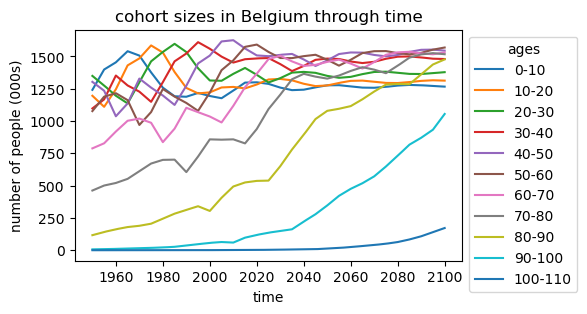

In [105]:
df_cohort_size_sel = da_cohort_size.sel(country='Belgium').drop_vars('country').to_pandas()

j = 10

df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(figsize=(5,3)) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = plt.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])

plt.title('cohort sizes in Belgium through time')
plt.ylabel('number of people (000s)')

figpath='figs/cohortsize_belgium.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)

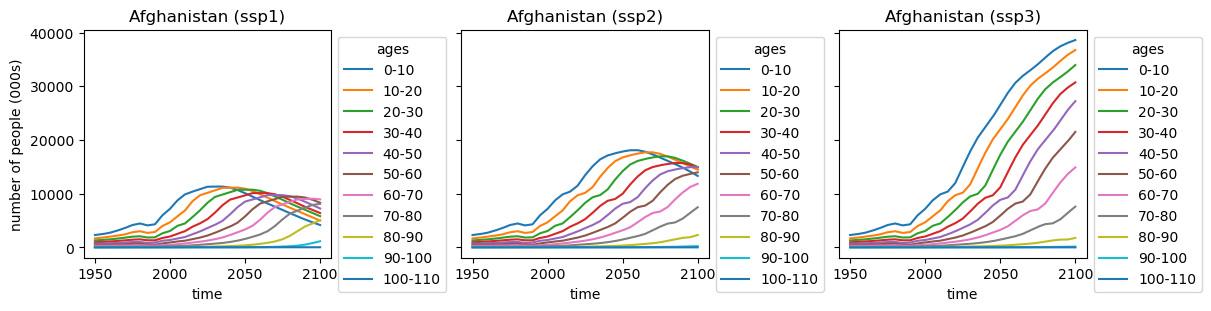

In [37]:
fig, axes = plt.subplots(1,3, figsize=(12,3), layout='constrained',sharey=True)
j = 10

ax=axes[0]
df_cohort_size_sel = da_cohort_size_ssp1.sel(country='Afghanistan').drop_vars('country').to_pandas()
df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(ax=ax) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = ax.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
ax.set_title('Afghanistan (ssp1)');
ax.set_ylabel('number of people (000s)')


ax=axes[1]
df_cohort_size_sel = da_cohort_size.sel(country='Afghanistan').drop_vars('country').to_pandas()
df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(ax=ax) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = ax.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
ax.set_title('Afghanistan (ssp2)');


ax=axes[2]
df_cohort_size_sel = da_cohort_size_ssp3.sel(country='Afghanistan').drop_vars('country').to_pandas()
df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(ax=ax) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = ax.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
ax.set_title('Afghanistan (ssp3)');



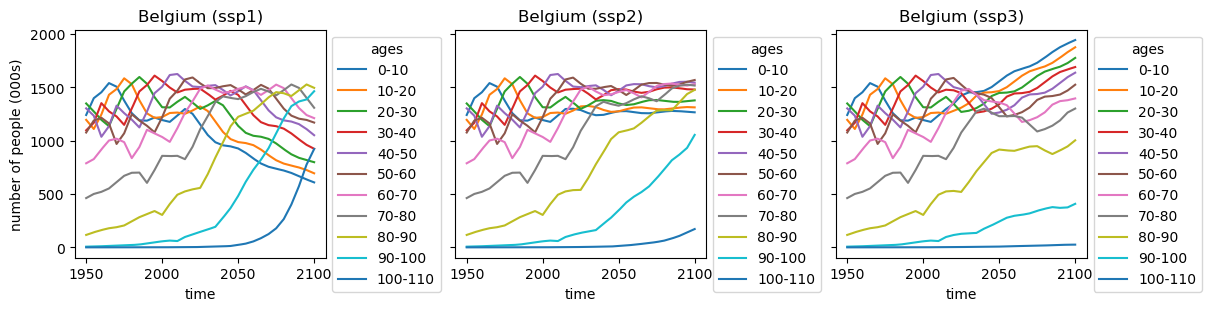

In [22]:
fig, axes = plt.subplots(1,3, figsize=(12,3), layout='constrained',sharey=True)
j = 10

country='Belgium'

ax=axes[0]
df_cohort_size_sel = da_cohort_size_ssp1.sel(country=country).drop_vars('country').to_pandas()
df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(ax=ax) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = ax.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
ax.set_title(f'{country} (ssp1)');
ax.set_ylabel('number of people (000s)')


ax=axes[1]
df_cohort_size_sel = da_cohort_size.sel(country=country).drop_vars('country').to_pandas()
df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(ax=ax) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = ax.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
ax.set_title(f'{country} (ssp2)');


ax=axes[2]
df_cohort_size_sel = da_cohort_size_ssp3.sel(country=country).drop_vars('country').to_pandas()
df_cohort_size_sel.groupby(np.arange(len(df_cohort_size_sel.columns)) // j, axis=1).sum().plot(ax=ax) # group every 5 years together and calc sum and plot 
# Get the current legend
legend = ax.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
ax.set_title(f'{country} (ssp3)');


### develop

In [36]:
df_cohort_sizes

2_1950    2_1955    2_1960    2_1965    2_1970  \
Area                                                                    
Afghanistan            1291.6    1355.1    1539.5    1762.1    2025.6   
Albania                 180.8     222.5     272.9     309.7     312.3   
Algeria                1403.1    1830.6    2081.8    2398.0    2692.6   
Angola                  739.2    1023.5    1095.3    1196.5    1298.7   
Antigua and Barbuda       6.6       8.4       8.9       9.2       9.9   
...                       ...       ...       ...       ...       ...   
Western Sahara            2.4       3.3       5.4       8.7      13.2   
World                338387.2  405612.1  432642.8  480601.0  523700.8   
Yemen                   770.2     777.9     860.3     978.0    1173.4   
Zambia                  423.0     483.3     578.8     698.3     814.8   
Zimbabwe                441.6     614.9     725.0     864.3    1009.7   

                       2_1975    2_1980    2_1985    2_1990    2_1995  ...  \
Area                                                                   ...   
Afghanistan            2326.7    2484.4    2276.9    2377.9    3325.5  ...   
Albania                 324.8     335.2     355.5     388.5     334.4  ...   
Algeria                3086.2    3528.0    3893.8    3994.2    3734.3  ...   
Angola                 1515.1    1810.3    2122.6    2438.5    2799.6  ...   
Antigua and Barbuda       9.3       7.3       7.2       7.4       6.8  ...   
...                       ...       ...       ...       ...       ...  ...   
Western Sahara           13.3      23.0      29.2      31.8      34.6  ...   
World                543302.0  548178.6  592792.3  644867.3  623061.1  ...   
Yemen                  1348.4    1709.7    2115.3    2603.1    3082.0  ...   
Zambia                  979.1    1148.2    1309.8    1480.3    1670.7  ...   
Zimbabwe               1204.2    1430.4    1641.3    1736.2    1780.9  ...   

                     102_2055  102_2060  102_2065  102_2070  102_2075  \
Area                                                                    
Afghanistan               0.2       0.2       0.3       0.4       0.5   
Albania                   3.2       5.5       8.0       9.7      11.8   
Algeria                  15.7      23.0      35.4      52.8      78.8   
Angola                    0.4       0.5       0.6       0.8       1.1   
Antigua and Barbuda       0.0       0.1       0.1       0.1       0.1   
...                       ...       ...       ...       ...       ...   
Western Sahara            0.0       0.0       0.1       0.1       0.2   
World                  5799.9    7789.0   10822.7   14499.7   18443.9   
Yemen                     0.3       0.4       0.5       0.7       1.1   
Zambia                    0.2       0.3       0.4       0.5       0.8   
Zimbabwe                  0.3       0.4       0.5       0.6       0.9   

                     102_2080  102_2085  102_2090  102_2095  102_2100  
Area                                                                   
Afghanistan               0.7       0.9       1.1       1.6       2.4  
Albania                  14.7      19.1      20.3      24.7      35.4  
Algeria                 123.7     179.8     235.8     281.4     297.1  
Angola                    1.5       2.1       3.0       4.2       6.1  
Antigua and Barbuda       0.1       0.2       0.2       0.3       0.3  
...                       ...       ...       ...       ...       ...  
Western Sahara            0.3       0.4       0.5       0.7       0.9  
World                 22134.8   28115.2   36321.0   42244.2   48218.6  
Yemen                     2.1       3.4       5.2       7.8      10.2  
Zambia                    1.0       1.4       1.8       2.4       3.4  
Zimbabwe                  1.4       2.3       3.1       4.2       5.7  

[202 rows x 651 columns]

In [44]:
df_cohort_size_filter = df_countries_matched[['country', 'country_wcde', 'country_iso3']].drop(
    df_countries_matched[df_countries_matched['country_iso3'].isna()].index).merge(
    df_cohort_sizes, how='left', right_index=True, left_on='country_wcde').drop(
    columns=['country_wcde'])

In [46]:
df_cohort_size_filter

country country_iso3  2_1950  2_1955  2_1960  \
0                           Afghanistan          AFG  1291.6  1355.1  1539.5   
1                               Albania          ALB   180.8   222.5   272.9   
2                               Algeria          DZA  1403.1  1830.6  2081.8   
0                               Andorra          AND     NaN     NaN     NaN   
4                                Angola          AGO   739.2  1023.5  1095.3   
..                                  ...          ...     ...     ...     ...   
190  Venezuela (Bolivarian Republic of)          VEN  1021.7  1238.3  1529.8   
191                            Viet Nam          VNM  3088.2  4605.9  5842.2   
192                               Yemen          YEM   770.2   777.9   860.3   
193                              Zambia          ZMB   423.0   483.3   578.8   
194                            Zimbabwe          ZWE   441.6   614.9   725.0   

     2_1965  2_1970  2_1975  2_1980  2_1985  ...  102_2055  102_2060  \
0    1762.1  2025.6  2326.7  2484.4  2276.9  ...       0.2       0.2   
1     309.7   312.3   324.8   335.2   355.5  ...       3.2       5.5   
2    2398.0  2692.6  3086.2  3528.0  3893.8  ...      15.7      23.0   
0       NaN     NaN     NaN     NaN     NaN  ...       NaN       NaN   
4    1196.5  1298.7  1515.1  1810.3  2122.6  ...       0.4       0.5   
..      ...     ...     ...     ...     ...  ...       ...       ...   
190  1895.6  2016.1  2046.9  2288.4  2513.1  ...      43.9      62.1   
191  6571.4  7064.7  7657.6  7991.1  8630.3  ...     192.0     299.3   
192   978.0  1173.4  1348.4  1709.7  2115.3  ...       0.3       0.4   
193   698.3   814.8   979.1  1148.2  1309.8  ...       0.2       0.3   
194   864.3  1009.7  1204.2  1430.4  1641.3  ...       0.3       0.4   

     102_2065  102_2070  102_2075  102_2080  102_2085  102_2090  102_2095  \
0         0.3       0.4       0.5       0.7       0.9       1.1       1.6   
1         8.0       9.7      11.8      14.7      19.1      20.3      24.7   
2        35.4      52.8      78.8     123.7     179.8     235.8     281.4   
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4         0.6       0.8       1.1       1.5       2.1       3.0       4.2   
..        ...       ...       ...       ...       ...       ...       ...   
190      89.1     113.0     133.7     168.9     214.0     271.4     323.2   
191     403.7     510.1     634.9     781.0     982.6    1227.1    1442.4   
192       0.5       0.7       1.1       2.1       3.4       5.2       7.8   
193       0.4       0.5       0.8       1.0       1.4       1.8       2.4   
194       0.5       0.6       0.9       1.4       2.3       3.1       4.2   

     102_2100  
0         2.4  
1        35.4  
2       297.1  
0         NaN  
4         6.1  
..        ...  
190     379.4  
191    1388.8  
192      10.2  
193       3.4  
194       5.7  

[195 rows x 653 columns]

In [48]:
df_cohort_size_filter.iloc[:,2:].values

array([[1.2916e+03, 1.3551e+03, 1.5395e+03, ..., 1.1000e+00, 1.6000e+00,
        2.4000e+00],
       [1.8080e+02, 2.2250e+02, 2.7290e+02, ..., 2.0300e+01, 2.4700e+01,
        3.5400e+01],
       [1.4031e+03, 1.8306e+03, 2.0818e+03, ..., 2.3580e+02, 2.8140e+02,
        2.9710e+02],
       ...,
       [7.7020e+02, 7.7790e+02, 8.6030e+02, ..., 5.2000e+00, 7.8000e+00,
        1.0200e+01],
       [4.2300e+02, 4.8330e+02, 5.7880e+02, ..., 1.8000e+00, 2.4000e+00,
        3.4000e+00],
       [4.4160e+02, 6.1490e+02, 7.2500e+02, ..., 3.1000e+00, 4.2000e+00,
        5.7000e+00]])

In [98]:
# keep 195 countries in isimip list (note that some don't have cohort size data, and some countries
# in unwpp but not in isimip do have cohortsize data). 
df_cohort_size_filter = df_countries_matched[['country', 'country_wcde', 'country_iso3']].drop(
                        df_countries_matched[df_countries_matched['country_iso3'].isna()].index).merge(
                        df_cohort_sizes, how='left', right_index=True, left_on='country_wcde').drop(
                        columns=['country_wcde']).reset_index(drop=True)

df_cohort_size_filter = df_cohort_size_filter.drop(df_cohort_size_filter[df_cohort_size_filter['2_1950'].isna()].index).reset_index(drop=True)

def distribute_error_across_years(df_y_values, df_y_mean_bracket, bracket_size): 
    # for a single year / single country in the dataset distribute error in age bracket
    
    # ignore warnings, we get rid of nans later with the nansum
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        # reshape df to array, each row is a bracket, each column is a specific age in that bracket 
        y_values = np.reshape(df_y_values.values, (len(df_y_values)//bracket_size, bracket_size)) #nrows, ncols
        # calculate interpolation error over the bracket as the sum of errors
        delta_bracket = np.sum(y_values - df_y_mean_bracket.values[:, np.newaxis], axis=1) # sums along row
        # calculate relative weights as the value divided by the sum of all values in the bracket
        sum_over_years = np.sum(y_values, axis=1)
        weights = y_values / sum_over_years[:, np.newaxis]
        # compute correction for each y value
        delta_i = weights * delta_bracket[:, np.newaxis]
        # correct the y values 
        y_corrected = np.nansum(np.dstack((y_values,-delta_i)),2).reshape(-1)
        
    return y_corrected

# unpack loaded wcde values
wcde_years, wcde_ages, wcde_country_data = years, ages, df_cohort_size_filter.iloc[:,2:].values  

# initialise dictionary to store cohort sizes dataframes per country with years as rows and ages as columns
d_cohort_size = {}

# loop over countries
print('interpolating cohort sizes per country')
for i,name in enumerate(df_cohort_size_filter['country']):
    # extract population size per age cohort data from WCDE file and linearly interpolate from 5-year WCDE blocks to pre-defined birth year
    wcde_per_country = np.reshape(wcde_country_data[i,:],((len(wcde_ages),len(wcde_years)))) 
    # every row is an age cohort (len 21), every column is a year (len 31)
    # use dataframes to do reindexing and interpolation (see how much slower this makes it cfr. to numpy - could do with numpy interpolate.griddata if you accept that ages 0-2 are not interpolated but held constant - decide what assumption we want to use!) 
    wcde_per_country_df = pd.DataFrame(
        wcde_per_country,
        index=wcde_ages,
        columns=wcde_years
    )

    #set new coordinates after interpolation - check you want this & put in flags at start or something !! 
    ages_interpn_cohorts =  np.arange(0,105) # ISSUE: understand if OK np.arange(104,-1,-1) #np.arange(100,-1,-1) # new_ages in luke's script (prev: np.arange(0,105))
    years_interpn_cohorts = np.arange(1950,2100+1)

    # interpolate per ages
    wcde_per_country_df = wcde_per_country_df.reindex(ages_interpn_cohorts)
    wcde_per_country_df
    wcde_per_country_intrp = wcde_per_country_df.astype('float').interpolate(
            method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
            limit_direction='both',
            fill_value='extrapolate',
            axis=0
        )
    # set negative numbers to zero
    wcde_per_country_intrp[wcde_per_country_intrp<0]=0
    # fix the not mean preserving issue
    wcde_per_country_intrp_correct = wcde_per_country_intrp.copy()
    for y in wcde_years:
        wcde_per_country_intrp_correct.loc[:,y] = distribute_error_across_years(
            wcde_per_country_intrp.loc[:,y], # interpolated values
            wcde_per_country_df.dropna().loc[:,y], # true mean
            bracket_size=5) # bracket size 
     
    # check for neg numbers
    if (wcde_per_country_intrp_correct < 0).any().any():
        print('after interpolation and mean-preserving correction there are some neg numbers in {}, {}, setting them to zero'.format(i,name))
        # set them to zero
        wcde_per_country_intrp_correct[wcde_per_country_intrp_correct<0]=0
        # TODO: modify distribute_error_across_years to not reintroduce negative numbers 

    # interpolate between years
    wcde_per_country_df = wcde_per_country_intrp_correct.transpose().reindex(years_interpn_cohorts)
    wcde_per_country_intrp_years = wcde_per_country_df.astype('float').interpolate(
            method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
            limit_direction='both',
            fill_value='extrapolate',
            axis=0
        )
    d_cohort_size[name] = wcde_per_country_intrp_years / 5

    #  make a data array with the information from all the countries together
da_cohort_size = xr.DataArray(
    np.asarray([v for k,v in d_cohort_size.items() if k in df_cohort_size_filter['country'].values]), # see whether to include nan countries here
    coords={
        'country': ('country', df_cohort_size_filter['country']),
        'time': ('time', years_interpn_cohorts),
        'ages': ('ages', ages_interpn_cohorts),
    },
    dims=[
        'country',
        'time',
        'ages',
    ],
    name='cohort_size'
)


interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 9, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 131, Papua New Guinea, setting them to zero


In [90]:
da_cohort_size

<xarray.DataArray 'cohort_size' (country: 187, time: 151, ages: 105)>
array([[[2.81368000e+02, 2.69844000e+02, 2.58320000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.83244000e+02, 2.72052000e+02, 2.60860000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.85120000e+02, 2.74260000e+02, 2.63400000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.31485440e+03, 1.32540320e+03, 1.33595200e+03, ...,
         2.02648339e-01, 0.00000000e+00, 0.00000000e+00],
        [1.29708720e+03, 1.30794160e+03, 1.31879600e+03, ...,
         2.21324170e-01, 0.00000000e+00, 0.00000000e+00],
        [1.27932000e+03, 1.29048000e+03, 1.30164000e+03, ...,
         2.40000000e-01, 0.00000000e+00, 0.00000000e+00]],

       [[3.80000000e+01, 3.70800000e+01, 3.61600000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.01112000e+01, 3.89696000e+01, 3.78280000e+01, ...,
         1.20000000e-02, 6.40000000e-03, 8.00000000e-04],
        [4.22224000e+01, 4.08592000e+01, 3.94960000e+01, ...,
         2.40000000e-02, 1.28000000e-02, 1.60000000e-03],
...
        [6.31817600e+02, 6.36504800e+02, 6.41192000e+02, ...,
         3.72662580e-01, 0.00000000e+00, 0.00000000e+00],
        [6.25712800e+02, 6.30494400e+02, 6.35276000e+02, ...,
         4.01361052e-01, 0.00000000e+00, 0.00000000e+00],
        [6.19608000e+02, 6.24484000e+02, 6.29360000e+02, ...,
         4.30059524e-01, 0.00000000e+00, 0.00000000e+00]],

       [[9.24800000e+01, 9.04000000e+01, 8.83200000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.01888800e+02, 9.85704000e+01, 9.52520000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.11297600e+02, 1.06740800e+02, 1.02184000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.30172000e+02, 2.32244000e+02, 2.34316000e+02, ...,
         7.49049973e-01, 0.00000000e+00, 0.00000000e+00],
        [2.27352000e+02, 2.29400000e+02, 2.31448000e+02, ...,
         7.96253958e-01, 0.00000000e+00, 0.00000000e+00],
        [2.24532000e+02, 2.26556000e+02, 2.28580000e+02, ...,
         8.43457944e-01, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * country  (country) object 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [95]:
df_cohort_size_filter = df_countries_matched[['country', 'country_wcde', 'country_iso3']].drop(
                        df_countries_matched[df_countries_matched['country_iso3'].isna()].index).merge(
                        df_cohort_sizes, how='left', right_index=True, left_on='country_wcde').drop(
                        columns=['country_wcde']).reset_index(drop=True)


df_cohort_size_filter

country country_iso3  2_1950  2_1955  2_1960  \
0                           Afghanistan          AFG  1291.6  1355.1  1539.5   
1                               Albania          ALB   180.8   222.5   272.9   
2                               Algeria          DZA  1403.1  1830.6  2081.8   
3                               Andorra          AND     NaN     NaN     NaN   
4                                Angola          AGO   739.2  1023.5  1095.3   
..                                  ...          ...     ...     ...     ...   
190  Venezuela (Bolivarian Republic of)          VEN  1021.7  1238.3  1529.8   
191                            Viet Nam          VNM  3088.2  4605.9  5842.2   
192                               Yemen          YEM   770.2   777.9   860.3   
193                              Zambia          ZMB   423.0   483.3   578.8   
194                            Zimbabwe          ZWE   441.6   614.9   725.0   

     2_1965  2_1970  2_1975  2_1980  2_1985  ...  102_2055  102_2060  \
0    1762.1  2025.6  2326.7  2484.4  2276.9  ...       0.2       0.2   
1     309.7   312.3   324.8   335.2   355.5  ...       3.2       5.5   
2    2398.0  2692.6  3086.2  3528.0  3893.8  ...      15.7      23.0   
3       NaN     NaN     NaN     NaN     NaN  ...       NaN       NaN   
4    1196.5  1298.7  1515.1  1810.3  2122.6  ...       0.4       0.5   
..      ...     ...     ...     ...     ...  ...       ...       ...   
190  1895.6  2016.1  2046.9  2288.4  2513.1  ...      43.9      62.1   
191  6571.4  7064.7  7657.6  7991.1  8630.3  ...     192.0     299.3   
192   978.0  1173.4  1348.4  1709.7  2115.3  ...       0.3       0.4   
193   698.3   814.8   979.1  1148.2  1309.8  ...       0.2       0.3   
194   864.3  1009.7  1204.2  1430.4  1641.3  ...       0.3       0.4   

     102_2065  102_2070  102_2075  102_2080  102_2085  102_2090  102_2095  \
0         0.3       0.4       0.5       0.7       0.9       1.1       1.6   
1         8.0       9.7      11.8      14.7      19.1      20.3      24.7   
2        35.4      52.8      78.8     123.7     179.8     235.8     281.4   
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4         0.6       0.8       1.1       1.5       2.1       3.0       4.2   
..        ...       ...       ...       ...       ...       ...       ...   
190      89.1     113.0     133.7     168.9     214.0     271.4     323.2   
191     403.7     510.1     634.9     781.0     982.6    1227.1    1442.4   
192       0.5       0.7       1.1       2.1       3.4       5.2       7.8   
193       0.4       0.5       0.8       1.0       1.4       1.8       2.4   
194       0.5       0.6       0.9       1.4       2.3       3.1       4.2   

     102_2100  
0         2.4  
1        35.4  
2       297.1  
3         NaN  
4         6.1  
..        ...  
190     379.4  
191    1388.8  
192      10.2  
193       3.4  
194       5.7  

[195 rows x 653 columns]

In [97]:
df_cohort_size_filter[df_cohort_size_filter['2_1950'].isna()]

country country_iso3  2_1950  2_1955  2_1960  2_1965  \
3                  Andorra          AND     NaN     NaN     NaN     NaN   
100          Liechtenstein          LIE     NaN     NaN     NaN     NaN   
115                 Monaco          MCO     NaN     NaN     NaN     NaN   
122                  Nauru          NRU     NaN     NaN     NaN     NaN   
133                  Palau          PLW     NaN     NaN     NaN     NaN   
146  Saint Kitts and Nevis          KNA     NaN     NaN     NaN     NaN   
150             San Marino          SMR     NaN     NaN     NaN     NaN   
181                 Tuvalu          TUV     NaN     NaN     NaN     NaN   

     2_1970  2_1975  2_1980  2_1985  ...  102_2055  102_2060  102_2065  \
3       NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
100     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
115     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
122     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
133     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
146     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
150     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   
181     NaN     NaN     NaN     NaN  ...       NaN       NaN       NaN   

     102_2070  102_2075  102_2080  102_2085  102_2090  102_2095  102_2100  
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
100       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
115       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
122       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
133       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
146       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
150       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
181       NaN       NaN       NaN       NaN       NaN       NaN       NaN  

[8 rows x 653 columns]

In [94]:
df_cohort_size_filter = df_cohort_size_filter.drop(df_cohort_size_filter[df_cohort_size_filter['2_1950'].isna()].index).reset_index(drop=True)


### develop 2

differnce wim/luke's list and mine

In [103]:
countries_original = ['Aruba', 'Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bolivia', 'Brazil',
       'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China',
       'Côte d\\Ivoire', 'Cameroon', 'Democratic Republic of the Congo',
       'Republic of Congo', 'Colombia', 'Comoros', 'Cape Verde', 'Costa Rica',
       'Cuba', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Eritrea', 'Spain',
       'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France',
       'Federated States of Micronesia', 'Gabon', 'United Kingdom', 'Georgia',
       'Ghana', 'Guinea', 'The Gambia', 'Guinea-Bissau', 'Equatorial Guinea',
       'Greece', 'Grenada', 'Guatemala', 'Guam', 'Guyana', 'Hong Kong',
       'Honduras', 'Croatia', 'Haiti', 'Hungary', 'Indonesia', 'India',
       'Ireland', 'Iran', 'Iraq', 'Iceland', 'Israel', 'Italy', 'Jamaica',
       'Jordan', 'Japan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Cambodia',
       'Kiribati', 'Republic of Korea', 'Kuwait', 'Lao PDR', 'Lebanon',
       'Liberia', 'Libya', 'Saint Lucia', 'Sri Lanka', 'Lesotho', 'Lithuania',
       'Luxembourg', 'Latvia', 'Macao', 'Morocco', 'Moldova', 'Madagascar',
       'Maldives', 'Mexico', 'Macedonia', 'Mali', 'Malta', 'Myanmar',
       'Montenegro', 'Mongolia', 'Mozambique', 'Mauritania', 'Mauritius',
       'Malawi', 'Malaysia', 'Namibia', 'New Caledonia', 'Niger', 'Nigeria',
       'Nicaragua', 'Netherlands', 'Norway', 'Nepal', 'New Zealand', 'Oman',
       'Pakistan', 'Panama', 'Peru', 'Philippines', 'Papua New Guinea',
       'Poland', 'Puerto Rico', 'Dem. Rep. Korea', 'Portugal', 'Paraguay',
       'Palestine', 'French Polynesia', 'Qatar', 'Romania',
       'Russian Federation', 'Rwanda', 'Saudi Arabia', 'Sudan', 'Senegal',
       'Singapore', 'Solomon Islands', 'Sierra Leone', 'El Salvador',
       'Somalia', 'Serbia', 'South Sudan', 'São Tomé and Principe', 'Suriname',
       'Slovakia', 'Slovenia', 'Sweden', 'Swaziland', 'Syria', 'Chad', 'Togo',
       'Thailand', 'Tajikistan', 'Turkmenistan', 'Timor-Leste', 'Tonga',
       'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Tanzania', 'Uganda',
       'Ukraine', 'Uruguay', 'United States', 'Uzbekistan',
       'Saint Vincent and the Grenadines', 'Venezuela',
       'United States Virgin Islands', 'Vietnam', 'Vanuatu', 'Samoa', 'Yemen',
       'South Africa', 'Zambia', 'Zimbabwe']

In [106]:
countries_new = da_cohort_size.country.values
countries_new

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo',
       'Congo (Democratic Republic of the)', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini (Kingdom of)', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada'

In [108]:
set(countries_original).difference(countries_new)

{'Aruba',
 'Bolivia',
 'Cape Verde',
 'Czech Republic',
 'Côte d\\Ivoire',
 'Dem. Rep. Korea',
 'Democratic Republic of the Congo',
 'Federated States of Micronesia',
 'French Polynesia',
 'Guam',
 'Hong Kong',
 'Iran',
 'Lao PDR',
 'Macao',
 'Macedonia',
 'Moldova',
 'New Caledonia',
 'Palestine',
 'Puerto Rico',
 'Republic of Congo',
 'Republic of Korea',
 'Swaziland',
 'Syria',
 'São Tomé and Principe',
 'Tanzania',
 'The Gambia',
 'United States Virgin Islands',
 'Venezuela',
 'Vietnam'}

In [110]:
set(countries_new).difference(countries_original)

{'Bolivia (Plurinational State of)',
 'Cabo Verde',
 'Congo',
 'Congo (Democratic Republic of the)',
 'Czechia',
 "Côte d'Ivoire",
 'Dominica',
 'Eswatini (Kingdom of)',
 'Gambia',
 'Hong Kong, China (SAR)',
 'Iran (Islamic Republic of)',
 "Korea (Democratic People's Rep. of)",
 'Korea (Republic of)',
 "Lao People's Democratic Republic",
 'Marshall Islands',
 'Micronesia (Federated States of)',
 'Moldova (Republic of)',
 'North Macedonia',
 'Palestine, State of',
 'Sao Tome and Principe',
 'Seychelles',
 'Syrian Arab Republic',
 'Tanzania (United Republic of)',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam'}

## 6. load_gridded_pop()

In [108]:
def load_population(
    dir_population=['./data-new/gridded-pop/ISIMIP3/ISIMIP3b/',
                     '.data/isimip/population/'], # ISIMIP2ab, rename this ! 
    isimip_round=3,
    startyear=1850,
    endyear=2100,
    ssp=3,
):
    """load gridded population reconstructions (histsoc) + projections (SSP) from ISIMIP

    Gridded population density at 0.5 degrees, annual 1861-2005 (histsoc) and 2006-2100 (SPP), expressed as number of people, concatenated

    To do:
    - isimip3a can also open hist until 2021
    - isimip3b can i ask for ssp2? 
    - isimip2b other ssps are also available
    
    Input:
        nc4 files histsoc and SSP2 
    
    Returns:
        da_population: (DataArray)  gridded population density per 0.5 degree spatial resolution, annual temporal resolution
    """

    if isimip_round ==3:
        # load 2D data
        da_pop_histsoc1 = xr.open_dataset(os.path.join(dir_population[0],'histsoc/population_histsoc_30arcmin_annual_1850_1900.nc'))['total-population'] 
        da_pop_histsoc2 = xr.open_dataset(os.path.join(dir_population[0],'histsoc/population_histsoc_30arcmin_annual_1901_2014.nc'))['total-population']     
        if ssp==2:
            print('error ssp2 population data not provided in ISIMIP3b')
        else:
            print(f'opening ssp{ssp}')
            da_pop_sspsoc = xr.open_dataset(glob.glob(os.path.join(dir_population[0],f'ssp{ssp}*/population_ssp{ssp}_30arcmin_annual_2015_2100.nc'))[0],  decode_times=False)['total-population'] 
            da_pop_sspsoc['time'] = np.array([np.datetime64(f'{year}-01-01T12:00:00', 'ns') for year in np.arange(2015,2101)]) 
            #  concatenate historical and future data
            da_population = xr.concat([da_pop_histsoc1, da_pop_histsoc2, da_pop_sspsoc], dim='time') 

            # years = da_population.time.dt.year.values
            # da_population['time'] = years


    elif isimip_round==2:
        print('isimip2 data opening with ssp2')
        # load 2D data
        da_pop_histsoc = xr.open_dataset('./data/isimip/population/population_histsoc_0p5deg_annual_1861-2005.nc4', decode_times=False)['number_of_people'] 
        da_pop_ssp2soc = xr.open_dataset('./data/isimip/population/population_ssp2soc_0p5deg_annual_2006-2100.nc4', decode_times=False)['number_of_people'] 
        # manually adjust time dimension in both data arrays (because original times could not be decoded)
        da_pop_histsoc['time'] = np.arange(1861,2006)
        da_pop_ssp2soc['time'] = np.arange(2006,2101)
        # concatenate historical and future data
        da_population = xr.concat([da_population_histsoc, da_population_ssp2soc], dim='time') 

        
    # if needed, repeat last year until entire period of interest is covered
    if np.nanmax(da_population.time.dt.year) < endyear:
        population_10y_mean = da_population.loc[-10:,:,:].mean(dim='time').expand_dims(dim='time',axis=0) # repeat average of last 10 years (i.e. end-9 to end ==> 2090:2099)
        for year in range(np.nanmax(da_population.time)+1,year_end+1): 
            da_population = xr.concat([da_population,population_10y_mean.assign_coords(time = [year])], dim='time')

    da_population = da_population.sel(time=slice(f'{startyear}-01-01',f'{endyear}-01-01'))
    da_population['time'] = da_population.time.dt.year.values
    
    return da_population # fix this year formatting stuff !!! 

In [112]:
da_population = load_population(ssp=3, isimip_round=3, startyear=1950,endyear=2000)

opening ssp3


In [113]:
da_population

<xarray.DataArray 'total-population' (time: 51, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) int64 1950 1951 1952 1953 1954 ... 1996 1997 1998 1999 2000
Attributes:
    units:          1
    standard_name:  total population

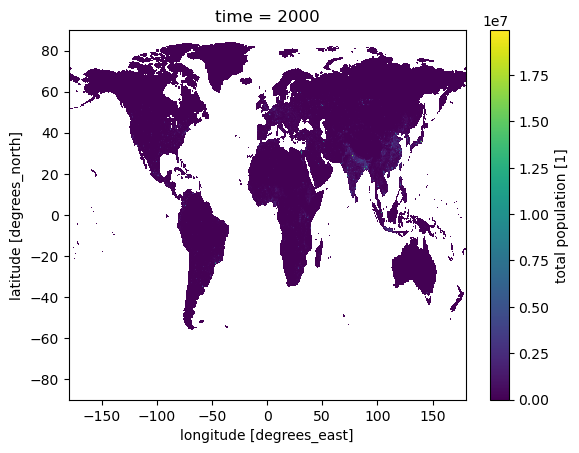

In [114]:
da_population.sel(time=2000).plot()

### develop

In [194]:
dir_population='./data-new/gridded-pop/ISIMIP3/ISIMIP3b/'

ds_pop_histsoc1 = xr.open_dataset(os.path.join(dir_population,'histsoc/population_histsoc_30arcmin_annual_1850_1900.nc'))


In [195]:
ds_pop_histsoc1

<xarray.Dataset>
Dimensions:           (lat: 360, lon: 720, time: 51)
Coordinates:
  * lat               (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon               (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time              (time) datetime64[ns] 1850-01-01T12:00:00 ... 1900-01-0...
Data variables:
    rural-population  (time, lat, lon) float32 ...
    total-population  (time, lat, lon) float32 ...
    urban-population  (time, lat, lon) float32 ...
Attributes:
    summary:     HYDE v3.3 population data linearly interpolated in time for ...
    references:  Klein Goldewijk et al. (2022), in preparation
    title:       ISIMIP3a population data
    contact:     "ISIMIP cross-sectoral science team" <info@isimip.org>

In [198]:
pop_histsoc1 = ds_pop_histsoc1['total-population'] 
pop_histsoc1

<xarray.DataArray 'total-population' (time: 51, lat: 360, lon: 720)>
[13219200 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 1900-01-01T12:00:00
Attributes:
    units:          1
    standard_name:  total population

In [199]:
ds = xr.open_dataset(os.path.join(dir_population,'histsoc/population_histsoc_30arcmin_annual_1901_2014.nc'))
ds

<xarray.Dataset>
Dimensions:           (lat: 360, lon: 720, time: 114)
Coordinates:
  * lat               (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon               (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time              (time) datetime64[ns] 1901-01-01T12:00:00 ... 2014-01-0...
Data variables:
    rural-population  (time, lat, lon) float32 ...
    total-population  (time, lat, lon) float32 ...
    urban-population  (time, lat, lon) float32 ...
Attributes:
    summary:     HYDE v3.3 population data linearly interpolated in time for ...
    references:  Klein Goldewijk et al. (2022), in preparation
    title:       ISIMIP3a population data
    contact:     "ISIMIP cross-sectoral science team" <info@isimip.org>

In [201]:
glob.glob(os.path.join(dir_population,'ssp1*/population_ssp1_30arcmin_annual_2015_2100.nc'))

['./data-new/gridded-pop/ISIMIP3/ISIMIP3b/ssp126soc-noadapt/population_ssp1_30arcmin_annual_2015_2100.nc']

In [218]:
ssp=1
xr.open_dataset(glob.glob(os.path.join(dir_population,f'ssp{ssp}*/population_ssp{ssp}_30arcmin_annual_2015_2100.nc'))[0],decode_times=False)

<xarray.Dataset>
Dimensions:           (lat: 360, lon: 720, time: 86)
Coordinates:
  * lat               (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon               (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time              (time) float64 0.0 1.0 2.0 3.0 4.0 ... 82.0 83.0 84.0 85.0
Data variables:
    rural-population  (time, lat, lon) float32 ...
    total-population  (time, lat, lon) float32 ...
    urban-population  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    summary:      ISIMIP3b gridded population for SSP1, the years 2015 to 202...
    references:   https://doi.org/10.5065/D60Z721H. AND https://doi.org/10.79...
    title:        ISIMIP3b gridded population for SSP1
    contact:      "ISIMIP cross-sectoral science team" <info@isimip.org>
    isimip_id:    f32149fc-5c25-4b35-ad4c-ef6414343ce5

In [213]:
os.path.join(dir_population,f'ssp{ssp}*/population_ssp{ssp}_30arcmin_annual_2015_2100.nc')

'./data-new/gridded-pop/ISIMIP3/ISIMIP3b/ssp2*/population_ssp2_30arcmin_annual_2015_2100.nc'

In [215]:
glob.glob(os.path.join(dir_population,f'ssp{ssp}*/population_ssp{ssp}_30arcmin_annual_2015_2100.nc'))

[]

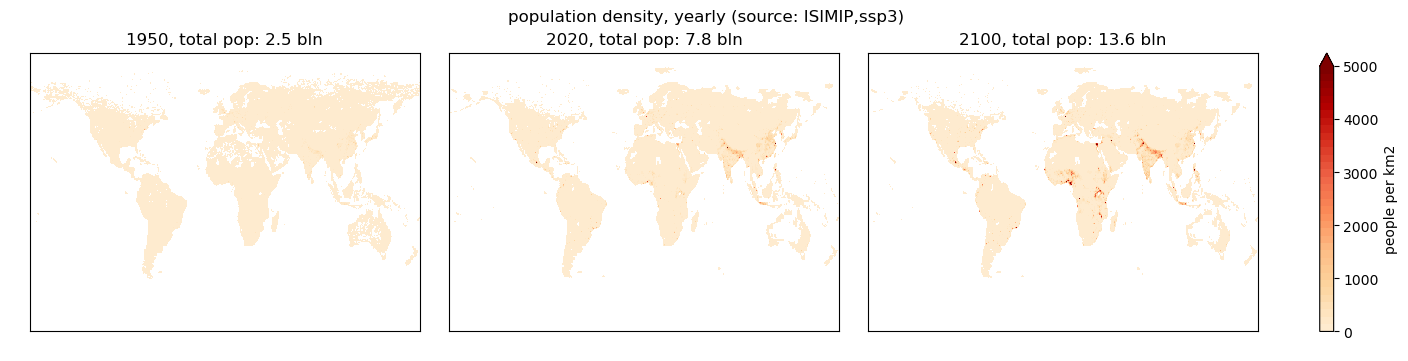

In [262]:
import matplotlib        as mpl

cmap = mpl.cm.OrRd(np.linspace(0,1,40))
cmap = mpl.colors.ListedColormap(cmap[4:,:-1])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,3.5), layout='constrained')

im = (da_population/3025).where(da_population).sel(time=1950).plot(cmap=cmap, vmin=0, vmax=5000, add_colorbar=False, ax=ax1)
tpop = da_population.where(da_population).sel(time=1950).sum() / 1e9
ax1.set_title(f'1950, total pop: {tpop:.1f} bln')

im = (da_population/3025).where(da_population).sel(time=2020).plot(cmap=cmap, vmin=0, vmax=5000,  add_colorbar=False, ax=ax2)
tpop = da_population.where(da_population).sel(time=2020).sum() / 1e9
ax2.set_title(f'2020, total pop: {tpop:.1f} bln')

im = (da_population/3025).where(da_population).sel(time=2100).plot(cmap=cmap, vmin=0, vmax=5000, add_colorbar=False, ax=ax3)
tpop = da_population.where(da_population).sel(time=2100).sum() / 1e9
ax3.set_title(f'2100, total pop: {tpop:.1f} bln')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")
    ax.set_xticks([])
    ax.set_yticks([])
    
cbar = f.colorbar(im, extend='max', use_gridspec=True, ax=[ax1,ax2,ax3],  label='people per km2') #ax=[ax1,ax2,ax3], location='bottom'
plt.suptitle('population density, yearly (source: ISIMIP,ssp3)')
# cbar_kwargs={'label': 'people per km2 (approx)'}

figpath='figs/gridded_population_1950_2020_2100.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)

In [37]:
xr.open_dataset('./data-new/gridded-pop/ISIMIP2/population_histsoc_0p5deg_annual_1861-2005.nc4',decode_times=False)

<xarray.Dataset>
Dimensions:           (lon: 720, lat: 360, time: 145)
Coordinates:
  * lon               (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat               (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time              (time) float64 1.0 2.0 3.0 4.0 ... 142.0 143.0 144.0 145.0
Data variables:
    number_of_people  (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.7.2 (http://m...
    Conventions:               CF-1.4
    NCO:                       20161020
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.7.2 (http://m...

In [38]:
xr.open_dataset('./data-new/gridded-pop/ISIMIP2/population_ssp2soc_0p5deg_annual_2006-2100.nc4',decode_times=False)

<xarray.Dataset>
Dimensions:           (lon: 720, lat: 360, time: 95)
Coordinates:
  * lon               (lon) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat               (lat) float32 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time              (time) float64 345.0 346.0 347.0 ... 437.0 438.0 439.0
Data variables:
    number_of_people  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.8.0 (http://mpimet.mpg.de/...
    comment:      produced with conservative remapping (cdo -remapcon ...)
    contact:      info@isimip.org
    institution:  Potsdam Institute for Climate Impact Research

## 7. load_countrymasks()

In [21]:
def load_countrymasks_fillcoasts(
    filepath='./data-new/country-masks/isipedia-countries/countrymasks_fractional.nc',
    fillcoast=True):

    # Part 1. Open data 
    
    ds=xr.open_dataset(filepath)
    da_countrymasks = ds.to_array()

    strings = da_countrymasks['variable'].values
    cleaned_strings = [s[2:] if s.startswith('m_') else s for s in strings]
    da_countrymasks['variable'] = cleaned_strings
    # last variable is 'world', lose it 
    da_countrymasks = da_countrymasks.isel(variable=slice(0,225))
    # sum over all countries 
    countrymask_sum = da_countrymasks.isel(variable=slice(0,225)).sum(dim='variable')

    # Part 2. Correct for coastal pixels where sum of mask is not 1 
    if fillcoast:
        # where sum of fraction is less than 1, weighted multiplication for sum to equal one
        da_countrymasks_correct = xr.where(countrymask_sum < 1, da_countrymasks*(1/da_countrymasks.sum(dim='variable')), da_countrymasks)
        # small area sum = 2, correct for it 
        da_countrymasks_correct_corr = xr.where(da_countrymasks_correct.sum(dim='variable') > 1, da_countrymasks_correct/da_countrymasks_correct.sum(dim='variable'), da_countrymasks_correct)
    
        return da_countrymasks_correct_corr
    else:
        return da_countrymasks

In [22]:
da_countrymasks = load_countrymasks_fillcoasts()

In [23]:
da_countrymasks

<xarray.DataArray (lat: 360, lon: 720, variable: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * variable  (variable) <U5 'AFG' 'AGO' 'ALB' 'AND' ... 'YEM' 'ZAF' 'ZMB' 'ZWE'

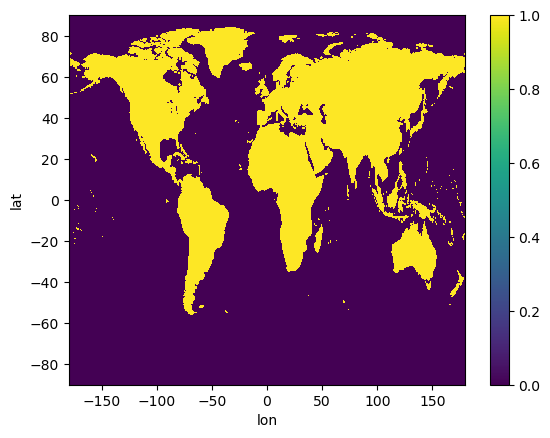

In [102]:
da_countrymasks.sum(dim='variable').plot()

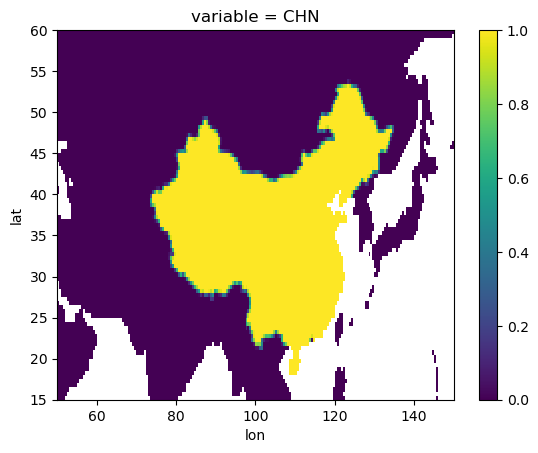

In [103]:
da_countrymasks.sel(variable='CHN').sel(lat=slice(60,15),lon=slice(50,150)).plot()

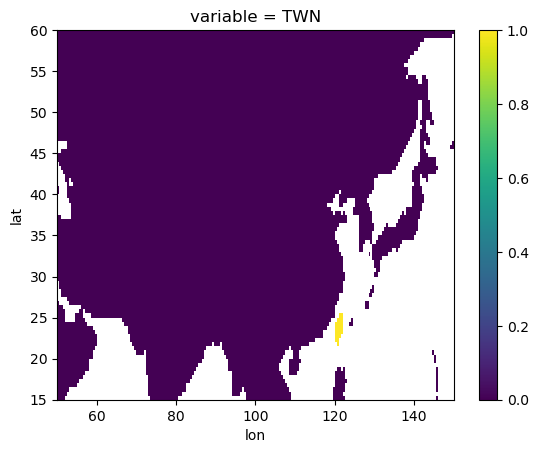

In [104]:
da_countrymasks.sel(variable='TWN').sel(lat=slice(60,15),lon=slice(50,150)).plot()

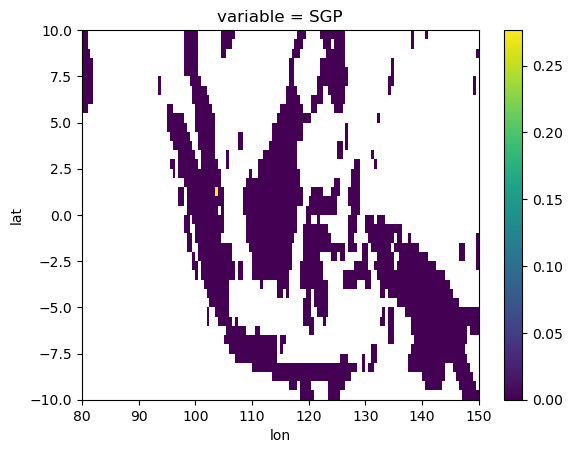

In [105]:
da_countrymasks.sel(variable='SGP').sel(lat=slice(10,-10),lon=slice(80,150)).plot()

In [106]:
da_countrymasks.sel(variable='SGP').argmax(...)

{'lat': <xarray.DataArray ()>
 array(177)
 Coordinates:
     variable  <U5 'SGP',
 'lon': <xarray.DataArray ()>
 array(567)
 Coordinates:
     variable  <U5 'SGP'}

In [107]:
df = da_countrymasks.isel(lat=177,lon=567).to_pandas()
df[df != 0]


variable
IDN      0.067024
IOSID    0.276475
MYS      0.380027
SGP      0.276475
dtype: float32

In [78]:
#da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='IOSID')] = 0


In [80]:
da_countrymasks.isel(lat=177,lon=567).sel(variable='IOSID')

<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    lon       float64 103.8
    lat       float64 1.25
    variable  <U5 'IOSID'

In [68]:
df[df != 0].sum()

0.99999994

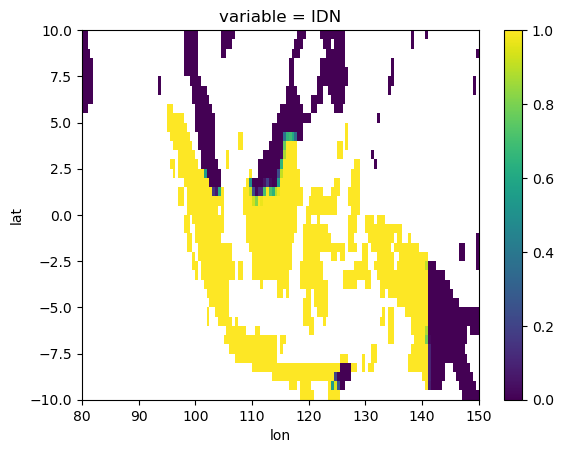

In [52]:
da_countrymasks.sel(variable='IDN').sel(lat=slice(10,-10),lon=slice(80,150)).plot()

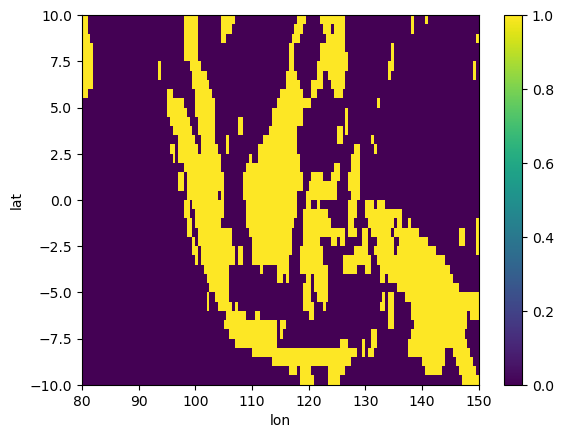

In [53]:
da_countrymasks.sum(dim='variable').sel(lat=slice(10,-10),lon=slice(80,150)).plot()

In [54]:
da_countrymasks['variable'].values

array(['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATF',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD',
       'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CSID',
       'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK',
       'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO',
       'GHA', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL',
       'GTM', 'GUF', 'GUM', 'GUY', 'HKG', 'HMD', 'HND', 'HRV', 'HTI',
       'HUN', 'IDN', 'IMN', 'IND', 'IOSID', 'IRL', 'IRN', 'IRQ', 'ISL',
       'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM',
       'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA',
       'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MDV',
       'MEX', 'MH

In [55]:
len(da_countrymasks['variable'].values)

225

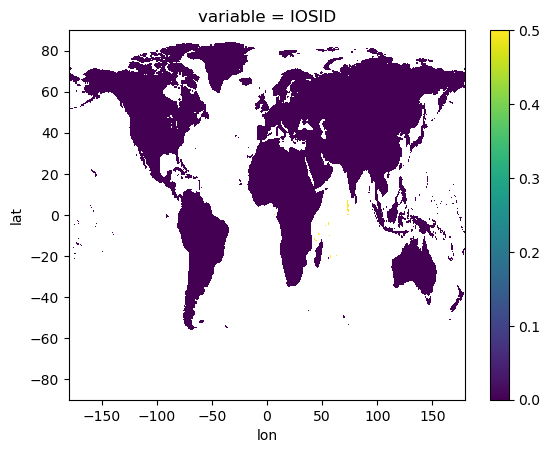

In [70]:
da_countrymasks.sel(variable='IOSID').plot()

In [72]:
filepath='./data-new/country-masks/isipedia-countries/countrymasks_fractional.nc'
ds=xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables: (12/226)
    m_AFG    (lat, lon) float32 ...
    m_AGO    (lat, lon) float32 ...
    m_ALB    (lat, lon) float32 ...
    m_AND    (lat, lon) float32 ...
    m_ARE    (lat, lon) float32 ...
    m_ARG    (lat, lon) float32 ...
    ...       ...
    m_WSM    (lat, lon) float32 ...
    m_YEM    (lat, lon) float32 ...
    m_ZAF    (lat, lon) float32 ...
    m_ZMB    (lat, lon) float32 ...
    m_ZWE    (lat, lon) float32 ...
    m_world  (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    source:       ASAP-GAUL, Natural Earth 10m v5.0.1
    repository:   https://github.com/ISI-MIP/isipedia-countries
    version:      v2.6
    note:         Fractional mask
    isimip_id:    b4bd2422-7e6e-4278-8dca-eb34ba730da2
    CDO:          Climate Data Operators version 1.8.0 (http://mpimet.mpg.de/...

### check extra territories that are not in 195 countries 

In [136]:
import geopandas as gpd
mask = gpd.read_file('./data-new/country-masks/isipedia-countries/countrymasks.geojson')

In [140]:
mask.iloc[:,1:-1]

asap0_id                                      name0       name0_shr  \
0           1                                      Chile           Chile   
1         141                               South Africa    South Africa   
2         212                                       Chad            Chad   
3          63                                     Mexico          Mexico   
4         106  The former Yugoslav Republic of Macedonia   FYR Macedonia   
..        ...                                        ...             ...   
203        18                             Cayman Islands  Cayman Islands   
204        36                                Isle of Man     Isle of Man   
205        83                                    Ecuador         Ecuador   
206       178                                   Paraguay        Paraguay   
207        11           Saint Vincent and the Grenadines   Saint Vincent   

    asap_cntry an_crop an_range    km2_tot  km2_crop  km2_rang2  g1_units  \
0            f       t        t   734524.0   31491.0   113732.0        15   
1            t       t        t  1220071.0  139489.0   846528.0         9   
2            t       t        t  1264760.0   82759.0   246155.0        28   
3            f       t        t  1956179.0  393865.0   293782.0        32   
4            f       t        t    25424.0    7250.0    10826.0         1   
..         ...     ...      ...        ...       ...        ...       ...   
203          f       f        f      200.0       0.0       46.0         1   
204          f       f        f      564.0      66.0      516.0         1   
205          t       t        t   255037.0   35932.0    36596.0        25   
206          f       t        t   399367.0   80032.0    20908.0        17   
207          f       f        f      345.0       0.0       16.0         1   

    isocode ISIPEDIA                           note  \
0        CL      CHL                           None   
1        ZA      ZAF                           None   
2        TD      TCD                           None   
3        MX      MEX                           None   
4        MK      MKD                           None   
..      ...      ...                            ...   
203      KY      CYM  Updated from NaturalEarth 10m   
204      IM      IMN                           None   
205      EC      ECU                           None   
206      PY      PRY                           None   
207    None      VCT  Updated from NaturalEarth 10m   

                                          NAME  
0                                        Chile  
1                                 South Africa  
2                                         Chad  
3                                       Mexico  
4    The former Yugoslav Republic of Macedonia  
..                                         ...  
203                             Cayman Islands  
204                                Isle of Man  
205                                    Ecuador  
206                                   Paraguay  
207           Saint Vincent and the Grenadines  

[208 rows x 14 columns]

In [141]:
#mask.iloc[:,1:-1].to_csv('output/geojson_countrymask.csv')

In [178]:
mask_sel = mask.iloc[:,[12,14]]
mask_sel

ISIPEDIA                                       NAME
0        CHL                                      Chile
1        ZAF                               South Africa
2        TCD                                       Chad
3        MEX                                     Mexico
4        MKD  The former Yugoslav Republic of Macedonia
..       ...                                        ...
203      CYM                             Cayman Islands
204      IMN                                Isle of Man
205      ECU                                    Ecuador
206      PRY                                   Paraguay
207      VCT           Saint Vincent and the Grenadines

[208 rows x 2 columns]

In [179]:
df_countries_matched

country   country_wb                  country_wcde country_iso3  \
0    Afghanistan  Afghanistan                   Afghanistan          AFG   
1        Albania      Albania                       Albania          ALB   
2        Algeria      Algeria                       Algeria          DZA   
0        Andorra      Andorra                          None          AND   
4         Angola       Angola                        Angola          AGO   
..           ...          ...                           ...          ...   
218          NaN          NaN                     Swaziland          NaN   
219          NaN          NaN      Taiwan Province of China          NaN   
223          NaN          NaN  United States Virgin Islands          NaN   
225          NaN          NaN                Western Sahara          NaN   
226          NaN          NaN                         World          NaN   

     country_code                      region         income_group  
0             3.0                  South Asia           Low income  
1           103.0       Europe & Central Asia  Upper middle income  
2           203.0  Middle East & North Africa  Upper middle income  
0           403.0       Europe & Central Asia          High income  
4           503.0          Sub-Saharan Africa  Lower middle income  
..            ...                         ...                  ...  
218           NaN                         NaN                  NaN  
219           NaN                         NaN                  NaN  
223           NaN                         NaN                  NaN  
225           NaN                         NaN                  NaN  
226           NaN                         NaN                  NaN  

[212 rows x 7 columns]

In [180]:
df_merged = df_countries_matched.merge(mask_sel,how='outer', left_on='country_iso3', right_on='ISIPEDIA', indicator=True).sort_values('_merge',ascending=False)
#df_merged.to_csv('output/merged_test.csv')
df_merged

country   country_wb                                  country_wcde  \
0    Afghanistan  Afghanistan                                   Afghanistan   
132     Pakistan     Pakistan                                      Pakistan   
123        Nepal        Nepal                                         Nepal   
124  Netherlands  Netherlands                                   Netherlands   
125  New Zealand  New Zealand                                   New Zealand   
..           ...          ...                                           ...   
204          NaN          NaN                                 New Caledonia   
205          NaN          NaN                                   Puerto Rico   
206          NaN          NaN                                       Reunion   
207          NaN          NaN                                     Swaziland   
201          NaN          NaN  Macao Special Administrative Region of China   

    country_iso3  country_code                 region         income_group  \
0            AFG           3.0             South Asia           Low income   
132          PAK       15803.0             South Asia  Lower middle income   
123          NPL       14403.0             South Asia  Lower middle income   
124          NLD       14503.0  Europe & Central Asia          High income   
125          NZL       14803.0    East Asia & Pacific          High income   
..           ...           ...                    ...                  ...   
204          NaN           NaN                    NaN                  NaN   
205          NaN           NaN                    NaN                  NaN   
206          NaN           NaN                    NaN                  NaN   
207          NaN           NaN                    NaN                  NaN   
201          NaN           NaN                    NaN                  NaN   

    ISIPEDIA         NAME     _merge  
0        AFG  Afghanistan       both  
132      PAK     Pakistan       both  
123      NPL        Nepal       both  
124      NLD  Netherlands       both  
125      NZL  New Zealand       both  
..       ...          ...        ...  
204      NaN          NaN  left_only  
205      NaN          NaN  left_only  
206      NaN          NaN  left_only  
207      NaN          NaN  left_only  
201      NaN          NaN  left_only  

[235 rows x 10 columns]

In [181]:
remaining_countrymasks =  df_merged.query("`_merge` == 'right_only'")
remaining_countrymasks

country country_wb country_wcde country_iso3  country_code region  \
219     NaN        NaN          NaN          NaN           NaN    NaN   
220     NaN        NaN          NaN          NaN           NaN    NaN   
218     NaN        NaN          NaN          NaN           NaN    NaN   
234     NaN        NaN          NaN          NaN           NaN    NaN   
217     NaN        NaN          NaN          NaN           NaN    NaN   
216     NaN        NaN          NaN          NaN           NaN    NaN   
215     NaN        NaN          NaN          NaN           NaN    NaN   
222     NaN        NaN          NaN          NaN           NaN    NaN   
214     NaN        NaN          NaN          NaN           NaN    NaN   
213     NaN        NaN          NaN          NaN           NaN    NaN   
212     NaN        NaN          NaN          NaN           NaN    NaN   
221     NaN        NaN          NaN          NaN           NaN    NaN   
227     NaN        NaN          NaN          NaN           NaN    NaN   
223     NaN        NaN          NaN          NaN           NaN    NaN   
224     NaN        NaN          NaN          NaN           NaN    NaN   
225     NaN        NaN          NaN          NaN           NaN    NaN   
226     NaN        NaN          NaN          NaN           NaN    NaN   
228     NaN        NaN          NaN          NaN           NaN    NaN   
229     NaN        NaN          NaN          NaN           NaN    NaN   
230     NaN        NaN          NaN          NaN           NaN    NaN   
231     NaN        NaN          NaN          NaN           NaN    NaN   
232     NaN        NaN          NaN          NaN           NaN    NaN   
233     NaN        NaN          NaN          NaN           NaN    NaN   

    income_group ISIPEDIA                                          NAME  \
219          NaN      VIR                  United States Virgin Islands   
220          NaN      HMD             Heard Island and McDonald Islands   
218          NaN      PRI                                   Puerto Rico   
234          NaN      IMN                                   Isle of Man   
217          NaN      GUM                                          Guam   
216          NaN      MYT                                       Mayotte   
215          NaN      REU                                       Réunion   
222          NaN      GLP                                    Guadeloupe   
214          NaN      PYF                              French Polynesia   
213          NaN      GRL                                     Greenland   
212          NaN      FLK                   Falkland Islands (Malvinas)   
221          NaN      NCL                                 New Caledonia   
227          NaN      TWN                                        Taiwan   
223          NaN      SJM                Svalbard and Jan Mayen Islands   
224          NaN      GUF                                 French Guiana   
225          NaN      ESH                                Western Sahara   
226          NaN      SGS  South Georgia and the South Sandwich Islands   
228          NaN      MTQ                                    Martinique   
229          NaN      FRO                                 Faroe Islands   
230          NaN      SPM                      Saint Pierre et Miquelon   
231          NaN      NIU                                          Niue   
232          NaN      ATF     French Southern and Antarctic Territories   
233          NaN      CYM                                Cayman Islands   

         _merge  
219  right_only  
220  right_only  
218  right_only  
234  right_only  
217  right_only  
216  right_only  
215  right_only  
222  right_only  
214  right_only  
213  right_only  
212  right_only  
221  right_only  
227  right_only  
223  right_only  
224  right_only  
225  right_only  
226  right_only  
228  right_only  
229  right_only  
230  right_only  
231  right_only  
232  right_only  
233  right_only

In [182]:
remaining_wcde = df_merged.query("`_merge` == 'left_only' and country.isna()")
remaining_wcde

country country_wb                                  country_wcde  \
210     NaN        NaN                                Western Sahara   
211     NaN        NaN                                         World   
209     NaN        NaN                  United States Virgin Islands   
208     NaN        NaN                      Taiwan Province of China   
195     NaN        NaN                                         Aruba   
196     NaN        NaN                                       Curaçao   
197     NaN        NaN                                 French Guiana   
198     NaN        NaN                              French Polynesia   
199     NaN        NaN                                    Guadeloupe   
200     NaN        NaN                                          Guam   
202     NaN        NaN                                    Martinique   
203     NaN        NaN                                       Mayotte   
204     NaN        NaN                                 New Caledonia   
205     NaN        NaN                                   Puerto Rico   
206     NaN        NaN                                       Reunion   
207     NaN        NaN                                     Swaziland   
201     NaN        NaN  Macao Special Administrative Region of China   

    country_iso3  country_code region income_group ISIPEDIA NAME     _merge  
210          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
211          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
209          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
208          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
195          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
196          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
197          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
198          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
199          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
200          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
202          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
203          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
204          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
205          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
206          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
207          NaN           NaN    NaN          NaN      NaN  NaN  left_only  
201          NaN           NaN    NaN          NaN      NaN  NaN  left_only

In [184]:
countries_notinmask =  df_merged.query("`_merge` == 'left_only' and country_wcde.isna()")
countries_notinmask

country           country_wb country_wcde country_iso3  \
122                  Nauru                Nauru         None          NRU   
115                 Monaco               Monaco         None          MCO   
181                 Tuvalu               Tuvalu         None          TUV   
150             San Marino           San Marino         None          SMR   
100          Liechtenstein        Liechtenstein         None          LIE   
146  Saint Kitts and Nevis  St. Kitts and Nevis         None          KNA   

     country_code                     region         income_group ISIPEDIA  \
122       14303.0        East Asia & Pacific          High income      NaN   
115       13503.0      Europe & Central Asia          High income      NaN   
181       21603.0        East Asia & Pacific  Upper middle income      NaN   
150       18003.0      Europe & Central Asia          High income      NaN   
100       11603.0      Europe & Central Asia          High income      NaN   
146       17503.0  Latin America & Caribbean          High income      NaN   

    NAME     _merge  
122  NaN  left_only  
115  NaN  left_only  
181  NaN  left_only  
150  NaN  left_only  
100  NaN  left_only  
146  NaN  left_only

In [197]:
remaining_wcde[['country_wcde']].merge(remaining_countrymasks, how='outer', right_on='NAME', left_on='country_wcde',indicator='_merge2').sort_values('_merge2')

country_wcde_x country country_wb  \
14                                       Reunion     NaN        NaN   
15                                     Swaziland     NaN        NaN   
5                                        Curaçao     NaN        NaN   
4                                          Aruba     NaN        NaN   
16  Macao Special Administrative Region of China     NaN        NaN   
1                                          World     NaN        NaN   
3                       Taiwan Province of China     NaN        NaN   
27                                           NaN     NaN        NaN   
26                                           NaN     NaN        NaN   
25                                           NaN     NaN        NaN   
23                                           NaN     NaN        NaN   
22                                           NaN     NaN        NaN   
21                                           NaN     NaN        NaN   
20                                           NaN     NaN        NaN   
19                                           NaN     NaN        NaN   
18                                           NaN     NaN        NaN   
24                                           NaN     NaN        NaN   
29                                           NaN     NaN        NaN   
28                                           NaN     NaN        NaN   
17                                           NaN     NaN        NaN   
13                                   Puerto Rico     NaN        NaN   
12                                 New Caledonia     NaN        NaN   
11                                       Mayotte     NaN        NaN   
10                                    Martinique     NaN        NaN   
9                                           Guam     NaN        NaN   
8                                     Guadeloupe     NaN        NaN   
7                               French Polynesia     NaN        NaN   
6                                  French Guiana     NaN        NaN   
2                   United States Virgin Islands     NaN        NaN   
0                                 Western Sahara     NaN        NaN   

   country_wcde_y country_iso3  country_code region income_group ISIPEDIA  \
14            NaN          NaN           NaN    NaN          NaN      NaN   
15            NaN          NaN           NaN    NaN          NaN      NaN   
5             NaN          NaN           NaN    NaN          NaN      NaN   
4             NaN          NaN           NaN    NaN          NaN      NaN   
16            NaN          NaN           NaN    NaN          NaN      NaN   
1             NaN          NaN           NaN    NaN          NaN      NaN   
3             NaN          NaN           NaN    NaN          NaN      NaN   
27            NaN          NaN           NaN    NaN          NaN      NIU   
26            NaN          NaN           NaN    NaN          NaN      SPM   
25            NaN          NaN           NaN    NaN          NaN      FRO   
23            NaN          NaN           NaN    NaN          NaN      SJM   
22            NaN          NaN           NaN    NaN          NaN      TWN   
21            NaN          NaN           NaN    NaN          NaN      FLK   
20            NaN          NaN           NaN    NaN          NaN      GRL   
19            NaN          NaN           NaN    NaN          NaN      REU   
18            NaN          NaN           NaN    NaN          NaN      IMN   
24            NaN          NaN           NaN    NaN          NaN      SGS   
29            NaN          NaN           NaN    NaN          NaN      CYM   
28            NaN          NaN           NaN    NaN          NaN      ATF   
17            NaN          NaN           NaN    NaN          NaN      HMD   
13            NaN          NaN           NaN    NaN          NaN      PRI   
12            NaN          NaN           NaN    NaN          NaN      NCL   
11            NaN          NaN           NaN    NaN          

### develop

In [72]:
da_countrymasks = load_countrymasks().isel(variable=slice(0,225))

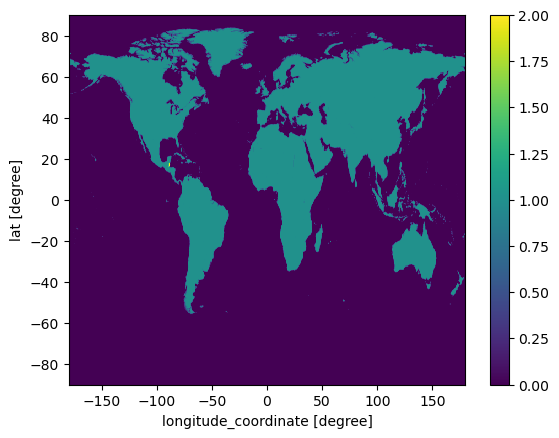

In [74]:
da_countrymasks.isel(variable=slice(0,225)).sum(dim='variable').plot()

### find missing pixels ! and assign to a country..... 

In [75]:
landseamask = xr.open_dataarray('./data-new/country-masks/landseamask_no-ant.nc')
landseamask

/apps/brussel/RL8/skylake/software/xarray/2023.9.0-gfbf-2023a/lib/python3.11/site-packages/xarray/coding/times.py:831: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/skylake/software/xarray/2023.9.0-gfbf-2023a/lib/python3.11/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.DataArray 'mask' (time: 1, lat: 360, lon: 720)>
[259200 values with dtype=float32]
Coordinates:
  * time     (time) object 1601-01-01 00:00:00
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Attributes:
    standard_name:  wfde5_era5_mask_no-ant
    long_name:      WFDE5-ERA5 Mask w/o Antarctica
    units:          1

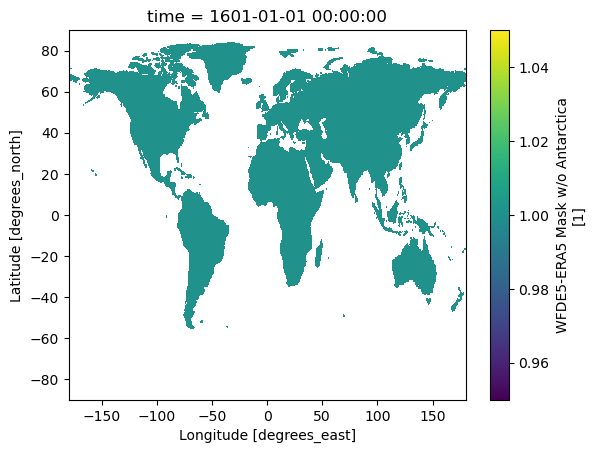

In [38]:
landseamask.plot()

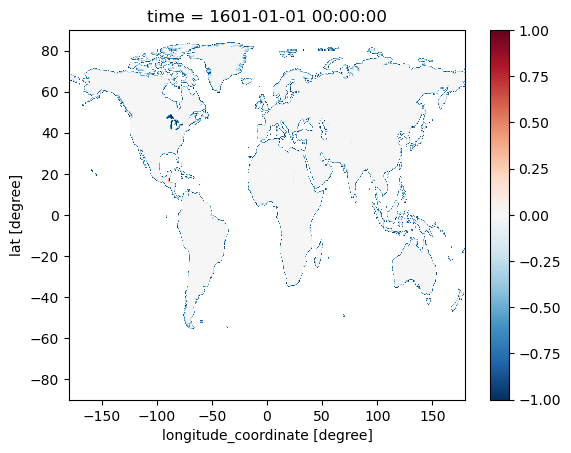

In [76]:
countrymask_sum = da_countrymasks.isel(variable=slice(0,225)).sum(dim='variable')
(countrymask_sum - landseamask).plot()

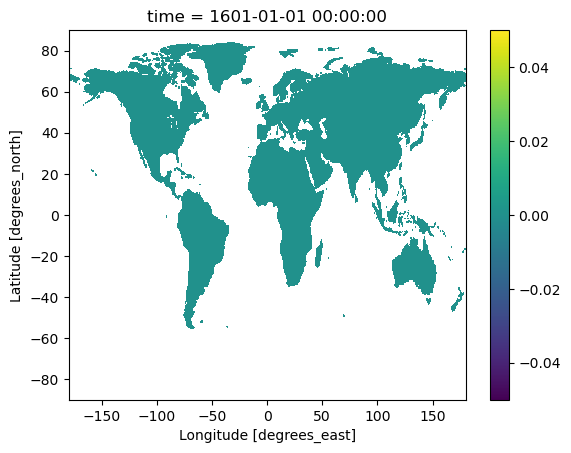

In [77]:
((landseamask * da_population.sel(time=1959)) - da_population.sel(time=1959)).plot()

In [78]:
((landseamask * da_population.sel(time=1959)) - da_population.sel(time=1959)).sum()

<xarray.DataArray ()>
array(0., dtype=float32)

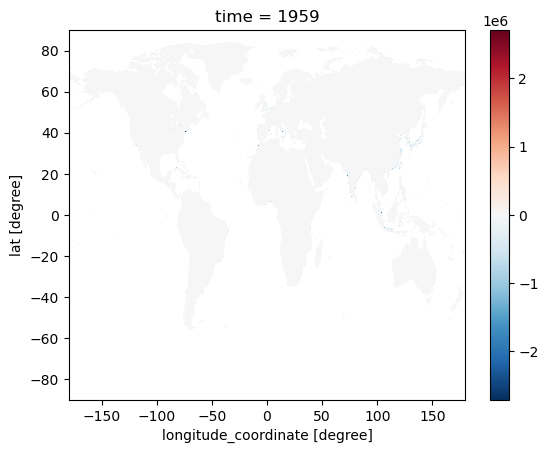

In [79]:
((countrymask_sum * da_population) - da_population).sel(time=1959).plot()

In [80]:
(da_population - (countrymask_sum * da_population) ).sel(time=1959).sum()

<xarray.DataArray ()>
array(2.1863626e+08, dtype=float32)
Coordinates:
    time     int64 1959

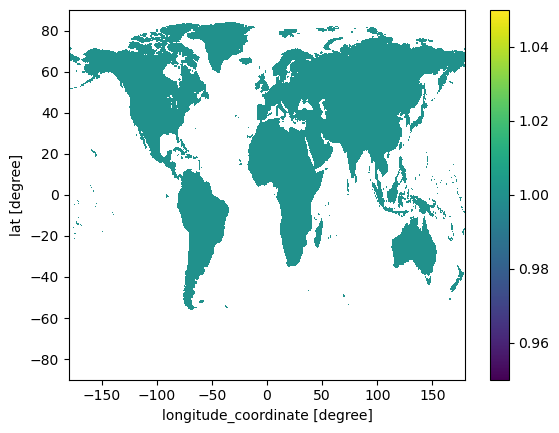

In [81]:
countrymask_bin = xr.where(countrymask_sum != 0, 1, np.nan)
countrymask_bin.plot()

<xarray.DataArray ()>
array(0.)


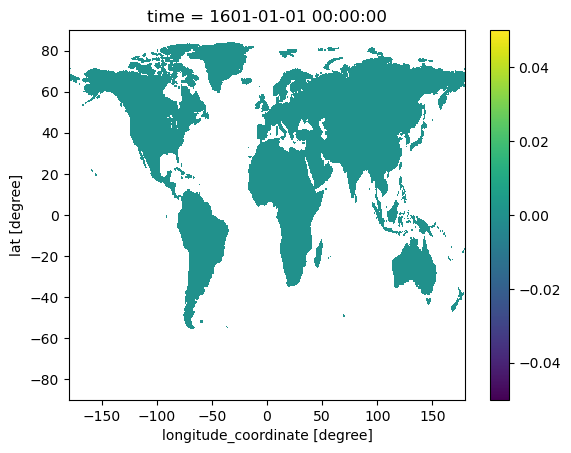

In [82]:
(countrymask_bin - landseamask).plot()
print((countrymask_bin - landseamask).sum())

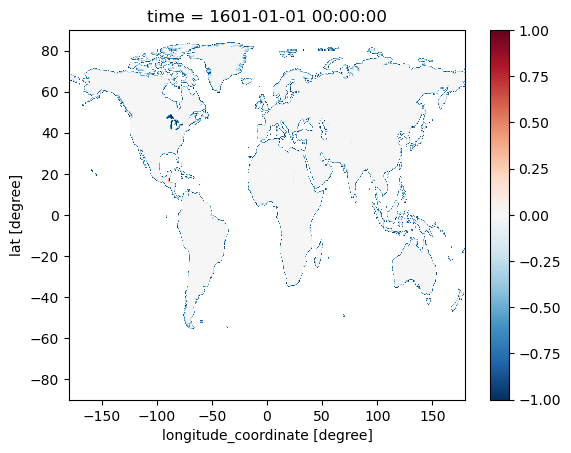

In [83]:
diff = countrymask_sum - landseamask
diff.plot()

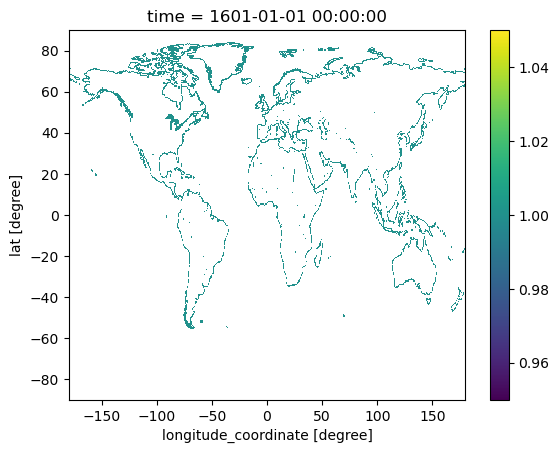

In [84]:
diff_bin = xr.where((diff < 0), 1, np.nan)
diff_bin.plot()

In [87]:
da_countrymasks_correct = xr.where(countrymask_sum < 1, da_countrymasks*(1/da_countrymasks.sum(dim='variable')), da_countrymasks)

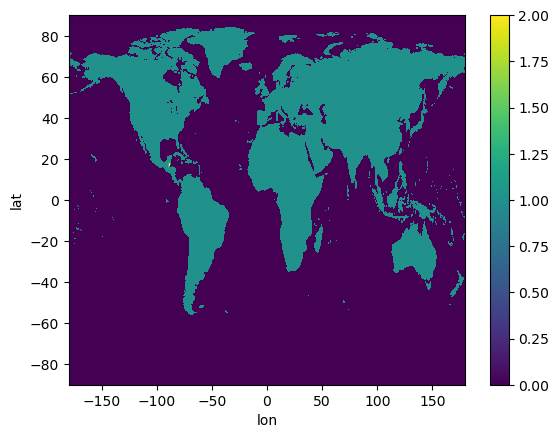

In [88]:
da_countrymasks_correct.sum(dim='variable').plot()

In [93]:
da_countrymasks_correct_corr = xr.where(da_countrymasks_correct.sum(dim='variable') > 1, da_countrymasks_correct/da_countrymasks_correct.sum(dim='variable'), da_countrymasks_correct)

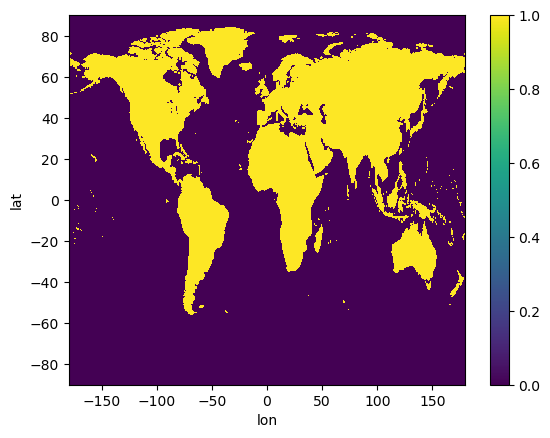

In [94]:
da_countrymasks_correct_corr.sum(dim='variable').plot()

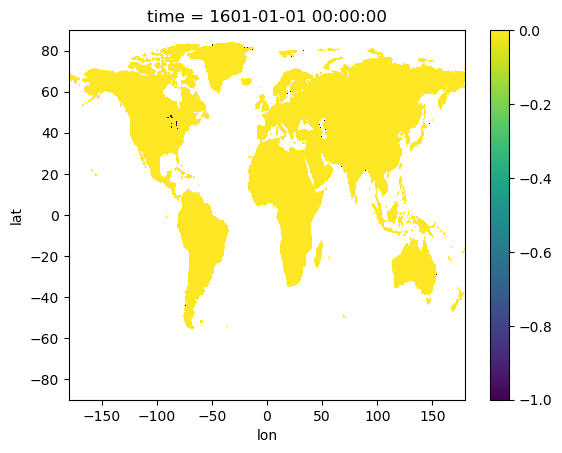

In [95]:
diff = da_countrymasks_correct_corr.sum(dim='variable') - landseamask
diff.plot()

In [96]:
(da_population - (da_countrymasks_correct_corr.sum(dim='variable') * da_population) ).sel(time=1959).sum()

<xarray.DataArray ()>
array(11.073085, dtype=float32)
Coordinates:
    time     int64 1959

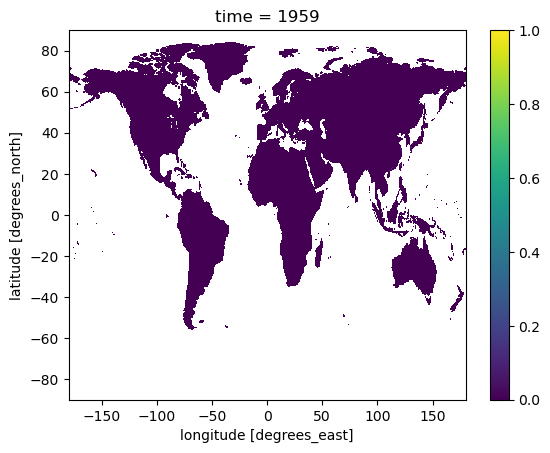

In [97]:
(da_population - (da_countrymasks_correct_corr.sum(dim='variable') * da_population) ).sel(time=1959).plot()

### develop

In [263]:
filepath='./data-new/country-masks/isipedia-countries/countrymasks_fractional.nc'

In [274]:
ds=xr.open_dataset(filepath)
country_mask_frac = ds.to_array()
country_mask_frac

# note the dataset has the long name of each variable ! 

<xarray.DataArray (variable: 226, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * variable  (variable) object 'm_AFG' 'm_AGO' 'm_ALB' ... 'm_ZWE' 'm_world'
Attributes:
    CDI:          Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    source:       ASAP-GAUL, Natural Earth 10m v5.0.1
    repository:   https://github.com/ISI-MIP/isipedia-countries
    version:      v2.6
    note:         Fractional mask
    isimip_id:    b4bd2422-7e6e-4278-8dca-eb34ba730da2
    CDO:          Climate Data Operators version 1.8.0 (http://mpimet.mpg.de/...

In [276]:
variable_long_names = {}

# Loop through each variable in the dataset
for var_name in ds.data_vars:
 # Get the long name attribute, if it exists
 long_name = ds[var_name].attrs.get('long_name', 'No long name found')
 # Store the long name in the dictionary
 variable_long_names[var_name] = long_name

# Print the variable names and their long names
for var, long_name in variable_long_names.items():
 print(f"{var}: {long_name}")

m_AFG: Afghanistan
m_AGO: Angola
m_ALB: Albania
m_AND: Andorra
m_ARE: United Arab Emirates
m_ARG: Argentina
m_ARM: Armenia
m_ASM: American Samoa
m_ATF: French Southern and Antarctic Territories
m_ATG: Antigua and Barbuda
m_AUS: Australia
m_AUT: Austria
m_AZE: Azerbaijan
m_BDI: Burundi
m_BEL: Belgium
m_BEN: Benin
m_BFA: Burkina Faso
m_BGD: Bangladesh
m_BGR: Bulgaria
m_BHR: Bahrain
m_BHS: Bahamas
m_BIH: Bosnia and Herzegovina
m_BLR: Belarus
m_BLZ: Belize
m_BMU: Bermuda
m_BOL: Bolivia
m_BRA: Brazil
m_BRB: Barbados
m_BRN: Brunei Darussalam
m_BTN: Bhutan
m_BWA: Botswana
m_CAF: Central African Republic
m_CAN: Canada
m_CHE: Switzerland
m_CHL: Chile
m_CHN: China
m_CIV: Côte d'Ivoire
m_CMR: Cameroon
m_COD: Democratic Republic of the Congo
m_COG: Congo
m_COL: Colombia
m_COM: Comoros
m_CPV: Cape Verde
m_CRI: Costa Rica
m_CSID: Caribbean island small states
m_CUB: Cuba
m_CUW: Curaçao
m_CYM: Cayman Islands
m_CYP: Cyprus
m_CZE: Czech Republic
m_DEU: Germany
m_DJI: Djibouti
m_DMA: Dominica
m_DNK: Den

In [280]:
strings = country_mask_frac['variable'].values
cleaned_strings = [s[2:] if s.startswith('m_') else s for s in strings]
country_mask_frac['variable'] = cleaned_strings

In [281]:
country_mask_frac

<xarray.DataArray (variable: 226, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * variable  (variable) <U5 'AFG' 'AGO' 'ALB' 'AND' ... 'ZMB' 'ZWE' 'world'
Attributes:
    CDI:          Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    source:       ASAP-GAUL, Natural Earth 10m v5.0.1
    repository:   https://github.com/ISI-MIP/isipedia-countries
    version:      v2.6
    note:         Fractional mask
    isimip_id:    b4bd2422-7e6e-4278-8dca-eb34ba730da2
    CDO:          Climate Data Operators version 1.8.0 (http://mpimet.mpg.de/...

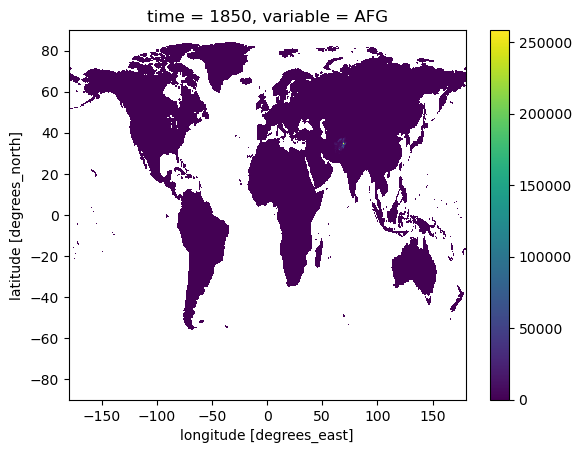

In [285]:
(da_population * country_mask_frac.sel(variable='AFG')).sel(time=1850).plot()

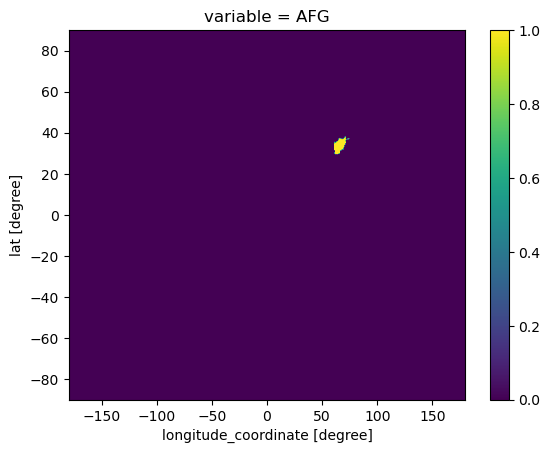

In [287]:
country_mask_frac.sel(variable='AFG').plot()

# make a zero-filled data array and add info on each country one at a time?

## 8. get_gridscale_demographics()

To do:
- add first a fxn that makes a dictionary of countries incl. life expectancy etc. 
- 

In [158]:
def get_gridscale_demographics(
    da_population,
    da_countrymasks,
    df_countries_matched, # use v3 !!
    da_cohort_size,
    startyear=1955,
    endyear=1960
):

    da_pop = da_population.sel(time=slice(startyear, endyear)).chunk({'time': 100, 'lat': 100, 'lon': 100}) # check optimal chunking sizes, maybe chunk when I open population already? to avoid rechunking
    
    # Initialize the combined demographics DataArray
    da_pop_demographics = None
    
    # Fix issue in Singapore pixel, assign fraction from IOSID to SGP 
    da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='SGP')] += da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='IOSID')].values
    da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='IOSID')] = 0
    
    # Fix it also in Mauritius 
    da_countrymasks.loc[dict(lat=da_countrymasks.lat[220], lon=da_countrymasks.lon[474], variable='MUS')] += da_countrymasks.loc[dict(lat=da_countrymasks.lat[220], lon=da_countrymasks.lon[474], variable='IOSID')].values
    da_countrymasks.loc[dict(lat=da_countrymasks.lat[220], lon=da_countrymasks.lon[474], variable='IOSID')] = 0
    
    
    # Loop over countries in WCDE cohort sizes
    for country in da_cohort_size_ssp3.country.values:
        print(country)
    
        # Get iso3 code of the country in the mask 
        iso = df_countries_matched[df_countries_matched['country_wcde']==country]['iso3_frac'].values[0]
    
        # if this isocode is in the mask file 
        if iso in da_countrymasks['variable']: # do this in a slightly more intelligent way??? similar to what i was doing b4 with the dataframs, instead of if
        
            # Get cohort sizes of the country
            da_smple_cht = da_cohort_size.sel(country=country).sel(time=slice(startyear, endyear)).chunk({'time': 10, 'ages': 10})
        
            # Cohort relative sizes in the sample country
            da_smple_cht_prp = da_smple_cht / da_smple_cht.sum(dim='ages')
        
            # Get population of that country and multiply by fraction of each cohort
            pop_country = ((da_pop * da_countrymasks.sel(variable=iso)) * da_smple_cht_prp).drop_vars(['variable', 'country'])
        
            if da_pop_demographics is None:
                da_pop_demographics = pop_country
            else:
                da_pop_demographics += pop_country
        
            # Explicitly clear intermediate variables to free up memory
            del iso, da_smple_cht, da_smple_cht_prp, pop_country
        else:
            print('**iso not in mask')
            pass
    
    da_pop_demographics = da_pop_demographics.compute()
    
    return da_pop_demographics

In [162]:
da_pop_demographics_pres = get_gridscale_demographics(
    da_population, # run this in function? 
    da_countrymasks,
    df_countries_matched_v3, # use v3 !!
    da_cohort_size,
    startyear=1995,
    endyear=2000
)

Afghanistan
Albania
Algeria
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
**iso not in mask
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia (Plurinational State of)
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Channel Islands
**iso not in mask
Chile
China
Colombia
Comoros
Congo


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Costa Rica
Cote d'Ivoire


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Croatia
Cuba
Curaçao
**iso not in mask
Cyprus
Czech Republic
Democratic People's Republic of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
French Guiana
French Polynesia
Gabon
Gambia
Georgia
Germany


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hong Kong Special Administrative Region of China


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Hungary
Iceland
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Kazakhstan
Kenya
Kiribati
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Latvia
Lebanon
Lesotho
Liberia
Libyan Arab Jamahiriya
Lithuania


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Luxembourg
Macao Special Administrative Region of China
**iso not in mask
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Martinique
Mauritania
Mauritius
Mayotte
Mexico
Micronesia (Federated States of)


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Mongolia
Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Netherlands
New Caledonia
New Zealand
Nicaragua
Niger


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Nigeria
Norway
Occupied Palestinian Territory
Oman
Pakistan
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Portugal


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Puerto Rico
Qatar
Republic of Korea
Republic of Moldova
Reunion
Romania
Russian Federation
Rwanda
Saint Lucia
Saint Vincent and the Grenadines
Samoa
Sao Tome and Principe


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Saudi Arabia
Senegal
Serbia
Seychelles
Sierra Leone
Singapore
Slovakia
Slovenia
Solomon Islands
Somalia
South Africa
South Sudan


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Spain
Sri Lanka
Sudan
Suriname
Swaziland
Sweden
Switzerland
Syrian Arab Republic
Taiwan Province of China
Tajikistan
Thailand
The former Yugoslav Republic of Macedonia


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Timor-Leste
Togo
Tonga
Trinidad and Tobago
Tunisia
Turkey
Turkmenistan
Uganda
Ukraine
United Arab Emirates
United Kingdom of Great Britain and Northern Ireland
United Republic of Tanzania


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


United States Virgin Islands
United States of America
Uruguay
Uzbekistan
Vanuatu
Venezuela (Bolivarian Republic of)
Viet Nam
Western Sahara
World
**iso not in mask
Yemen
Zambia
Zimbabwe


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


In [163]:
da_pop_demographics_pres

<xarray.DataArray (time: 6, lat: 360, lon: 720, ages: 105)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) int64 1995 1996 1997 1998 1999 2000
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [164]:
da_pop_demographics_pres.sel(time=2000).sum(dim=['lat','lon','ages'])

<xarray.DataArray ()>
array(6.13940693e+09)
Coordinates:
    time     int64 2000

In [165]:
da_population.sel(time=2000).sum(dim=['lat','lon'])

<xarray.DataArray 'total-population' ()>
array(6.1412347e+09, dtype=float32)
Coordinates:
    time     int64 2000

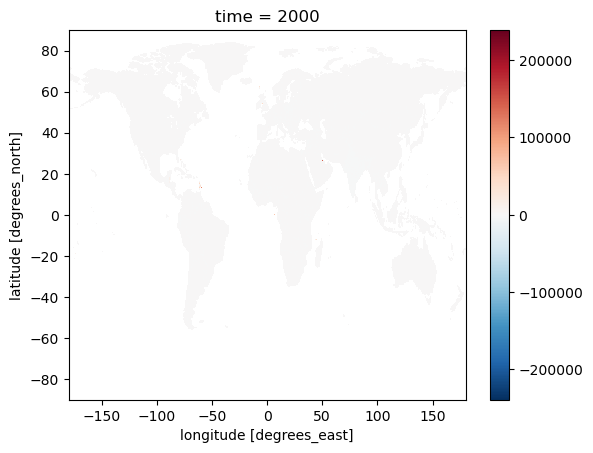

In [167]:
(da_population.sel(time=2000) - da_pop_demographics_pres.sel(time=2000).sum(dim=['ages'])).plot()

#plt.savefig('pop_processed_test_v2.pdf', dpi=300)

# smth strange in arab peninsula / caribbean islands

In [168]:
(da_population.sel(time=2000) - da_pop_demographics_pres.sel(time=2000).sum(dim=['ages'])).sum()

# version 1. 

# 16 million people lost due to missing cohort size data or different countries covered in WB and countrymasks
# options
# 1. ignore (~0.5 % of world pop in 1959)
# 2. assign them the world-average demographic division? or of their region? 

# including only 195 countries official minus those that dont have wcde data (i.e. total of ??) minus those that dont have country mask (ie ??)


# version 2. 
# 3 milion people lost due to missing cohort size data and/or different country boundaries covered in countrymasks and WCDE

# including also territories not in the official 195 UN list but that have WCDE and countrymask data 

# version 3. 2 milion people lost

# version 4. 
# 1.2 milion people lost (in 1959), 1.8 mln people in 2000 

<xarray.DataArray ()>
array(1827158.41609131)
Coordinates:
    time     int64 2000

In [169]:
(da_population.sel(time=2000) - da_pop_demographics_pres.sel(time=2000).sum(dim=['ages'])).sum() / da_population.sel(time=2000).sum(dim=['lat','lon'])
# v1
# 0,5 % of population

#v2
# 0,1 % of population

# v3
# 0,07% of population

# v4
# 0,03% of population missing 

# in 2020 similar to 1959 original cehck 
#0,03% of population missing

<xarray.DataArray ()>
array(0.00029752)
Coordinates:
    time     int64 2000

### develop

In [119]:
# test countries v2

startyear=1950
endyear=2020

# get full population data
da_pop = da_population.sel(time=slice(startyear,endyear)) 

da_pop_demographics = None

for country in da_cohort_size_ssp3.country[0:5].values:
    print(country)

    # get iso3 code of country
    iso = df_countries_matched_v3[df_countries_matched_v3['country_wcde']==country]['iso3_frac'].values[0]

    if iso in da_countrymasks['variable']: # do this in a slightly more intelligent way??? similar to what i was doing b4 with the dataframs 
        print('T')

        # get cohort sizes of the coutnry 
        da_smple_cht = da_cohort_size.sel(country=country).sel(time=slice(startyear,endyear))  
        
        # cohort relative sizes in sample country
        da_smple_cht_prp = da_smple_cht / da_smple_cht.sum(dim='ages') 
    
        # get population of that country 
        pop_country = ((da_pop * da_countrymasks.sel(variable=iso)) * da_smple_cht_prp).drop_vars(['variable','country'])
    
        if da_pop_demographics is None:
            da_pop_demographics=pop_country
        else:
            da_pop_demographics =+ pop_country

    else:
        pass

Afghanistan
T
Albania
T
Algeria
T
Angola
T
Antigua and Barbuda
T


In [120]:
del da_pop_demographics, pop_country, da_smple_cht_prp, da_smple_cht, da_pop

### v2

TODO: count admin units I'm considering, n of official countries in 195 country list (I think like 187) + n of additional admin units for which WCDE provides data and ISIMIP provides fractional countrymasks. 


In [121]:
 da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='IOSID')].values

array(0.27647454, dtype=float32)

In [138]:
startyear=1955
endyear=1960

da_pop = da_population.sel(time=slice(startyear, endyear)).chunk({'time': 100, 'lat': 100, 'lon': 100}) # check optimal chunking sizes

# Initialize the combined demographics DataArray
da_pop_demographics = None

# Fix issue in Singapore pixel, assign fraction from IOSID to SGP 
da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='SGP')] += da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='IOSID')].values
da_countrymasks.loc[dict(lat=da_countrymasks.lat[177], lon=da_countrymasks.lon[567], variable='IOSID')] = 0

# Fix it also in Mauritius 
da_countrymasks.loc[dict(lat=da_countrymasks.lat[220], lon=da_countrymasks.lon[474], variable='MUS')] += da_countrymasks.loc[dict(lat=da_countrymasks.lat[220], lon=da_countrymasks.lon[474], variable='IOSID')].values
da_countrymasks.loc[dict(lat=da_countrymasks.lat[220], lon=da_countrymasks.lon[474], variable='IOSID')] = 0


# Loop over countries in WCDE cohort sizes
for country in da_cohort_size_ssp3.country.values:
    print(country)

    # Get iso3 code of the country in the mask 
    iso = df_countries_matched_v3[df_countries_matched_v3['country_wcde']==country]['iso3_frac'].values[0]

    # if this isocode is in the mask file 
    if iso in da_countrymasks['variable']: # do this in a slightly more intelligent way??? similar to what i was doing b4 with the dataframs, instead of if
    
        # Get cohort sizes of the country
        da_smple_cht = da_cohort_size.sel(country=country).sel(time=slice(startyear, endyear)).chunk({'time': 10, 'ages': 10})
    
        # Cohort relative sizes in the sample country
        da_smple_cht_prp = da_smple_cht / da_smple_cht.sum(dim='ages')
    
        # Get population of that country and multiply by fraction of each cohort
        pop_country = ((da_pop * da_countrymasks.sel(variable=iso)) * da_smple_cht_prp).drop_vars(['variable', 'country'])
    
        if da_pop_demographics is None:
            da_pop_demographics = pop_country
        else:
            da_pop_demographics += pop_country
    
        # Explicitly clear intermediate variables to free up memory
        del iso, da_smple_cht, da_smple_cht_prp, pop_country
    else:
        print('**iso not in mask')
        pass

# Compute the final result
da_pop_demographics = da_pop_demographics.compute()

Afghanistan
Albania
Algeria
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
**iso not in mask
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia (Plurinational State of)
Bosnia and Herzegovina
Botswana
Brazil
Brunei Darussalam
Bulgaria


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Channel Islands
**iso not in mask
Chile
China
Colombia
Comoros
Congo


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Costa Rica
Cote d'Ivoire
Croatia
Cuba
Curaçao
**iso not in mask
Cyprus
Czech Republic
Democratic People's Republic of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
French Guiana
French Polynesia
Gabon
Gambia
Georgia


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hong Kong Special Administrative Region of China


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Hungary
Iceland
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Kazakhstan
Kenya
Kiribati
Kuwait
Kyrgyzstan
Lao People's Democratic Republic
Latvia
Lebanon
Lesotho
Liberia
Libyan Arab Jamahiriya
Lithuania
Luxembourg


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Macao Special Administrative Region of China
**iso not in mask
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Martinique
Mauritania
Mauritius
Mayotte
Mexico
Micronesia (Federated States of)
Mongolia


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Montenegro
Morocco
Mozambique
Myanmar
Namibia
Nepal
Netherlands
New Caledonia
New Zealand
Nicaragua
Niger
Nigeria


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Norway
Occupied Palestinian Territory
Oman
Pakistan
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Qatar
Republic of Korea
Republic of Moldova
Reunion
Romania
Russian Federation
Rwanda
Saint Lucia
Saint Vincent and the Grenadines
Samoa
Sao Tome and Principe
Saudi Arabia


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Senegal
Serbia
Seychelles
Sierra Leone
Singapore
Slovakia
Slovenia
Solomon Islands
Somalia
South Africa
South Sudan
Spain


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Sri Lanka
Sudan
Suriname
Swaziland
Sweden
Switzerland
Syrian Arab Republic
Taiwan Province of China
Tajikistan
Thailand
The former Yugoslav Republic of Macedonia
Timor-Leste


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


Togo
Tonga
Trinidad and Tobago
Tunisia
Turkey
Turkmenistan
Uganda
Ukraine
United Arab Emirates
United Kingdom of Great Britain and Northern Ireland
United Republic of Tanzania
United States Virgin Islands


/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


United States of America
Uruguay
Uzbekistan
Vanuatu
Venezuela (Bolivarian Republic of)
Viet Nam
Western Sahara
World
**iso not in mask
Yemen
Zambia
Zimbabwe


In [139]:
da_pop_demographics

<xarray.DataArray (time: 6, lat: 360, lon: 720, ages: 105)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) int64 1955 1956 1957 1958 1959 1960
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

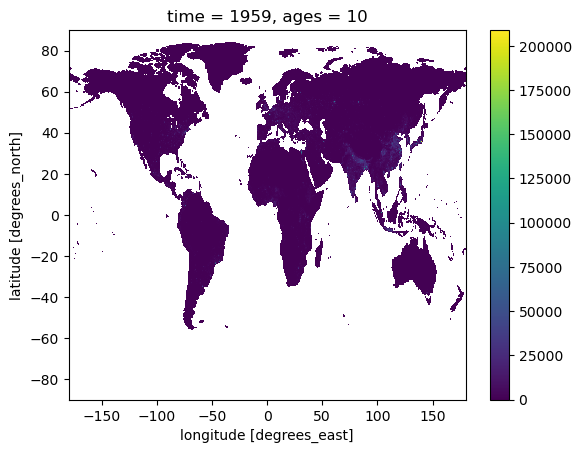

In [140]:
da_pop_demographics.sel(time=1959,ages=10).plot()

In [141]:
da_pop_demographics.sel(time=1959).sum(dim=['lat','lon','ages'])

<xarray.DataArray ()>
array(2.97771649e+09)
Coordinates:
    time     int64 1959

In [142]:
da_population.sel(time=1959).sum(dim=['lat','lon'])

<xarray.DataArray 'total-population' ()>
array(2.9785492e+09, dtype=float32)
Coordinates:
    time     int64 1959

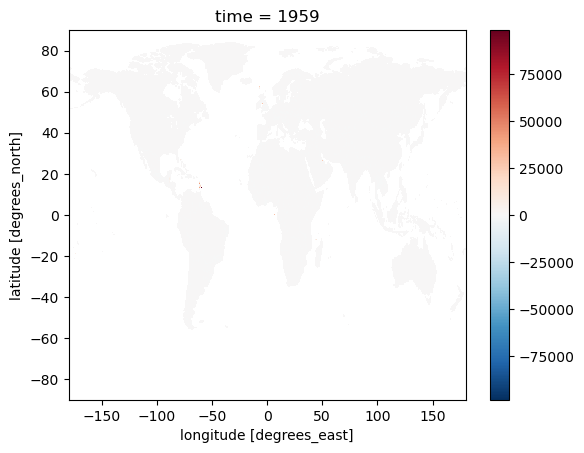

In [143]:
(da_population.sel(time=1959) - da_pop_demographics.sel(time=1959).sum(dim=['ages'])).plot()

#plt.savefig('pop_processed_test_v2.pdf', dpi=300)

In [144]:
(da_population.sel(time=1959) - da_pop_demographics.sel(time=1959).sum(dim=['ages'])).sum()

# version 1. 

# 16 million people lost due to missing cohort size data or different countries covered in WB and countrymasks
# options
# 1. ignore (~0.5 % of world pop in 1959)
# 2. assign them the world-average demographic division? or of their region? 

# including only 195 countries official minus those that dont have wcde data (i.e. total of ??) minus those that dont have country mask (ie ??)


# version 2. 
# 3 milion people lost due to missing cohort size data and/or different country boundaries covered in countrymasks and WCDE

# including also territories not in the official 195 UN list but that have WCDE and countrymask data 

# version 3. 2 milion people lost

# version 4. 
# 1.2 milion people lost

<xarray.DataArray ()>
array(832774.41379972)
Coordinates:
    time     int64 1959

In [145]:
(da_population.sel(time=1959) - da_pop_demographics.sel(time=1959).sum(dim=['ages'])).sum() / da_population.sel(time=1959).sum(dim=['lat','lon'])
# v1
# 0,5 % of population

#v2
# 0,1 % of population

# v3
# 0,07% of population

# v4
# 0,03% of population missing 

<xarray.DataArray ()>
array(0.00027959)
Coordinates:
    time     int64 1959

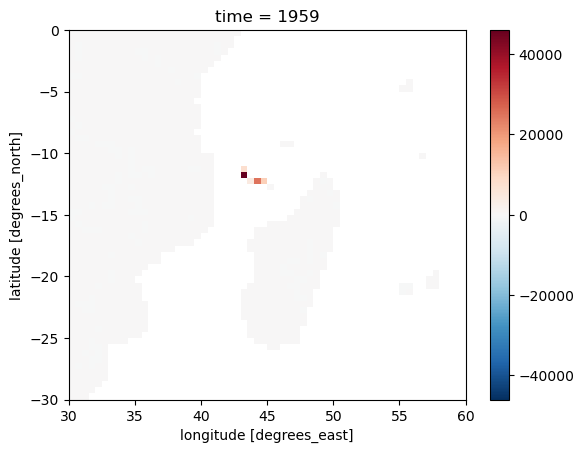

In [146]:
da_slice = (da_population.sel(time=1959) - da_pop_demographics.sel(time=1959).sum(dim=['ages'])).sel(lat=slice(0,-30),lon=slice(30,60))

da_slice.plot()


In [147]:
da_slice.max()

<xarray.DataArray ()>
array(46012.390625)
Coordinates:
    time     int64 1959

In [148]:
da_slice.argmax(...)

{'lat': <xarray.DataArray ()>
 array(23)
 Coordinates:
     time     int64 1959,
 'lon': <xarray.DataArray ()>
 array(26)
 Coordinates:
     time     int64 1959}

In [150]:
df = da_countrymasks.sel(lat=-20.25,lon=57.25).to_pandas()
df[df != 0]

variable
MUS    1.0
dtype: float32

In [153]:
df = da_countrymasks.isel(lat=220,lon=474).to_pandas()
df[df != 0]

variable
MUS    1.0
dtype: float32

In [151]:
da_diff = (da_population.sel(time=1959) - da_pop_demographics.sel(time=1959).sum(dim=['ages']))

In [152]:
da_diff.argmax(...)

{'lat': <xarray.DataArray ()>
 array(153)
 Coordinates:
     time     int64 1959,
 'lon': <xarray.DataArray ()>
 array(240)
 Coordinates:
     time     int64 1959}

In [154]:
df = da_countrymasks.isel(lat=153,lon=240).to_pandas()
df[df != 0]

variable
BRB     0.5
CSID    0.5
dtype: float32

## for production

In [35]:
startyears = np.arange(1950, 2100, 50)
startyears = np.array([1950, 2001, 2051])
startyears

array([1950, 2001, 2051])

In [33]:
endyears = np.append(startyears[1:] - 1, 2100)
endyears

array([2000, 2050, 2100])

In [31]:

for i in range(len(startyears)):
    print(startyears[i], endyears[i])

1850 1900
1901 1950
1951 2000
2001 2050
2051 2100
